<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/AirFrance/AirFrance_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AF.PA"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High   Low  Close  Adj Close   Volume
Date                                                     
2009-01-02   9.38   9.80  9.06   9.80       9.58  1419568
2009-01-05   9.89  10.03  9.77  10.00       9.77  1756012
2009-01-06  10.00  10.05  9.85   9.95       9.73  1441376
2009-01-07   9.92   9.94  9.74   9.87       9.65  1656512
2009-01-08   9.76   9.82  9.53   9.66       9.44  1798384
...           ...    ...   ...    ...        ...      ...
2018-12-21   9.12   9.55  9.08   9.39       9.39  5647594
2018-12-24   9.31   9.42  9.01   9.13       9.13  1484141
2018-12-27   9.20   9.34  8.94   9.04       9.04  2731985
2018-12-28   9.01   9.39  9.01   9.36       9.36  2654662
2018-12-31   9.42   9.57  9.40   9.48       9.48  1042316

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean      8.386694     8.522899     8.238815     8.378490     8.348568  3.489851e+06
std       2.663198     2.695818     2.633117     2.664614     2.643339  2.020676e+06
min       3.090000     3.140000     3.010000     3.060000     3.060000  0.000000e+00
25%       6.530000     6.650000     6.420000     6.530000     6.527500  2.203118e+06
50%       7.950000     8.090000     7.795000     7.950000     7.940000  3.064608e+06
75%      10.522500    10.730000    10.310000    10.520000    10.445000  4.127165e+06
max      15.100000    15.300000    14.930000    15.110000    15.110000  2.242723e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open  High   Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08    SMA_8    TEMA_8  TRIMA_8     WMA_8   MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2009-03-13  7.15  7.18  6.87   6.95       6.79  1589142   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  6.837373  7.014645  6.261580  6.819084  6.887423  6.999529       6.710       6.745  6.381280  6.75125  6.933182   6.6905  6.813333  6.75125  6.990000  7.138198                7.312181                  6.75125                6.190319                7.592647                  6.75125                5.909853                7.873112                  6.75125                5.629388                8.153578                  6.75125                5.348922  6.887423  6.931037  7.075024                7.448354                 6.887423                6.326492                7.728820                 6.887423                6.046026                8.009285                 6.887423                5.765561                8.289751                 6.887423                5.485095   
2009-03-16  7.16  7.31  7.00   7.18       7.02  1426640   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  6.854505  7.010642  6.281748  6.949857  6.952440  7.001636       6.770       6.765  6.452378  6.76625  7.089742   6.7840  6.908611  6.76625  7.065000  7.097492                7.364576                  6.76625                6.167924                7.663739                  6.76625                5.868761                7.962902                  6.76625                5.569598                8.262064                  6.76625                5.270436  6.952440  7.105137  7.039214                7.550766                 6.952440                6.354114                7.849929                 6.952440                6.054951                8.149092                 6.952440                5.755789                8.448255                 6.952440                5.456626   
2009-03-17  7.12  7.17  

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean      8.394266     8.529425     8.248097     8.386860     8.359968  3.505248e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197     8.387541     8.382428    -0.352868     8.386705     8.383460     8.401050     8.384336     8.383460     8.382659     8.383338     8.386926     8.383376     8.384548     8.383338     8.386537     8.377191                8.821323                 8.383338                7.945354                9.040315                 8.383338                7.726362                9.259307                 8.383338                7.507370                9.478299                 8.383338                7.288378     8.383460     8.386268     8.378047                8.821444                 8.383460                7.945475                9.040436                 8.383460                7.726483                9.259428   
std       2.684742     2.717934     2.654219     2.686188     2.664280  2.030745e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     2.679581     2.653367     8.822948     2.693078     2.667897     2.652167     2.669152     2.667087     2.693816     2.674537     2.689336     2.677330     2.676363     2.674537     2.684003     2.650544                2.789588                 2.674537                2.580815                2.854324                 2.674537                2.542710                2.923449                 2.674537                2.510810                2.996660                 2.674537                2.485354     2.667897     2.681735     2.654297                2.782683                 2.667897                2.574514                2.847313                 2.667897                2.536610                2.916348   
min       3.090000     3.140000     3.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.338052  0.332237  0.323826  0.322822   0.309544  1589142   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.319710  0.335617  0.725620  0.310775  0.320123  0.329645    0.299742    0.301553  0.274311  0.305098  0.319456  0.300744  0.311838  0.305098  0.326223  0.344477                0.320618                 0.305098                0.287330                0.325306                 0.305098                0.281919                0.330865                 0.305098                0.276554                0.325580                 0.305098                0.271234  0.320123  0.322844  0.338462                0.332910                 0.320123                0.296153                0.339108                 0.320123                0.290581                0.346289                 0.320123                0.285056                0.342684                 0.320123   
2009-03-16  0.338884  0.342928  0.334732  0.341909   0.328631  1426640   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.321209  0.335252  0.726299  0.321797  0.325789  0.329834    0.304910    0.303279  0.280096  0.306391  0.332478  0.308746  0.320018  0.306391  0.332497  0.340801                0.324922                 0.306391                0.285397                0.330917                 0.306391                0.278387                0.337674                 0.306391                0.271437                0.333250                 0.306391                0.264545  0.325789  0.337495  0.335244                0.341374                 0.325789                0.298592                0.348788                 0.325789                0.291365                0.357085                 0.325789                0.284201                0.354176                 0.325789   
2009-03-17  0.335554  0.331414  0.328859  0.332780  

139969

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         5 hours 28 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_cqyd7n
H2O cluster total nodes:    1
H2O cluster free memory:    8.43 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.541778  0.690814              0.500000  0.498924  0.248925
1  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.524825  0.704174              0.476254  0.504535  0.254556
2  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.500000  0.699931              0.500000  0.503360  0.253371
3  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.499873  0.708045              0.500000  0.507292  0.257346
4  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.499111  1.945225              0.480222  0.644214  0.415011
5              DeepLearning_1_AutoML_20190826_192317  0.481524  0.922935              0.492095  0.551375  0.304015
6  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.479714  0.710117              0.488095  0.508277  0.258345
7  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.473651  1.372734              0.480254  0.627904  0.394263
8  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.464000  0.753892              0.500000  0.526116  0.276798
9  DeepLearning_grid_1_AutoML_20190826_192317_mod...  0.413143  0.833643              0.496032  0.550546  0.303101

variable  relative_importance  scaled_importance  percentage
0               days_in_month             1.000000           1.000000    0.001235
1                         COS             0.975448           0.975448    0.001204
2                         BOP             0.962563           0.962563    0.001189
3                  aroonup_12             0.941969           0.941969    0.001163
4                   CORREL_12             0.941071           0.941071    0.001162
...                       ...                  ...                ...         ...
1035  BBANDS_middleband_8_4_2             0.699329           0.699329    0.000864
1036  BBANDS_lowerband_24_1_2             0.699157           0.699157    0.000863
1037  BBANDS_lowerband_12_3_2             0.697116           0.697116    0.000861
1038                MAVP_12_7             0.694733           0.694733    0.000858
1039                  SAR_0.3             0.669846           0.669846    0.000827

[1040 rows x 4 columns]

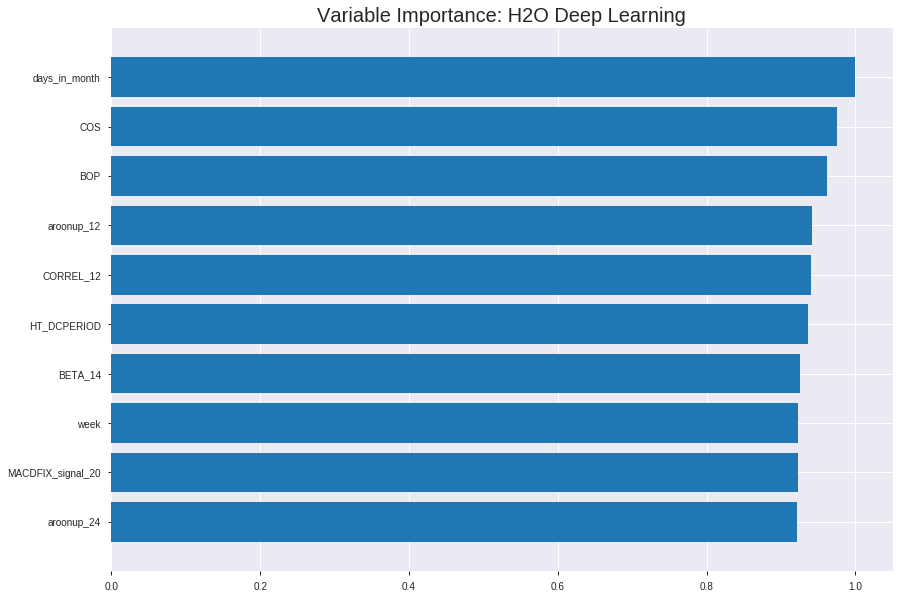

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_192317_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24465829853235146
RMSE: 0.49462945578720996
LogLoss: 0.681687411137682
Mean Per-Class Error: 0.4461839326495165
AUC: 0.5731665716197812
pr_auc: 0.5828089441749795
Gini: 0.14633314323956248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.507765431187526: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      68   794   0.9211   (794.0/862.0)
1      18   873   0.0202   (18.0/891.0)
Total  86   1667  0.4632   (812.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507765     0.682565  320
max f2                       0.329496     0.840415  377
max f0point5                 0.520157     0.581156  242
max accuracy                 0.52289      0.55676   215
max precision                0.941915     1         0
max recall                   0.293697     1         388
max specificity              0.941915     1         0
max absolute_mcc             0.507765     0.135831  320
max min_per_class_accuracy   0.527312     0.539443  172
max mean_per_class_accuracy  0.52289      0.553816  215

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 52.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.652868           1.85815   1.85815            0.944444         0.798675  0.944444                    0.798675            0.0190797       0.0190797                  85.8149    85.8149
    2        0.0205362                   0.60285            1.63954   1.74885            0.833333         0.629988  0.888889                    0.714332            0.016835        0.0359147                  63.9544    74.8846
    3        0.0302339                   0.562993           1.38879   1.63336            0.705882         0.581486  0.830189                    0.671721            0.013468        0.0493827                  38.879     63.3357
    4        0.040502                    0.548351           0.983726  1.46866            0.5              0.552876  0.746479                    0.641591            0.010101        0.0594837                  -1.62738   46.8662
    5        0.0501997                   0.542856           0.694395  1.31909            0.352941         0.545339  0.670455                    0.622997            0.00673401      0.0662177                  -30.5605   31.9087
    6        0.100399                    0.533059           1.14023   1.22966            0.579545         0.537236  0.625                       0.580116            0.0572391       0.123457                   14.0228    22.9658
    7        0.216771                    0.53239            1.13804   1.18047            0.578431         0.532398  0.6                         0.554499            0.132435        0.255892                   13.8036    18.0471
    8        0.300057                    0.53017            0.929823  1.1109             0.472603         0.531034  0.564639                    0.547986            0.0774411       0.333333                   -7.01767   11.09
    9        0.399886                    0.528712           1.0568    1.09739            0.537143         0.529442  0.557775                    0.543356            0.105499        0.438833                   5.6803     9.73949
    10       0.500285                    0.527285           0.994905  1.07683            0.505682         0.528037  0.54732                     0.540282            0.0998878       0.538721                   -0.509514  7.68268
    11       0.600114                    0.52525            1.03432   1.06976            0.525714         0.526369  0.543726                    0.537968            0.103255        0.641975                   3.43178    6.97554
    12       0.699943                    0.522102           1.00059   1.05989            0.508571         0.523751  0.538712                    0.53594             0.0998878       0.741863                   0.0590027  5.98908
    13       0.799772                    0.518896           1.0568    1.05951            0.537143         0.520684  0.538516                    0.534036            0.105499        0.847363                   5.6803     5.95053
    14       0.899601                    0.513482           0.865679  1.038              0.44             0.516948  0.527584                    0.532139            0.0864198       0.933782                   -13.4321   3.79964
    15       1                           0.112688           0.659544  1                  0.335227         0.457884  0.508272                    0.524684            0.0662177       1                          -34.0456   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24731556304403354
RMSE: 0.4973083178914601
LogLoss: 0.6878700155191255
Mean Per-Class Error: 0.4607085085732773
AUC: 0.49222743448722095
pr_auc: 0.5520789239591459
Gini: -0.015545131025558101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3215023430451198: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    211  0.9591   (211.0/220.0)
1      3    278  0.0107   (3.0/281.0)
Total  12   489  0.4271   (214.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321502     0.722078  387
max f2                       0.20933      0.864615  399
max f0point5                 0.510843     0.62591   345
max accuracy                 0.510843     0.580838  345
max precision                0.711876     1         0
max recall                   0.20933      1         399
max specificity              0.711876     1         0
max absolute_mcc             0.510843     0.107338  345
max min_per_class_accuracy   0.527432     0.454545  174
max mean_per_class_accuracy  0.513966     0.539291  299

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 51.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.571127           0.891459  0.891459           0.5              0.624319  0.5                         0.624319            0.0106762       0.0106762                  -10.8541  -10.8541
    2        0.0219561                   0.550492           1.06975   0.972501           0.6              0.556282  0.545455                    0.593393            0.0106762       0.0213523                  6.97509   -2.74992
    3        0.0319361                   0.548639           0.713167  0.891459           0.4              0.549185  0.5                         0.579578            0.00711744      0.0284698                  -28.6833  -10.8541
    4        0.0419162                   0.547933           1.42633   1.01881            0.8              0.548247  0.571429                    0.572118            0.0142349       0.0427046                  42.6335   1.88104
    5        0.0518962                   0.545224           1.06975   1.02861            0.6              0.546897  0.576923                    0.567268            0.0106762       0.0533808                  6.97509   2.86066
    6        0.101796                    0.537084           0.784484  0.908939           0.44             0.541761  0.509804                    0.554765            0.0391459       0.0925267                  -21.5516  -9.10613
    7        0.211577                    0.53239            1.03733   0.975559           0.581818         0.532999  0.54717                     0.543471            0.113879        0.206406                   3.73342   -2.4441
    8        0.301397                    0.530231           1.03013   0.991822           0.577778         0.531191  0.556291                    0.539811            0.0925267       0.298932                   3.01305   -0.817798
    9        0.401198                    0.528516           0.820142  0.949116           0.46             0.529482  0.532338                    0.537242            0.0818505       0.380783                   -17.9858  -5.08844
    10       0.500998                    0.52736            0.784484  0.91632            0.44             0.527995  0.513944                    0.5354              0.0782918       0.459075                   -21.5516  -8.36795
    11       0.600798                    0.525281           1.21238   0.965501           0.68             0.526379  0.541528                    0.533901            0.120996        0.580071                   21.2384   -3.44995
    12       0.700599                    0.520316           1.21238   1.00067            0.68             0.523479  0.561254                    0.532417            0.120996        0.701068                   21.2384   0.0669161
    13       0.800399                    0.513004           1.31936   1.04041            0.74             0.516278  0.583541                    0.530404            0.131673        0.83274                    31.9359   4.04061
    14       0.9002                      0.510581           0.891459  1.02389            0.5              0.511631  0.574279                    0.528323            0.088968        0.921708                   -10.8541  2.38931
    15       1                           0.20933            0.784484  1                  0.44             0.415418  0.560878                    0.517055            0.0782918       1                          -21.5516  0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 19:43:34  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 19:43:36  9 min 57.429 sec   311 obs/sec       0.359384  1             630        0.656934         2.36468             -0.726722      0.516596        0.502038           1.31163          0.491728                         0.686695           2.87463               -0.914581        0.482773          0.56292              1.48577            0.439122
    2019-08-26 19:44:04  10 min 26.175 sec  402 obs/sec       6.41928   18            11253      0.50063          0.694596            -0.0027966     0.549323        0.544396           1.53024          0.472333                         0.503081           0.699593              -0.0275965       0.476917          0.563066             1.48577            0.433134
    2019-08-26 19:44:33  10 min 54.950 sec  429 obs/sec       13.1934   37            23128      0.496463         0.685802            0.0138298      0.563002        0.575453           1.85815          0.479179                         0.498348           0.689773              -0.00835297      0.502378          0.566505             1.18861            0.429142
    2019-08-26 19:45:02  11 min 23.750 sec  447 obs/sec       20.3594   57            35690      0.494629         0.681687            0.0210989      0.573167        0.582809           1.85815          0.463206                         0.497308           0.68787               -0.00414839      0.492227          0.552079             0.891459           0.427146
    2019-08-26 19:45:31  11 min 52.312 sec  462 obs/sec       27.8511   78            48823      0.492092         0.675659            0.0311168      0.559297        0.619123           1.85815          0.457501                         0.498635           0.692808              -0.00951451      0.5055            0.548596             0.891459           0.427146
    2019-08-26 19:45:59  12 min 21.117 sec  482 obs/sec       36.1962   101           63452      0.495719         0.682618            0.0167835      0.567627        0.616146           1.85815          0.448945                         0.496898           0.689908              -0.00249309      0.508331          0.595758             1.18861            0.421158
    2019-08-26 19:46:29  12 min 50.402 sec  496 obs/sec       44.761    125           78466      0.487767         0.665762            0.0480737      0.608598        0.622872           1.85815          0.444381                         0.502107           0.703535              -0.0236211       0.494144          0.556099             1.18861            0.42515
    2019-08-26 19:46:32  12 min 53.280 sec  496 obs/sec       44.761    125           78466      0.494629         0.681687            0.0210989      0.573167        0.582809           1.85815          0.463206                         0.497308           0.68787               -0.00414839      0.492227          0.552079             0.891459           0.427146

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
days_in_month            1.0                    1.0                  0.0012347674338853054
COS                      0.9754481315612793     0.9754481315612793   0.0012044515862961365
BOP                      0.9625628590583801     0.9625628590583801   0.001188541271432819
aroonup_12               0.941969096660614      0.941969096660614    0.0011631127642828855
CORREL_12                0.9410706758499146     0.9410706758499146   0.0011620034235239089
---                      ---                    ---                  ---
BBANDS_middleband_8_4_2  0.6993294954299927     0.6993294954299927   0.0008635092865123974
BBANDS_lowerband_24_1_2  0.6991567015647888     0.6991567015647888   0.0008632959262748685
BBANDS_lowerband_12_3_2  0.6971157789230347     0.6971157789230347   0.0008607758614617514
MAVP_12_7                0.6947332620620728     0.6947332620620728   0.0008578340072311529
SAR_0.3                  0.669845700263977      0.669845700263977    0.0008271036564140563


See the whole table with table.as_data_frame()


('accuracy', 0.549800796812749)

('F1', 0.6648936170212766)

('auc', 0.5417777777777777)

('logloss', 0.6908142090135707)

('mean_per_class_error', 0.4493015873015873)

('rmse', 0.498923531688182)

('mse', 0.24892469047220833)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


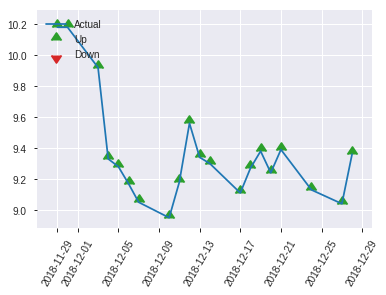


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24892469047220833
RMSE: 0.498923531688182
LogLoss: 0.6908142090135707
Mean Per-Class Error: 0.4493015873015873
AUC: 0.5417777777777777
pr_auc: 0.5569417477336256
Gini: 0.08355555555555538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3764222044129535: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    126  1        (126.0/126.0)
1      0    125  0        (0.0/125.0)
Total  0    251  0.502    (126.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376422     0.664894  247
max f2                       0.376422     0.832224  247
max f0point5                 0.524273     0.568581  178
max accuracy                 0.524487     0.549801  176
max precision                0.75519      1         0
max recall                   0.376422     1         247
max specificity              0.75519      1         0
max absolute_mcc             0.570553     0.157117  5
max min_per_class_accuracy   0.527948     0.531746  122
max mean_per_class_accuracy  0.524273     0.550698  178

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 52.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.60969            2.008     2.008              1                0.688649  1                           0.688649            0.024           0.024                      100.8     100.8
    2        0.0239044                   0.570553           2.008     2.008              1                0.579209  1                           0.633929            0.024           0.048                      100.8     100.8
    3        0.0318725                   0.557233           1.004     1.757              0.5              0.562657  0.875                       0.616111            0.008           0.056                      0.4       75.7
    4        0.0438247                   0.54807            0.669333  1.46036            0.333333         0.55033   0.727273                    0.598171            0.008           0.064                      -33.0667  46.0364
    5        0.0517928                   0.545253           1.004     1.39015            0.5              0.546887  0.692308                    0.590281            0.008           0.072                      0.4       39.0154
    6        0.103586                    0.534443           1.23569   1.31292            0.615385         0.540022  0.653846                    0.565152            0.064           0.136                      23.5692   31.2923
    7        0.151394                    0.531894           1.004     1.21537            0.5              0.532494  0.605263                    0.554839            0.048           0.184                      0.4       21.5368
    8        0.203187                    0.531206           0.772308  1.10243            0.384615         0.531474  0.54902                     0.548883            0.04            0.224                      -22.7692  10.2431
    9        0.302789                    0.530574           0.88352   1.03042            0.44             0.530894  0.513158                    0.542966            0.088           0.312                      -11.648   3.04211
    10       0.40239                     0.529162           1.04416   1.03382            0.52             0.529876  0.514851                    0.539726            0.104           0.416                      4.416     3.38218
    11       0.501992                    0.527948           1.2048    1.06775            0.6              0.528608  0.531746                    0.53752             0.12            0.536                      20.48     6.7746
    12       0.601594                    0.526848           0.8032    1.02395            0.4              0.527405  0.509934                    0.535845            0.08            0.616                      -19.68    2.3947
    13       0.701195                    0.525012           1.28512   1.06105            0.64             0.525836  0.528409                    0.534423            0.128           0.744                      28.512    6.10455
    14       0.800797                    0.519747           0.8032    1.02898            0.4              0.522531  0.512438                    0.532944            0.08            0.824                      -19.68    2.89751
    15       0.900398                    0.510334           0.72288   0.995115           0.36             0.515584  0.495575                    0.531024            0.072           0.896                      -27.712   -0.488496
    16       1                           0.376422           1.04416   1                  0.52             0.498511  0.498008                    0.527786            0.10

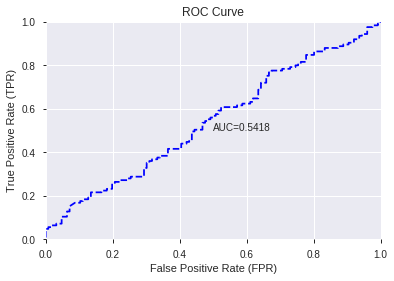

This function is available for GLM models only


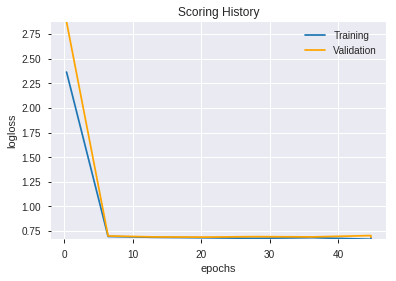

--2019-08-26 20:00:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.132
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.132|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_192317_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_192317_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_200030_model_9  0.513651  0.704109              0.444635  0.505395  0.255425
1               DeepLearning_1_AutoML_20190826_200030  0.492508  0.745911              0.472349  0.522046  0.272532
2  DeepLearning_grid_1_AutoML_20190826_200030_model_5  0.480952  0.755423              0.496032  0.525573  0.276227
3  DeepLearning_grid_1_AutoML_20190826_200030_model_8  0.470603  0.707860              0.500000  0.507203  0.257255
4  DeepLearning_grid_1_AutoML_20190826_200030_model_7  0.467111  0.812486              0.484159  0.545521  0.297593
5  DeepLearning_grid_1_AutoML_20190826_200030_model_1  0.464254  1.998457              0.476222  0.661011  0.436935
6  DeepLearning_grid_1_AutoML_20190826_200030_model_2  0.451175  1.397942              0.488095  0.623555  0.388821
7  DeepLearning_grid_1_AutoML_20190826_200030_model_3  0.448444  1.129720              0.492063  0.599876  0.359851
8  DeepLearning_grid_1_AutoML_20190826_200030_model_6  0.434984  0.724511              0.484159  0.514885  0.265107
9  DeepLearning_grid_1_AutoML_20190826_200030_model_4  0.430540  1.198691              0.500000  0.625241  0.390926

variable  relative_importance  scaled_importance  percentage
0         HT_DCPERIOD             1.000000           1.000000    0.021625
1                DX_8             0.981651           0.981651    0.021228
2               month             0.979807           0.979807    0.021188
3              ATR_30             0.976348           0.976348    0.021114
4          AROONOSC_8             0.973174           0.973174    0.021045
5        weekday_name             0.967596           0.967596    0.020924
6         AROONOSC_14             0.963127           0.963127    0.020828
7       days_in_month             0.963019           0.963019    0.020825
8                 COS             0.958935           0.958935    0.020737
9                 day             0.955854           0.955854    0.020670
10         aroonup_20             0.954978           0.954978    0.020651
11     STOCHRSI_fastk             0.951825           0.951825    0.020583
12          dayofyear             0.947853           0.947853    0.020497
13                SIN             0.947432           0.947432    0.020488
14            BETA_12             0.945812           0.945812    0.020453
15             SAREXT             0.945214           0.945214    0.020440
16          dayofweek             0.943874           0.943874    0.020411
17               week             0.940649           0.940649    0.020342
18     STOCHRSI_fastd             0.939313           0.939313    0.020313
19            ADXR_12             0.935477           0.935477    0.020230
20          CORREL_12             0.934647           0.934647    0.020212
21         PLUS_DM_12             0.934241           0.934241    0.020203
22            NATR_14             0.933945           0.933945    0.020197
23  MACDFIX_signal_24             0.928149           0.928149    0.020071
24            weekday             0.927319           0.927319    0.020053
25       aroondown_30             0.925977           0.925977    0.020024
26            BETA_14             0.925964           0.925964    0.020024
27               SINH             0.920510           0.920510    0.019906
28         aroonup_30             0.918559           0.918559    0.019864
29              DX_30             0.915633           0.915633    0.019801
30  MACDFIX_signal_20             0.914432           0.914432    0.019775
31                BOP             0.913586           0.913586    0.019756
32         aroonup_14             0.912843           0.912843    0.019740
33            ADXR_14             0.912457           0.912457    0.019732
34            quarter             0.911375           0.911375    0.019709
35              DX_14             0.909271           0.909271    0.019663
36             ADX_24             0.906853           0.906853    0.019611
37         aroonup_12             0.906613           0.906613    0.019606
38    MACDFIX_hist_12             0.901024           0.901024    0.019485
39              VAR_8             0.899921           0.899921    0.019461
40               COSH             0.896108           0.896108    0.019378
41  MACDFIX_signal_12             0.880887           0.880887    0.019049
42             MFI_12             0.874837           0.874837    0.018918
43  CDLGRAVESTONEDOJI             0.874748           0.874748    0.018916
44             BETA_8             0.873355           0.873355    0.018886
45        AROONOSC_20             0.871495           0.871495    0.018846
46         aroonup_24             0.870660           0.870660    0.018828
47          CORREL_14             0.861814           0.861814    0.018637
48   is_quarter_start             0.861474           0.861474    0.018629
49        AROONOSC_30             0.852051           0.852051    0.018426

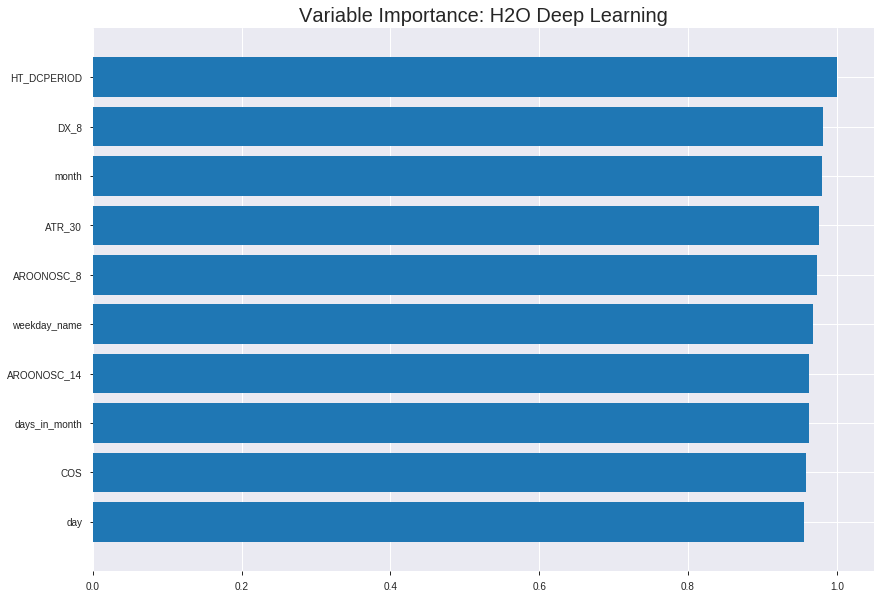

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_200030_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25406432017988057
RMSE: 0.5040479344069179
LogLoss: 0.7013764027835443
Mean Per-Class Error: 0.47260501378830844
AUC: 0.5279249051484164
pr_auc: 0.5289557475096401
Gini: 0.05584981029683278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5639939577317419: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    862   1        (862.0/862.0)
1      0    891   0        (0.0/891.0)
Total  0    1753  0.4917   (862.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.563994     0.673979   399
max f2                       0.563994     0.837879   399
max f0point5                 0.564544     0.566064   391
max accuracy                 0.572535     0.528808   273
max precision                0.615692     1          0
max recall                   0.563994     1          399
max specificity              0.615692     1          0
max absolute_mcc             0.566979     0.0573563  357
max min_per_class_accuracy   0.574007     0.511785   247
max mean_per_class_accuracy  0.572535     0.527395   273

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 57.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.60309            1.20233   1.20233            0.611111         0.606587  0.611111                    0.606587            0.0123457       0.0123457                  20.2332   20.2332
    2        0.0205362                   0.598744           0.76512   0.983726           0.388889         0.600934  0.5                         0.603761            0.00785634      0.020202                   -23.488   -1.62738
    3        0.0302339                   0.59645            1.15732   1.03941            0.588235         0.597666  0.528302                    0.601806            0.0112233       0.0314254                  15.7325   3.94088
    4        0.040502                    0.593852           0.983726  1.02529            0.5              0.59513   0.521127                    0.600113            0.010101        0.0415264                  -1.62738  2.5292
    5        0.0501997                   0.590866           1.27306   1.07316            0.647059         0.592422  0.545455                    0.598627            0.0123457       0.0538721                  27.3057   7.31558
    6        0.100399                    0.584294           1.16259   1.11787            0.590909         0.586685  0.568182                    0.592656            0.0583614       0.112233                   16.2585   11.7871
    7        0.150029                    0.582009           0.92719   1.05479            0.471264         0.583068  0.536122                    0.589484            0.0460157       0.158249                   -7.28098  5.47938
    8        0.200228                    0.580349           1.14023   1.07621            0.579545         0.581079  0.547009                    0.587377            0.0572391       0.215488                   14.0228   7.62132
    9        0.300057                    0.577883           1.04556   1.06602            0.531429         0.579036  0.541825                    0.584602            0.104377        0.319865                   4.55604   6.6015
    10       0.399886                    0.575837           0.888164  1.02162            0.451429         0.576781  0.519258                    0.582649            0.0886644       0.40853                    -11.1836  2.16157
    11       0.500285                    0.573874           1.03962   1.02523            0.528409         0.574849  0.521095                    0.581084            0.104377        0.512907                   3.96197   2.52289
    12       0.600114                    0.57227            1.11302   1.03983            0.565714         0.573094  0.528517                    0.579755            0.111111        0.624018                   11.3016   3.98322
    13       0.699943                    0.570245           0.933135  1.02461            0.474286         0.571227  0.520782                    0.578539            0.0931538       0.717172                   -6.68655  2.46145
    14       0.799772                    0.567767           0.989347  1.02021            0.502857         0.569092  0.518545                    0.57736             0.0987654       0.815937                   -1.06526  2.02124
    15       0.899601                    0.564727           0.978105  1.01554            0.497143         0.56629   0.51617                     0.576131            0.0976431       0.91358                    -2.18951  1.55397
    16       1                           0.563994           0.86076   1                  0.4375           0.564078  0.508272                    0.574921          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24634368145533292
RMSE: 0.4963302141269791
LogLoss: 0.68581786027544
Mean Per-Class Error: 0.4644370753801359
AUC: 0.5191928178582983
pr_auc: 0.5774627899015001
Gini: 0.03838563571659659
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5639937709863112: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    220  1        (220.0/220.0)
1      0    281  0        (0.0/281.0)
Total  0    501  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.563994     0.71867    399
max f2                       0.563994     0.864615   399
max f0point5                 0.563994     0.61488    399
max accuracy                 0.563994     0.560878   399
max precision                0.5877       0.675676   35
max recall                   0.563994     1          399
max specificity              0.609609     0.995455   0
max absolute_mcc             0.583034     0.0808434  58
max min_per_class_accuracy   0.574227     0.518182   217
max mean_per_class_accuracy  0.575574     0.535563   184

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 57.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.600714           0.891459  0.891459           0.5              0.604335  0.5                         0.604335            0.0106762       0.0106762                  -10.8541   -10.8541
    2        0.0219561                   0.597582           1.06975   0.972501           0.6              0.599004  0.545455                    0.601912            0.0106762       0.0213523                  6.97509    -2.74992
    3        0.0319361                   0.596071           1.06975   1.00289            0.6              0.596563  0.5625                      0.60024             0.0106762       0.0320285                  6.97509    0.289146
    4        0.0419162                   0.595047           0.713167  0.93391            0.4              0.595461  0.52381                     0.599102            0.00711744      0.0391459                  -28.6833   -6.60905
    5        0.0518962                   0.591902           1.42633   1.02861            0.8              0.59273   0.576923                    0.597877            0.0142349       0.0533808                  42.6335    2.86066
    6        0.101796                    0.584553           1.2837    1.15365            0.72             0.587301  0.647059                    0.592693            0.0640569       0.117438                   28.3701    15.3653
    7        0.151697                    0.581982           0.927117  1.07913            0.52             0.583039  0.605263                    0.589517            0.0462633       0.163701                   -7.28826   7.91347
    8        0.201597                    0.579874           0.927117  1.04151            0.52             0.580942  0.584158                    0.587395            0.0462633       0.209964                   -7.28826   4.15066
    9        0.301397                    0.577551           0.998434  1.02724            0.56             0.578684  0.576159                    0.58451             0.0996441       0.309609                   -0.156584  2.72442
    10       0.401198                    0.575819           1.14107   1.05556            0.64             0.576724  0.59204                     0.582573            0.113879        0.423488                   14.1068    5.55585
    11       0.500998                    0.574278           0.927117  1.02997            0.52             0.575117  0.577689                    0.581088            0.0925267       0.516014                   -7.28826   2.99726
    12       0.600798                    0.572727           0.891459  1.00696            0.5              0.573446  0.564784                    0.579819            0.088968        0.604982                   -10.8541   0.696374
    13       0.700599                    0.57107            1.10541   1.02099            0.62             0.57181   0.57265                     0.578678            0.11032         0.715302                   10.5409    2.09873
    14       0.800399                    0.568923           0.927117  1.00928            0.52             0.570176  0.566085                    0.577618            0.0925267       0.807829                   -7.28826   0.928284
    15       0.9002                      0.566463           0.855801  0.992267           0.48             0.56777   0.556541                    0.576526            0.0854093       0.893238                   -14.4199   -0.773291
    16       1                           0.563994           1.06975   1                  0.6              0.564686  0.560878            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:09:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:09:37  3 min  9.474 sec  448 obs/sec       0.64575   1             1132       0.538248         0.798492            -0.159159      0.514215        0.523065           0.874423         0.484883                         0.553468           0.862631              -0.243747        0.438475          0.511937             0.297153           0.439122
    2019-08-26 20:09:54  3 min 26.056 sec  718 obs/sec       7.1312    11            12501      0.509434         0.712666            -0.0383761     0.520637        0.526067           1.20233          0.486594                         0.498787           0.690893              -0.0101289       0.441071          0.514876             0.594306           0.439122
    2019-08-26 20:10:11  3 min 43.724 sec  846 obs/sec       16.1209   25            28260      0.500387         0.693922            -0.00182379    0.50497         0.625177           1.42094          0.491728                         0.501803           0.69676               -0.0223795       0.502151          0.594132             1.48577            0.439122
    2019-08-26 20:10:29  4 min  0.957 sec  995 obs/sec       27.7621   43            48667      0.504048         0.701376            -0.0165355     0.527925        0.528956           1.20233          0.491728                         0.49633            0.685818              -0.000202368     0.519193          0.577463             0.891459           0.439122
    2019-08-26 20:10:46  4 min 18.619 sec  1081 obs/sec      40.0017   62            70123      0.504461         0.702222            -0.0182004     0.507399        0.528828           1.42094          0.491728                         0.496398           0.685955              -0.00047507      0.534536          0.606769             0.891459           0.439122
    2019-08-26 20:11:04  4 min 36.162 sec  1152 obs/sec      53.0268   82            92956      0.499424         0.691982            0.00203104     0.524078        0.546445           1.42094          0.491728                         0.499042           0.691271              -0.0111614       0.462245          0.528365             0.297153           0.439122
    2019-08-26 20:11:21  4 min 53.265 sec  1190 obs/sec      65.2698   101           114418     0.499207         0.69155             0.00289789     0.514083        0.555851           1.53024          0.491728                         0.499253           0.691676              -0.0120177       0.477337          0.517954             0.594306           0.43513
    2019-08-26 20:11:23  4 min 54.944 sec  1190 obs/sec      65.2698   101           114418     0.504048         0.701376            -0.0165355     0.527925        0.528956           1.20233          0.491728                         0.49633            0.685818              -0.000202368     0.519193          0.577463             0.891459           0.439122

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
HT_DCPERIOD       1.0                    1.0                  0.021625042293769138
DX_8              0.9816505908966064     0.9816505908966064   0.021228235545842578
month             0.9798069000244141     0.9798069000244141   0.02118836565275478
ATR_30            0.9763475060462952     0.9763475060462952   0.02111355611166715
AROONOSC_8        0.9731738567352295     0.9731738567352295   0.021044925811089764
---               ---                    ---                  ---
AROONOSC_20       0.871495246887207      0.871495246887207    0.01884612157275463
aroonup_24        0.8706600666046143     0.8706600666046143   0.018828060763820636
CORREL_14         0.8618136048316956     0.8618136048316956   0.018636755653831057
is_quarter_start  0.8614739179611206     0.8614739179611206   0.018629409910888236
AROONOSC_30       0.852051317691803      0.852051317691803    0.018425645781546963


See the whole table with table.as_data_frame()


('accuracy', 0.5537848605577689)

('F1', 0.6799999999999999)

('auc', 0.5136507936507937)

('logloss', 0.704109306276458)

('mean_per_class_error', 0.4446349206349207)

('rmse', 0.5053953963184536)

('mse', 0.2554245066198868)

deeplearning prediction progress: |███████████████████████████████████████| 100%


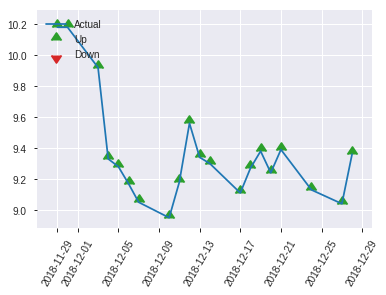


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2554245066198868
RMSE: 0.5053953963184536
LogLoss: 0.704109306276458
Mean Per-Class Error: 0.4446349206349207
AUC: 0.5136507936507937
pr_auc: 0.5197383594033796
Gini: 0.027301587301587382
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.564439572607145: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   106  0.8413   (106.0/126.0)
1      6    119  0.048    (6.0/125.0)
Total  26   225  0.4462   (112.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.56444      0.68      224
max f2                       0.563994     0.832224  232
max f0point5                 0.56444      0.580488  224
max accuracy                 0.56444      0.553785  224
max precision                0.60375      1         0
max recall                   0.563994     1         232
max specificity              0.60375      1         0
max absolute_mcc             0.56444      0.181689  224
max min_per_class_accuracy   0.572785     0.47619   125
max mean_per_class_accuracy  0.56444      0.555365  224

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 57.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.602403           2.008     2.008              1                0.603212  1                           0.603212            0.024           0.024                      100.8     100.8
    2        0.0239044                   0.599205           1.33867   1.67333            0.666667         0.600221  0.833333                    0.601716            0.016           0.04                       33.8667   67.3333
    3        0.0318725                   0.594102           0         1.255              0                0.596724  0.625                       0.600468            0               0.04                       -100      25.5
    4        0.0438247                   0.592542           1.33867   1.27782            0.666667         0.593438  0.636364                    0.598551            0.016           0.056                      33.8667   27.7818
    5        0.0517928                   0.591742           0         1.08123            0                0.59215   0.538462                    0.597566            0               0.056                      -100      8.12308
    6        0.103586                    0.582506           1.23569   1.15846            0.615385         0.586851  0.576923                    0.592209            0.064           0.12                       23.5692   15.8462
    7        0.151394                    0.578148           1.004     1.10968            0.5              0.579748  0.552632                    0.588274            0.048           0.168                      0.4       10.9684
    8        0.203187                    0.577008           0.772308  1.02369            0.384615         0.577447  0.509804                    0.585514            0.04            0.208                      -22.7692  2.36863
    9        0.302789                    0.575682           1.04416   1.03042            0.52             0.576347  0.513158                    0.582499            0.104           0.312                      4.416     3.04211
    10       0.40239                     0.573954           0.88352   0.994059           0.44             0.574686  0.49505                     0.580565            0.088           0.4                        -11.648   -0.594059
    11       0.501992                    0.572785           0.8032    0.95619            0.4              0.573461  0.47619                     0.579155            0.08            0.48                       -19.68    -4.38095
    12       0.601594                    0.571311           1.12448   0.984053           0.56             0.57195   0.490066                    0.577963            0.112           0.592                      12.448    -1.5947
    13       0.701195                    0.569277           1.12448   1.004              0.56             0.570539  0.5                         0.576908            0.112           0.704                      12.448    0.4
    14       0.800797                    0.56757            1.12448   1.01899            0.56             0.568418  0.507463                    0.575852            0.112           0.816                      12.448    1.89851
    15       0.900398                    0.564418           1.36544   1.05731            0.68             0.566044  0.526549                    0.574767            0.136           0.952                      36.544    5.73097
    16       1                           0.563994           0.48192   1                  0.24             0.564046  0.498008                    0.573699            0.0

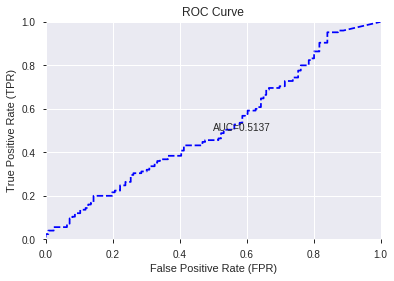

This function is available for GLM models only


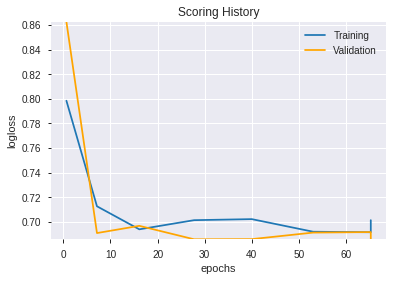

--2019-08-26 20:11:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_200030_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_200030_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_DCPERIOD',
 'DX_8',
 'month',
 'ATR_30',
 'AROONOSC_8',
 'weekday_name',
 'AROONOSC_14',
 'days_in_month',
 'COS',
 'day',
 'aroonup_20',
 'STOCHRSI_fastk',
 'dayofyear',
 'SIN',
 'BETA_12',
 'SAREXT',
 'dayofweek',
 'week',
 'STOCHRSI_fastd',
 'ADXR_12',
 'CORREL_12',
 'PLUS_DM_12',
 'NATR_14',
 'MACDFIX_signal_24',
 'weekday',
 'aroondown_30',
 'BETA_14',
 'SINH',
 'aroonup_30',
 'DX_30',
 'MACDFIX_signal_20',
 'BOP',
 'aroonup_14',
 'ADXR_14',
 'quarter',
 'DX_14',
 'ADX_24',
 'aroonup_12',
 'MACDFIX_hist_12',
 'VAR_8',
 'COSH',
 'MACDFIX_signal_12',
 'MFI_12',
 'CDLGRAVESTONEDOJI',
 'BETA_8',
 'AROONOSC_20',
 'aroonup_24',
 'CORREL_14',
 'is_quarter_start',
 'AROONOSC_30']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_201136_model_1  0.495111  0.693513              0.472349  0.500182  0.250182

variable  relative_importance  scaled_importance  percentage
0          aroonup_20             0.008772           1.000000    0.063870
1                SINH             0.007882           0.898521    0.057388
2                COSH             0.007865           0.896580    0.057264
3         HT_DCPERIOD             0.006315           0.719913    0.045981
4        weekday_name             0.006118           0.697481    0.044548
5                 BOP             0.006022           0.686447    0.043843
6           CORREL_14             0.005856           0.667554    0.042637
7              ATR_30             0.005478           0.624467    0.039885
8             ADXR_14             0.005208           0.593665    0.037917
9              ADX_24             0.004891           0.557514    0.035608
10          CORREL_12             0.004735           0.539748    0.034474
11             SAREXT             0.004339           0.494597    0.031590
12         PLUS_DM_12             0.004325           0.493080    0.031493
13        AROONOSC_20             0.004255           0.485053    0.030980
14          dayofyear             0.003651           0.416169    0.026581
15              month             0.003482           0.396887    0.025349
16            ADXR_12             0.003422           0.390057    0.024913
17         aroonup_30             0.003284           0.374404    0.023913
18     STOCHRSI_fastk             0.003120           0.355626    0.022714
19       aroondown_30             0.002830           0.322670    0.020609
20  CDLGRAVESTONEDOJI             0.002749           0.313430    0.020019
21            quarter             0.002628           0.299599    0.019135
22             BETA_8             0.002192           0.249883    0.015960
23              VAR_8             0.002131           0.242964    0.015518
24            BETA_14             0.002104           0.239862    0.015320
25         AROONOSC_8             0.002016           0.229827    0.014679
26                COS             0.001827           0.208280    0.013303
27   is_quarter_start             0.001689           0.192559    0.012299
28                day             0.001683           0.191876    0.012255
29      days_in_month             0.001415           0.161309    0.010303
30              DX_30             0.001384           0.157736    0.010075
31               week             0.001337           0.152373    0.009732
32             MFI_12             0.001276           0.145406    0.009287
33        AROONOSC_14             0.001200           0.136838    0.008740
34  MACDFIX_signal_24             0.001193           0.135981    0.008685
35         aroonup_12             0.001165           0.132827    0.008484
36    MACDFIX_hist_12             0.001079           0.122988    0.007855
37                SIN             0.001060           0.120818    0.007717
38  MACDFIX_signal_20             0.000923           0.105185    0.006718
39            NATR_14             0.000785           0.089469    0.005714
40            BETA_12             0.000738           0.084185    0.005377
41               DX_8             0.000657           0.074901    0.004784
42  MACDFIX_signal_12             0.000558           0.063594    0.004062
43         aroonup_14             0.000527           0.060051    0.003835
44         aroonup_24             0.000429           0.048956    0.003127
45        AROONOSC_30             0.000291           0.033155    0.002118
46     STOCHRSI_fastd             0.000196           0.022304    0.001425
47              DX_14             0.000136           0.015548    0.000993
48            weekday             0.000065           0.007467    0.000477
49          dayofweek             0.000062           0.007021    0.000448

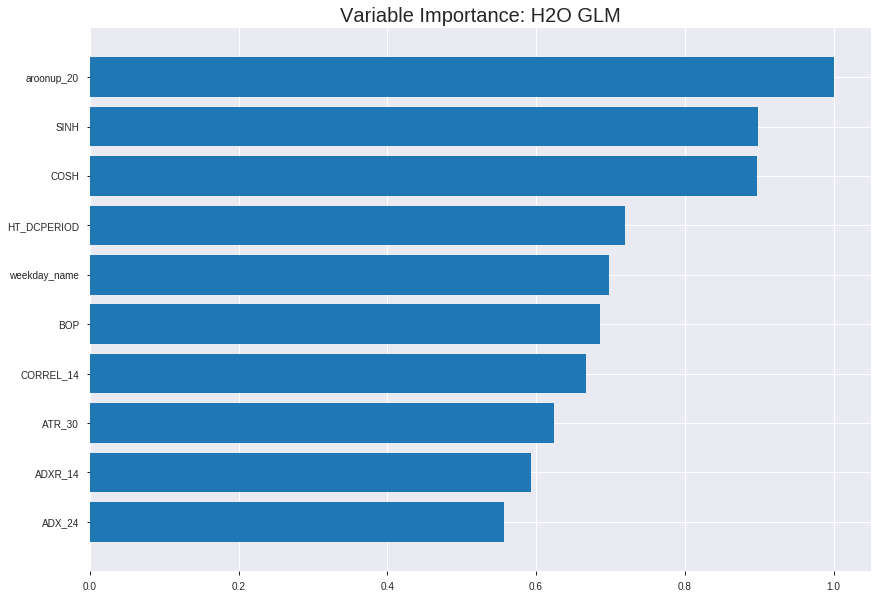

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_201136_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.249201887933441
RMSE: 0.4992012499317695
LogLoss: 0.6915496637225436
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.694244156657
Residual deviance: 2424.5731210112376
AIC: 2526.5731210112376
AUC: 0.5447560159470446
pr_auc: 0.5459033607011857
Gini: 0.08951203189408918
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48541936252710244: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   843   0.978    (843.0/862.0)
1      7    884   0.0079   (7.0/891.0)
Total  26   1727  0.4849   (850.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.485419     0.675325   375
max f2                       0.463856     0.838509   395
max f0point5                 0.498625     0.57253    311
max accuracy                 0.503702     0.536224   255
max precision                0.536257     1          0
max recall                   0.463856     1          395
max specificity              0.536257     1          0
max absolute_mcc             0.498625     0.0861849  311
max min_per_class_accuracy   0.508395     0.526682   195
max mean_per_class_accuracy  0.510867     0.533038   166

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.530993           1.31163   1.31163            0.666667         0.533223  0.666667                    0.533223            0.013468        0.013468                   31.1635   31.1635
    2        0.0205362                   0.528224           1.09303   1.20233            0.555556         0.529459  0.611111                    0.531341            0.0112233       0.0246914                  9.30291   20.2332
    3        0.0302339                   0.52554            1.27306   1.22502            0.647059         0.526801  0.622642                    0.529885            0.0123457       0.037037                   27.3057   22.5017
    4        0.040502                    0.523919           0.874423  1.13613            0.444444         0.524528  0.577465                    0.528527            0.00897868      0.0460157                  -12.5577  13.6134
    5        0.0501997                   0.522354           1.15732   1.14023            0.588235         0.522898  0.579545                    0.52744             0.0112233       0.0572391                  15.7325   14.0228
    6        0.100399                    0.518704           1.2073    1.17376            0.613636         0.520198  0.596591                    0.523819            0.0606061       0.117845                   20.73     17.3764
    7        0.150029                    0.516745           0.904576  1.08472            0.45977          0.517639  0.551331                    0.521775            0.0448934       0.162738                   -9.54242  8.4717
    8        0.200228                    0.514989           1.0508    1.07621            0.534091         0.515805  0.547009                    0.520278            0.0527497       0.215488                   5.07984   7.62132
    9        0.300057                    0.51256            1.07929   1.07724            0.548571         0.513624  0.547529                    0.518064            0.107744        0.323232                   7.92881   7.72362
    10       0.399886                    0.510325           1.09053   1.08056            0.554286         0.511541  0.549215                    0.516436            0.108866        0.432099                   9.05307   8.05551
    11       0.500285                    0.50837            0.939011  1.05215            0.477273         0.509366  0.534778                    0.515017            0.0942761       0.526375                   -6.09887  5.21495
    12       0.600114                    0.50639            0.989347  1.0417             0.502857         0.507332  0.529468                    0.513739            0.0987654       0.62514                    -1.06526  4.17024
    13       0.699943                    0.504263           1.0568    1.04386            0.537143         0.505323  0.530562                    0.512538            0.105499        0.73064                    5.6803    4.38561
    14       0.799772                    0.501647           0.944377  1.03144            0.48             0.502968  0.524251                    0.511344            0.0942761       0.824916                   -5.56229  3.1439
    15       0.899601                    0.498288           0.978105  1.02552            0.497143         0.50015   0.521243                    0.510102            0.0976431       0.922559                   -2.18951  2.55205
    16       1                           0.451479           0.771331  1                  0.392045         0.491874  0.508272                    0.508272           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24884466938479446
RMSE: 0.498843331502782
LogLoss: 0.6908381615964769
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 692.6521653604563
Residual deviance: 692.21983791967
AIC: 794.21983791967
AUC: 0.5072549336784212
pr_auc: 0.5553518105451931
Gini: 0.014509867356842454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4960060456190726: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    213  0.9682   (213.0/220.0)
1      2    279  0.0071   (2.0/281.0)
Total  9    492  0.4291   (215.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496006     0.721863  390
max f2                       0.49496      0.864731  393
max f0point5                 0.496006     0.620276  390
max accuracy                 0.497557     0.570858  375
max precision                0.523978     0.6       52
max recall                   0.489671     1         399
max specificity              0.555632     0.995455  0
max absolute_mcc             0.542547     0.124427  5
max min_per_class_accuracy   0.511989     0.5       203
max mean_per_class_accuracy  0.508002     0.521077  251

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.542547           0         0                  0                0.548351  0                           0.548351            0               0                          -100       -100
    2        0.0219561                   0.537485           1.42633   0.648334           0.8              0.540419  0.363636                    0.544745            0.0142349       0.0142349                  42.6335    -35.1666
    3        0.0319361                   0.532593           0.713167  0.668594           0.4              0.534609  0.375                       0.541578            0.00711744      0.0213523                  -28.6833   -33.1406
    4        0.0419162                   0.530764           1.06975   0.764108           0.6              0.531597  0.428571                    0.539201            0.0106762       0.0320285                  6.97509    -23.5892
    5        0.0518962                   0.528186           1.42633   0.891459           0.8              0.529009  0.5                         0.537241            0.0142349       0.0462633                  42.6335    -10.8541
    6        0.101796                    0.524362           1.14107   1.01382            0.64             0.525846  0.568627                    0.531656            0.0569395       0.103203                   14.1068    1.38162
    7        0.151697                    0.521545           0.998434  1.00876            0.56             0.522833  0.565789                    0.528753            0.0498221       0.153025                   -0.156584  0.875632
    8        0.201597                    0.520127           1.06975   1.02385            0.6              0.520872  0.574257                    0.526802            0.0533808       0.206406                   6.97509    2.3854
    9        0.301397                    0.51712            0.891459  0.980015           0.5              0.518353  0.549669                    0.524005            0.088968        0.295374                   -10.8541   -1.99854
    10       0.401198                    0.515075           1.14107   1.02008            0.64             0.515982  0.572139                    0.522009            0.113879        0.409253                   14.1068    2.00775
    11       0.500998                    0.511989           0.927117  1.00156            0.52             0.513382  0.561753                    0.52029             0.0925267       0.501779                   -7.28826   0.15596
    12       0.600798                    0.508629           1.10541   1.01881            0.62             0.510381  0.571429                    0.518644            0.11032         0.6121                     10.5409    1.88104
    13       0.700599                    0.506019           0.891459  1.00067            0.5              0.507467  0.561254                    0.517052            0.088968        0.701068                   -10.8541   0.0669161
    14       0.800399                    0.503197           0.998434  1.00039            0.56             0.504444  0.561097                    0.51548             0.0996441       0.800712                   -0.156584  0.0390483
    15       0.9002                      0.500339           1.06975   1.00808            0.6              0.501718  0.56541                     0.513954            0.106762        0.907473                   6.97509    0.808011
    16       1                           0.489671           0.927117  1                  0.52             0.497472  0.560878             


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 20:11:36  0.000 sec   2            2.1       51            1.3831            1.38168
    2019-08-26 20:11:36  0.019 sec   4            1.3       51            1.38198           1.38171
    2019-08-26 20:11:36  0.033 sec   6            0.79      51            1.38065           1.38201
    2019-08-26 20:11:36  0.046 sec   8            0.49      51            1.37914           1.38261
    2019-08-26 20:11:36  0.057 sec   10           0.3       51            1.37749           1.38352
    2019-08-26 20:11:36  0.070 sec   12           0.19      51            1.37573           1.3846

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.6703601108033241)

('auc', 0.4951111111111111)

('logloss', 0.6935126231072049)

('mean_per_class_error', 0.4530793650793651)

('rmse', 0.5001823474072012)

('mse', 0.2501823806577782)

glm prediction progress: |████████████████████████████████████████████████| 100%


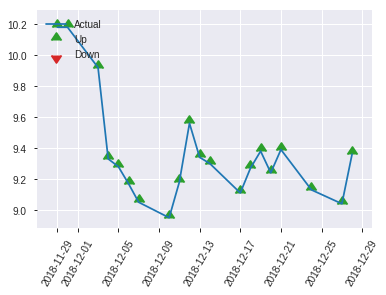


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2501823806577782
RMSE: 0.5001823474072012
LogLoss: 0.6935126231072049
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.0616751555067
Residual deviance: 348.14333679981684
AIC: 450.14333679981684
AUC: 0.4951111111111111
pr_auc: 0.4646667384392535
Gini: -0.009777777777777774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4999774020698316: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   115  0.9127   (115.0/126.0)
1      4    121  0.032    (4.0/125.0)
Total  15   236  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499977     0.67036   235
max f2                       0.492164     0.833333  249
max f0point5                 0.503316     0.569488  207
max accuracy                 0.505382     0.545817  180
max precision                0.505382     0.530387  180
max recall                   0.492164     1         249
max specificity              0.523689     0.992063  0
max absolute_mcc             0.513423     0.150657  39
max min_per_class_accuracy   0.508029     0.504     122
max mean_per_class_accuracy  0.504377     0.546921  194

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.522203           0         0                  0                0.522776  0                           0.522776            0               0                          -100      -100
    2        0.0239044                   0.521797           1.33867   0.669333           0.666667         0.52199   0.333333                    0.522383            0.016           0.016                      33.8667   -33.0667
    3        0.0318725                   0.519914           0         0.502              0                0.520555  0.25                        0.521926            0               0.016                      -100      -49.8
    4        0.0438247                   0.519115           0.669333  0.547636           0.333333         0.519443  0.272727                    0.521249            0.008           0.024                      -33.0667  -45.2364
    5        0.0517928                   0.518157           2.008     0.772308           1                0.518679  0.384615                    0.520853            0.016           0.04                       100.8     -22.7692
    6        0.103586                    0.515153           0.617846  0.695077           0.307692         0.516176  0.346154                    0.518515            0.032           0.072                      -38.2154  -30.4923
    7        0.151394                    0.513533           0.669333  0.686947           0.333333         0.51413   0.342105                    0.51713             0.032           0.104                      -33.0667  -31.3053
    8        0.203187                    0.512942           1.23569   0.826824           0.615385         0.513274  0.411765                    0.516147            0.064           0.168                      23.5692   -17.3176
    9        0.302789                    0.511156           1.12448   0.924737           0.56             0.511987  0.460526                    0.514779            0.112           0.28                       12.448    -7.52632
    10       0.40239                     0.509194           0.96384   0.934416           0.48             0.510089  0.465347                    0.513618            0.096           0.376                      -3.616    -6.55842
    11       0.501992                    0.507946           1.28512   1.004              0.64             0.508446  0.5                         0.512592            0.128           0.504                      28.512    0.4
    12       0.601594                    0.50659            1.12448   1.02395            0.56             0.507331  0.509934                    0.511721            0.112           0.616                      12.448    2.3947
    13       0.701195                    0.505527           1.28512   1.06105            0.64             0.506022  0.528409                    0.510911            0.128           0.744                      28.512    6.10455
    14       0.800797                    0.50404            0.96384   1.04896            0.48             0.50492   0.522388                    0.510166            0.096           0.84                       -3.616    4.89552
    15       0.900398                    0.501405           0.8032    1.02177            0.4              0.502732  0.50885                     0.509344            0.08            0.92                       -19.68    2.17699
    16       1                           0.491469           0.8032    1                  0.4              0.497557  0.498008                    0.50817            

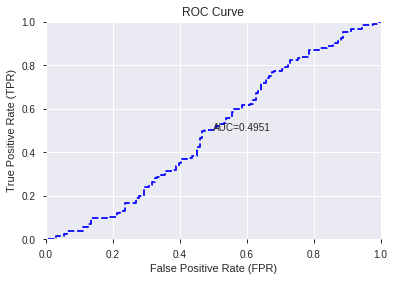

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


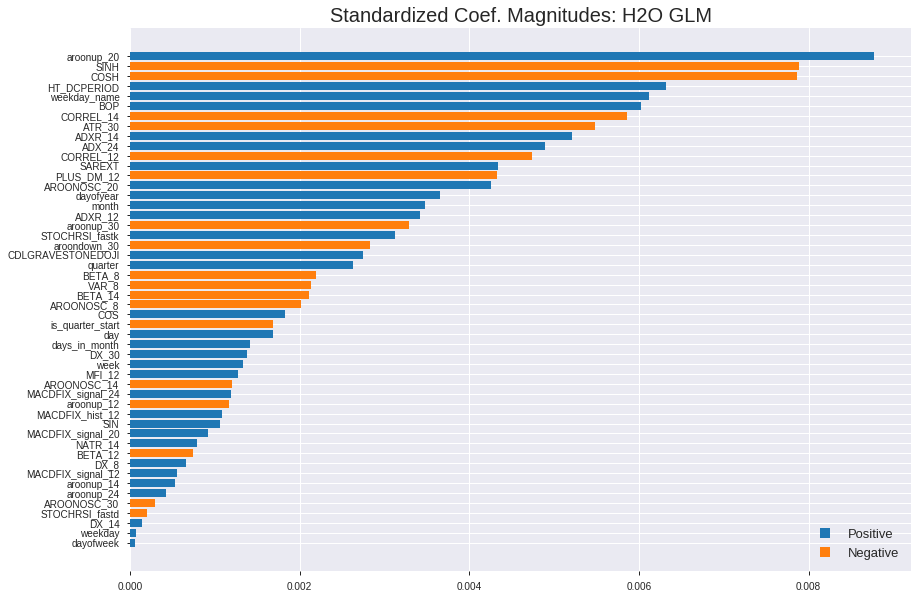

'log_likelihood'
--2019-08-26 20:11:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_201136_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_201136_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['aroonup_20',
 'SINH',
 'COSH',
 'HT_DCPERIOD',
 'weekday_name',
 'BOP',
 'CORREL_14',
 'ATR_30',
 'ADXR_14',
 'ADX_24',
 'CORREL_12',
 'SAREXT',
 'PLUS_DM_12',
 'AROONOSC_20',
 'dayofyear',
 'month',
 'ADXR_12',
 'aroonup_30',
 'STOCHRSI_fastk',
 'aroondown_30',
 'CDLGRAVESTONEDOJI',
 'quarter',
 'BETA_8',
 'VAR_8',
 'BETA_14',
 'AROONOSC_8',
 'COS',
 'is_quarter_start',
 'day',
 'days_in_month',
 'DX_30',
 'week',
 'MFI_12',
 'AROONOSC_14',
 'MACDFIX_signal_24',
 'aroonup_12',
 'MACDFIX_hist_12',
 'SIN',
 'MACDFIX_signal_20',
 'NATR_14',
 'BETA_12',
 'DX_8',
 'MACDFIX_signal_12',
 'aroonup_14',
 'aroonup_24',
 'AROONOSC_30',
 'STOCHRSI_fastd',
 'DX_14',
 'weekday',
 'dayofweek']

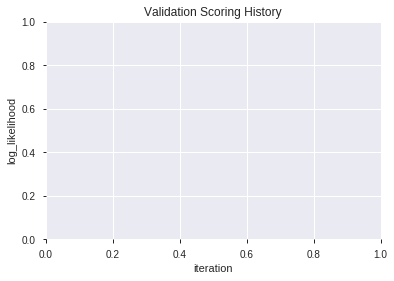

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_201146_model_4  0.513143  0.699153              0.500000  0.502938  0.252946
1               XGBoost_2_AutoML_20190826_201146  0.504825  0.711671              0.496032  0.508662  0.258738
2  XGBoost_grid_1_AutoML_20190826_201146_model_3  0.501524  0.708570              0.484127  0.507150  0.257202
3  XGBoost_grid_1_AutoML_20190826_201146_model_1  0.499683  0.702652              0.488095  0.504626  0.254647
4               XGBoost_3_AutoML_20190826_201146  0.490730  0.707625              0.480159  0.506927  0.256975
5  XGBoost_grid_1_AutoML_20190826_201146_model_7  0.489968  0.724486              0.496032  0.514274  0.264478
6               XGBoost_1_AutoML_20190826_201146  0.487175  0.714987              0.480159  0.510183  0.260287
7  XGBoost_grid_1_AutoML_20190826_201146_model_6  0.469079  0.710778              0.492095  0.508556  0.258629
8  XGBoost_grid_1_AutoML_20190826_201146_model_5  0.451175  0.758756              0.500000  0.529272  0.280129
9  XGBoost_grid_1_AutoML_20190826_201146_model_2  0.449778  0.711202              0.488095  0.508757  0.258833

variable  relative_importance  scaled_importance  percentage
0              ATR_30           121.038292           1.000000    0.044856
1                 BOP           118.269737           0.977127    0.043830
2             BETA_14           117.242004           0.968636    0.043449
3           dayofyear           115.848717           0.957125    0.042932
4              SAREXT           113.929863           0.941271    0.042221
5              BETA_8           108.360115           0.895255    0.040157
6      STOCHRSI_fastd           107.595062           0.888934    0.039874
7          aroonup_20            99.985443           0.826065    0.037054
8          PLUS_DM_12            88.934517           0.734763    0.032958
9              ADX_24            86.848763           0.717531    0.032185
10        HT_DCPERIOD            85.188774           0.703817    0.031570
11                COS            80.462227           0.664767    0.029818
12       aroondown_30            80.122871           0.661963    0.029693
13          CORREL_12            79.006737           0.652742    0.029279
14            ADXR_14            77.854691           0.643224    0.028852
15          CORREL_14            77.374817           0.639259    0.028674
16               COSH            73.243004           0.605123    0.027143
17         aroonup_24            71.690063           0.592292    0.026568
18            BETA_12            68.858727           0.568900    0.025518
19                SIN            65.740387           0.543137    0.024363
20        AROONOSC_30            60.424782           0.499220    0.022393
21             MFI_12            60.393139           0.498959    0.022381
22         aroonup_30            57.766403           0.477257    0.021408
23        AROONOSC_14            55.567848           0.459093    0.020593
24                day            51.925007           0.428997    0.019243
25              VAR_8            50.446735           0.416783    0.018695
26            ADXR_12            50.399925           0.416397    0.018678
27  MACDFIX_signal_24            49.430813           0.408390    0.018319
28        AROONOSC_20            49.038177           0.405146    0.018173
29               DX_8            48.391037           0.399799    0.017933
30    MACDFIX_hist_12            47.782639           0.394773    0.017708
31              DX_14            44.643406           0.368837    0.016544
32              DX_30            43.906761           0.362751    0.016271
33            NATR_14            30.293850           0.250283    0.011227
34  MACDFIX_signal_12            24.220093           0.200103    0.008976
35         AROONOSC_8            22.120295           0.182755    0.008198
36         aroonup_12            21.678436           0.179104    0.008034
37          dayofweek            21.537676           0.177941    0.007982
38     STOCHRSI_fastk            18.354963           0.151646    0.006802
39       weekday_name            16.242214           0.134191    0.006019
40  MACDFIX_signal_20            13.715343           0.113314    0.005083
41               week            12.821875           0.105932    0.004752
42      days_in_month             9.706295           0.080192    0.003597

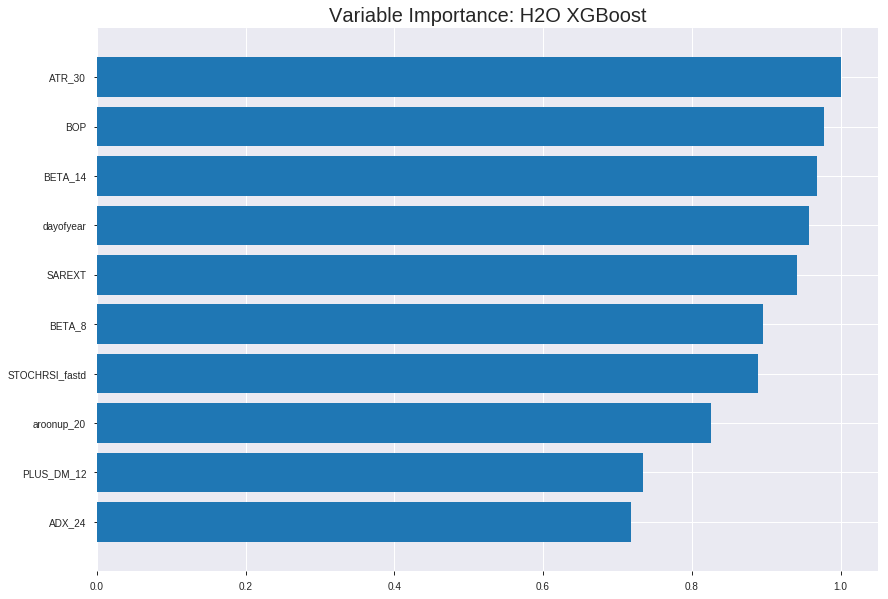

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_201146_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22130028085318285
RMSE: 0.4704256379633054
LogLoss: 0.6350089219524737
Mean Per-Class Error: 0.27631952419268735
AUC: 0.7959017866210442
pr_auc: 0.7961541841066629
Gini: 0.5918035732420883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4750093281269073: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      436  426   0.4942   (426.0/862.0)
1      96   795   0.1077   (96.0/891.0)
Total  532  1221  0.2978   (522.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475009     0.752841  256
max f2                       0.420903     0.852405  333
max f0point5                 0.521449     0.737272  174
max accuracy                 0.511004     0.723331  194
max precision                0.68192      1         0
max recall                   0.347236     1         394
max specificity              0.68192      1         0
max absolute_mcc             0.511004     0.447571  194
max min_per_class_accuracy   0.507949     0.720539  199
max mean_per_class_accuracy  0.511004     0.72368   194

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.650343           1.96745   1.96745            1                0.663496  1                           0.663496            0.020202        0.020202                   96.7452   96.7452
    2        0.0205362                   0.638189           1.85815   1.9128             0.944444         0.643294  0.972222                    0.653395            0.0190797       0.0392817                  85.8149   91.2801
    3        0.0302339                   0.627528           1.62025   1.81897            0.823529         0.632279  0.924528                    0.646622            0.0157127       0.0549944                  62.0255   81.8965
    4        0.040502                    0.621084           1.85815   1.8289             0.944444         0.62483   0.929577                    0.641097            0.0190797       0.0740741                  85.8149   82.8899
    5        0.0501997                   0.615967           1.85172   1.83331            0.941176         0.619011  0.931818                    0.636831            0.0179574       0.0920314                  85.172    83.3308
    6        0.100399                    0.594128           1.81095   1.82213            0.920455         0.604317  0.926136                    0.620574            0.0909091       0.182941                   81.095    82.2129
    7        0.150029                    0.576701           1.65085   1.76547            0.83908          0.584691  0.897338                    0.608704            0.0819304       0.264871                   65.0851   76.5471
    8        0.200228                    0.564085           1.47559   1.69279            0.75             0.570332  0.860399                    0.599083            0.0740741       0.338945                   47.5589   69.2794
    9        0.300057                    0.542421           1.38284   1.58967            0.702857         0.552448  0.807985                    0.583568            0.138047        0.476992                   38.2838   58.9672
    10       0.399886                    0.523419           1.31538   1.5212             0.668571         0.533626  0.773181                    0.5711              0.131313        0.608305                   31.5382   52.1197
    11       0.500285                    0.508227           1.07316   1.43128            0.545455         0.515778  0.72748                     0.559998            0.107744        0.716049                   7.31558   43.1282
    12       0.600114                    0.49064            0.944377  1.35029            0.48             0.499704  0.686312                    0.549968            0.0942761       0.810325                   -5.56229  35.0286
    13       0.699943                    0.473963           0.843194  1.27796            0.428571         0.482597  0.649552                    0.540359            0.0841751       0.894501                   -15.6806  27.7962
    14       0.799772                    0.452263           0.449703  1.17458            0.228571         0.463134  0.597004                    0.53072             0.0448934       0.939394                   -55.0297  17.4577
    15       0.899601                    0.423783           0.404733  1.08915            0.205714         0.439315  0.553583                    0.520577            0.040404        0.979798                   -59.5267  8.91477
    16       1                           0.30383            0.201217  1                  0.102273         0.393894  0.508272                    0.507858         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2517208433663072
RMSE: 0.5017178922126528
LogLoss: 0.6967329985933061
Mean Per-Class Error: 0.46887738595923656
AUC: 0.5024425752183759
pr_auc: 0.5479066227461347
Gini: 0.004885150436751751
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37718719244003296: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    220  1        (220.0/220.0)
1      0    281  0        (0.0/281.0)
Total  0    501  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.377187     0.71867    399
max f2                       0.377187     0.864615   399
max f0point5                 0.377187     0.61488    399
max accuracy                 0.377187     0.560878   399
max precision                0.667749     1          0
max recall                   0.377187     1          399
max specificity              0.667749     1          0
max absolute_mcc             0.628902     0.0718252  11
max min_per_class_accuracy   0.517592     0.512456   198
max mean_per_class_accuracy  0.522724     0.531123   182

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.640581           0.891459  0.891459           0.5              0.647576  0.5                         0.647576            0.0106762       0.0106762                  -10.8541   -10.8541
    2        0.0219561                   0.629086           0.356584  0.648334           0.2              0.635043  0.363636                    0.641879            0.00355872      0.0142349                  -64.3416   -35.1666
    3        0.0319361                   0.616708           1.06975   0.780027           0.6              0.621954  0.4375                      0.635652            0.0106762       0.024911                   6.97509    -21.9973
    4        0.0419162                   0.612042           1.06975   0.849009           0.6              0.613795  0.47619                     0.630448            0.0106762       0.0355872                  6.97509    -15.0991
    5        0.0518962                   0.607789           0.713167  0.822885           0.4              0.609601  0.461538                    0.626439            0.00711744      0.0427046                  -28.6833   -17.7115
    6        0.101796                    0.588642           0.998434  0.908939           0.56             0.597883  0.509804                    0.612441            0.0498221       0.0925267                  -0.156584  -9.10613
    7        0.151697                    0.570872           0.927117  0.914919           0.52             0.578268  0.513158                    0.6012              0.0462633       0.13879                    -7.28826   -8.50815
    8        0.201597                    0.558131           0.855801  0.900285           0.48             0.562961  0.50495                     0.591735            0.0427046       0.181495                   -14.4199   -9.97146
    9        0.301397                    0.542298           1.10541   0.968207           0.62             0.54948   0.543046                    0.577743            0.11032         0.291815                   10.5409    -3.17928
    10       0.401198                    0.52895            1.17673   1.02008            0.66             0.535304  0.572139                    0.567186            0.117438        0.409253                   17.6726    2.00775
    11       0.500998                    0.517585           1.03409   1.02287            0.58             0.523223  0.573705                    0.558429            0.103203        0.512456                   3.40925    2.28694
    12       0.600798                    0.500228           0.891459  1.00104            0.5              0.507747  0.561462                    0.55001             0.088968        0.601423                   -10.8541   0.104042
    13       0.700599                    0.486204           1.17673   1.02607            0.66             0.493161  0.575499                    0.541912            0.117438        0.718861                   17.6726    2.60669
    14       0.800399                    0.470022           0.962776  1.01818            0.54             0.478177  0.571072                    0.533965            0.0960854       0.814947                   -3.72242   1.81752
    15       0.9002                      0.445272           0.820142  0.99622            0.46             0.458425  0.558758                    0.52559             0.0818505       0.896797                   -17.9858   -0.377966
    16       1                           0.377187           1.03409   1                  0.58             0.423224  0.560878        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:11:52  2.546 sec   0                  0.5              0.693147            0.5             0                  1                0.491728                         0.5                0.693147              0.5               0                    1                  0.439122
    2019-08-26 20:11:52  2.606 sec   5                  0.496954         0.687071            0.644354        0.634893           1.27884          0.469481                         0.499541           0.692228              0.513871          0.576607             1.52822            0.43513
    2019-08-26 20:11:52  2.648 sec   10                 0.493572         0.680353            0.682937        0.677645           1.53024          0.431261                         0.498966           0.691082              0.532538          0.582132             0.891459           0.437126
    2019-08-26 20:11:52  2.700 sec   15                 0.490287         0.673854            0.708555        0.7114             1.74885          0.412436                         0.499132           0.691416              0.516508          0.571351             0.594306           0.439122
    2019-08-26 20:11:52  2.755 sec   20                 0.487478         0.668313            0.723496        0.725178           1.96745          0.380491                         0.49899            0.691134              0.514631          0.574451             0.891459           0.439122
    2019-08-26 20:11:52  2.810 sec   25                 0.484435         0.662344            0.743528        0.74488            1.96745          0.332573                         0.499258           0.691667              0.512464          0.572615             1.18861            0.439122
    2019-08-26 20:11:52  2.866 sec   30                 0.481855         0.657272            0.749102        0.752813           1.85815          0.374216                         0.499724           0.692606              0.50406           0.567945             0.594306           0.439122
    2019-08-26 20:11:52  2.924 sec   35                 0.478945         0.651593            0.766805        0.768347           1.96745          0.322305                         0.500513           0.694209              0.499005          0.562563             1.18861            0.439122
    2019-08-26 20:11:53  2.989 sec   40                 0.475802         0.645476            0.78188         0.780213           1.96745          0.313748                         0.501082           0.69538               0.498674          0.553543             1.18861            0.439122
    2019-08-26 20:11:53  3.052 sec   45                 0.473422         0.640828            0.786218        0.782112           1.96745          0.30405                          0.502089           0.697441              0.496927          0.55174              1.18861            0.439122
    2019-08-26 20:11:53  3.133 sec   50                 0.470426         0.635009            0.795902        0.796154           1.96745          0.297775                         0.501718           0.696733              0.502443          0.547907             0.891459           0.439122

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ---------------------
ATR_30             121.03829193115234     1.0                  0.04485553617016874
BOP                118.26973724365234     0.9771266213086122   0.04382953850494323
BETA_14            117.24200439453125     0.9686356484708124   0.043448671365697376
dayofyear          115.84871673583984     0.9571245172704157   0.04293233340377843
SAREXT             113.92986297607422     0.9412712386992254   0.04222122609341264
---                ---                    ---                  ---
STOCHRSI_fastk     18.354963302612305     0.15164592138372848  0.006802159111686398
weekday_name       16.24221420288086      0.13419070893795804  0.006019196198467163
MACDFIX_signal_20  13.71534252166748      0.11331407856836652  0.005082763749812707
week               12.821874618530273     0.10593238233916479  0.00475165380760655
days_in_month      9.706295013427734      0.08019193644064938  0.0035970523055694212


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5298804780876494)

('F1', 0.6648936170212766)

('auc', 0.5131428571428572)

('logloss', 0.6991528782195638)

('mean_per_class_error', 0.4701587301587302)

('rmse', 0.5029375199182946)

('mse', 0.252946148941565)

xgboost prediction progress: |████████████████████████████████████████████| 100%


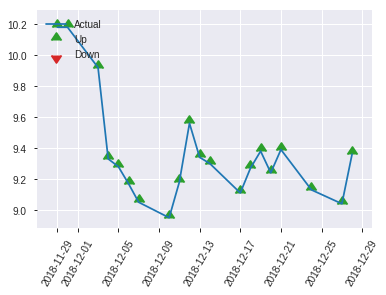


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.252946148941565
RMSE: 0.5029375199182946
LogLoss: 0.6991528782195638
Mean Per-Class Error: 0.4701587301587302
AUC: 0.5131428571428572
pr_auc: 0.5082360066019719
Gini: 0.026285714285714468
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40457162261009216: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    126  1        (126.0/126.0)
1      0    125  0        (0.0/125.0)
Total  0    251  0.502    (126.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.404572     0.664894   250
max f2                       0.404572     0.832224   250
max f0point5                 0.404572     0.553587   250
max accuracy                 0.53586      0.52988    122
max precision                0.63925      1          0
max recall                   0.404572     1          250
max specificity              0.63925      1          0
max absolute_mcc             0.639163     0.0899799  1
max min_per_class_accuracy   0.5343       0.52381    125
max mean_per_class_accuracy  0.53586      0.529841   122

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 53.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.631813           1.33867   1.33867            0.666667         0.637372  0.666667                    0.637372            0.016           0.016                      33.8667   33.8667
    2        0.0239044                   0.628451           0.669333  1.004              0.333333         0.628956  0.5                         0.633164            0.008           0.024                      -33.0667  0.4
    3        0.0318725                   0.620421           0         0.753              0                0.621251  0.375                       0.630186            0               0.024                      -100      -24.7
    4        0.0438247                   0.616713           2.008     1.09527            1                0.617872  0.545455                    0.626827            0.024           0.048                      100.8     9.52727
    5        0.0517928                   0.612299           0         0.926769           0                0.613437  0.461538                    0.624767            0               0.048                      -100      -7.32308
    6        0.103586                    0.603587           1.08123   1.004              0.538462         0.608243  0.5                         0.616505            0.056           0.104                      8.12308   0.4
    7        0.151394                    0.591991           1.004     1.004              0.5              0.597617  0.5                         0.61054             0.048           0.152                      0.4       0.4
    8        0.203187                    0.58444            1.08123   1.02369            0.538462         0.587824  0.509804                    0.60475             0.056           0.208                      8.12308   2.36863
    9        0.302789                    0.562413           1.2048    1.08326            0.6              0.573325  0.539474                    0.594413            0.12            0.328                      20.48     8.32632
    10       0.40239                     0.545802           0.72288   0.994059           0.36             0.554614  0.49505                     0.584562            0.072           0.4                        -27.712   -0.594059
    11       0.501992                    0.5343             1.28512   1.05181            0.64             0.540339  0.52381                     0.575787            0.128           0.528                      28.512    5.18095
    12       0.601594                    0.518464           0.96384   1.03725            0.48             0.525287  0.516556                    0.567426            0.096           0.624                      -3.616    3.7245
    13       0.701195                    0.502023           0.8032    1.004              0.4              0.51      0.5                         0.559269            0.08            0.704                      -19.68    0.4
    14       0.800797                    0.485282           0.96384   0.999005           0.48             0.493087  0.497512                    0.551037            0.096           0.8                        -3.616    -0.0995025
    15       0.900398                    0.46418            1.04416   1.004              0.52             0.473527  0.5                         0.542463            0.104           0.904                      4.416     0.4
    16       1                           0.404572           0.96384   1                  0.48             0.437072  0.498008                    0.531966            0.096         

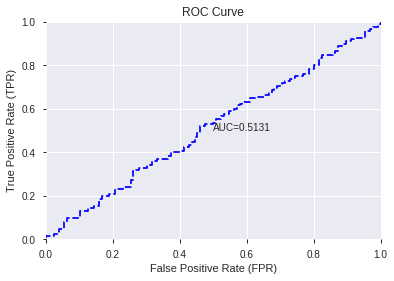

This function is available for GLM models only


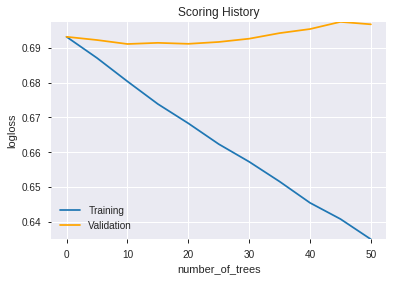

--2019-08-26 20:12:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.120.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.120.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_201146_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_201146_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ATR_30',
 'BOP',
 'BETA_14',
 'dayofyear',
 'SAREXT',
 'BETA_8',
 'STOCHRSI_fastd',
 'aroonup_20',
 'PLUS_DM_12',
 'ADX_24',
 'HT_DCPERIOD',
 'COS',
 'aroondown_30',
 'CORREL_12',
 'ADXR_14',
 'CORREL_14',
 'COSH',
 'aroonup_24',
 'BETA_12',
 'SIN',
 'AROONOSC_30',
 'MFI_12',
 'aroonup_30',
 'AROONOSC_14',
 'day',
 'VAR_8',
 'ADXR_12',
 'MACDFIX_signal_24',
 'AROONOSC_20',
 'DX_8',
 'MACDFIX_hist_12',
 'DX_14',
 'DX_30',
 'NATR_14',
 'MACDFIX_signal_12',
 'AROONOSC_8',
 'aroonup_12',
 'dayofweek',
 'STOCHRSI_fastk',
 'weekday_name',
 'MACDFIX_signal_20',
 'week',
 'days_in_month']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_201207_model_1  0.537968  0.690862              0.460413  0.498857  0.248859

variable  relative_importance  scaled_importance    percentage
0                   CDL3INSIDE         8.818429e-03           1.000000  1.539900e-02
1                  CDL3OUTSIDE         7.491794e-03           0.849561  1.308239e-02
2               CDLMORNINGSTAR         7.052002e-03           0.799689  1.231441e-02
3          CDLXSIDEGAP3METHODS         6.514045e-03           0.738685  1.137502e-02
4              CDLLADDERBOTTOM         6.446665e-03           0.731045  1.125736e-02
...                        ...                  ...                ...           ...
1035  BBANDS_middleband_14_5_3         2.239225e-06           0.000254  3.910200e-06
1036                   MA_20_3         2.221849e-06           0.000252  3.879857e-06
1037   BBANDS_lowerband_14_5_2         1.865141e-06           0.000212  3.256964e-06
1038   BBANDS_upperband_14_5_4         3.278868e-07           0.000037  5.725655e-07
1039  BBANDS_middleband_12_6_5         5.747812e-08           0.000007  1.003700e-07

[1040 rows x 4 columns]

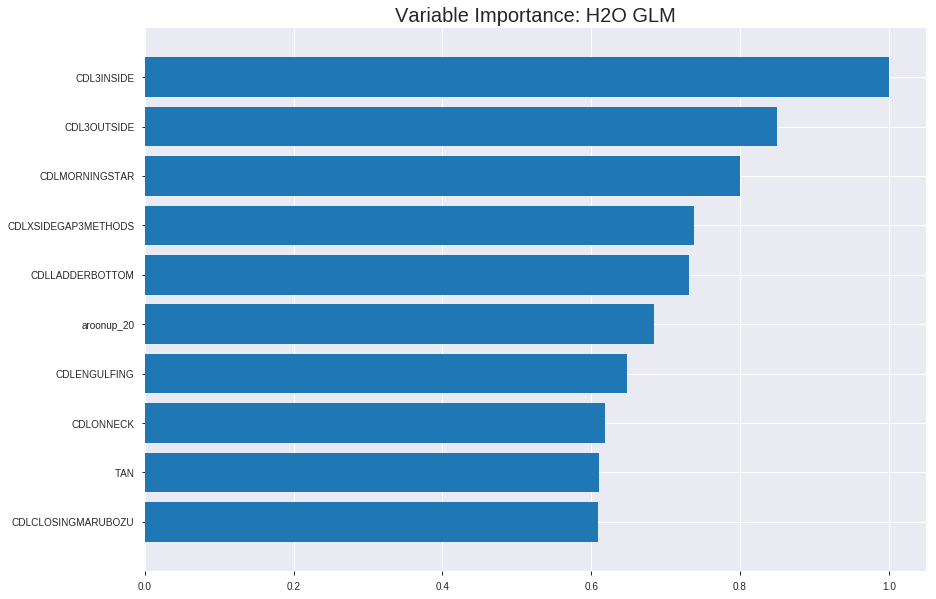

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_201207_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2476532825373303
RMSE: 0.4976477494547024
LogLoss: 0.6884436772919229
Null degrees of freedom: 1752
Residual degrees of freedom: 712
Null deviance: 2429.694244156657
Residual deviance: 2413.6835325854818
AIC: 4495.683532585482
AUC: 0.5693692532439633
pr_auc: 0.570190195389539
Gini: 0.13873850648792652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4703684928400702: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   823   0.9548   (823.0/862.0)
1      14   877   0.0157   (14.0/891.0)
Total  53   1700  0.4775   (837.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470368     0.676959  364
max f2                       0.453498     0.839616  389
max f0point5                 0.48805      0.57735   296
max accuracy                 0.508658     0.549914  192
max precision                0.580101     1         0
max recall                   0.453498     1         389
max specificity              0.580101     1         0
max absolute_mcc             0.48805      0.107543  296
max min_per_class_accuracy   0.510912     0.54321   182
max mean_per_class_accuracy  0.515115     0.55075   159

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.551286           1.53024   1.53024            0.777778         0.556767  0.777778                    0.556767            0.0157127       0.0157127                  53.0241    53.0241
    2        0.0205362                   0.546329           1.31163   1.42094            0.666667         0.548972  0.722222                    0.55287             0.013468        0.0291807                  31.1635    42.0938
    3        0.0302339                   0.543545           1.04159   1.29926            0.529412         0.544667  0.660377                    0.550239            0.010101        0.0392817                  4.15924    29.9261
    4        0.040502                    0.541331           0.874423  1.19156            0.444444         0.542435  0.605634                    0.54826             0.00897868      0.0482604                  -12.5577   19.1556
    5        0.0501997                   0.539722           0.92586   1.14023            0.470588         0.540566  0.579545                    0.546774            0.00897868      0.0572391                  -7.41401   14.0228
    6        0.100399                    0.533846           1.31909   1.22966            0.670455         0.536533  0.625                       0.541654            0.0662177       0.123457                   31.9087    22.9658
    7        0.150029                    0.529298           1.10811   1.18945            0.563218         0.53167   0.604563                    0.538351            0.0549944       0.178451                   10.8105    18.9448
    8        0.200228                    0.5259             1.09551   1.1659             0.556818         0.527481  0.592593                    0.535626            0.0549944       0.233446                   9.55132    16.5898
    9        0.300057                    0.520597           1.10177   1.14456            0.56             0.523024  0.581749                    0.531433            0.109989        0.343434                   10.1773    14.4564
    10       0.399886                    0.515758           1.03432   1.11704            0.525714         0.518051  0.56776                     0.528092            0.103255        0.446689                   3.43178    11.7041
    11       0.500285                    0.510756           0.961369  1.0858             0.488636         0.513338  0.551881                    0.525131            0.0965208       0.54321                    -3.86313   8.58004
    12       0.600114                    0.502442           0.978105  1.06789            0.497143         0.506601  0.542776                    0.522049            0.0976431       0.640853                   -2.18951   6.78852
    13       0.699943                    0.496403           1.00059   1.05829            0.508571         0.499157  0.537897                    0.518784            0.0998878       0.740741                   0.0590027  5.82873
    14       0.799772                    0.490251           0.966862  1.04688            0.491429         0.493386  0.532097                    0.515614            0.0965208       0.837262                   -3.31377   4.68755
    15       0.899601                    0.481696           0.888164  1.02926            0.451429         0.486573  0.523145                    0.512391            0.0886644       0.925926                   -11.1836   2.92633
    16       1                           0.425392           0.737795  1                  0.375            0.47136   0.508272                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25020660989601395
RMSE: 0.5002065672259951
LogLoss: 0.6935653418254446
Null degrees of freedom: 500
Residual degrees of freedom: -540
Null deviance: 692.6521653604563
Residual deviance: 694.9524725090955
AIC: 2776.9524725090955
AUC: 0.45993206082174054
pr_auc: 0.5219636131374688
Gini: -0.08013587835651892
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4591338436273881: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    220  1        (220.0/220.0)
1      0    281  0        (0.0/281.0)
Total  0    501  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459134     0.71867   399
max f2                       0.459134     0.864615  399
max f0point5                 0.459134     0.61488   399
max accuracy                 0.478947     0.560878  362
max precision                0.485799     0.566038  328
max recall                   0.459134     1         399
max specificity              0.56146      0.995455  0
max absolute_mcc             0.533032     0.113956  70
max min_per_class_accuracy   0.517658     0.476868  188
max mean_per_class_accuracy  0.478947     0.509374  362

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.552595           0.594306  0.594306           0.333333         0.556748  0.333333                    0.556748            0.00711744      0.00711744                 -40.5694   -40.5694
    2        0.0219561                   0.551271           0.713167  0.648334           0.4              0.551831  0.363636                    0.554513            0.00711744      0.0142349                  -28.6833   -35.1666
    3        0.0319361                   0.548505           0.713167  0.668594           0.4              0.549865  0.375                       0.55306             0.00711744      0.0213523                  -28.6833   -33.1406
    4        0.0419162                   0.546481           1.06975   0.764108           0.6              0.547402  0.428571                    0.551713            0.0106762       0.0320285                  6.97509    -23.5892
    5        0.0518962                   0.544119           1.06975   0.822885           0.6              0.545016  0.461538                    0.550425            0.0106762       0.0427046                  6.97509    -17.7115
    6        0.101796                    0.537087           0.927117  0.873979           0.52             0.540184  0.490196                    0.545405            0.0462633       0.088968                   -7.28826   -12.6021
    7        0.151697                    0.533969           0.641851  0.797621           0.36             0.535326  0.447368                    0.542089            0.0320285       0.120996                   -35.8149   -20.2379
    8        0.201597                    0.531057           1.06975   0.86498            0.6              0.532385  0.485149                    0.539687            0.0533808       0.174377                   6.97509    -13.502
    9        0.301397                    0.527297           0.998434  0.90917            0.56             0.529144  0.509934                    0.536196            0.0996441       0.274021                   -0.156584  -9.08298
    10       0.401198                    0.522729           0.998434  0.931375           0.56             0.525119  0.522388                    0.533441            0.0996441       0.373665                   -0.156584  -6.86248
    11       0.500998                    0.517019           1.06975   0.95894            0.6              0.519725  0.537849                    0.530709            0.106762        0.480427                   6.97509    -4.106
    12       0.600798                    0.511647           0.927117  0.953654           0.52             0.514365  0.534884                    0.527994            0.0925267       0.572954                   -7.28826   -4.63461
    13       0.700599                    0.505746           1.14107   0.980351           0.64             0.508694  0.549858                    0.525244            0.113879        0.686833                   14.1068    -1.9649
    14       0.800399                    0.493176           1.03409   0.987052           0.58             0.500733  0.553616                    0.522188            0.103203        0.790036                   3.40925    -1.29481
    15       0.9002                      0.481125           1.10541   1.00017            0.62             0.486135  0.560976                    0.518191            0.11032         0.900356                   10.5409    0.0173596
    16       1                           0.459134           0.998434  1                  0.56             0.474269  0.560878        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 20:12:11  0.000 sec   2            2.9       1041          1.37689           1.38713
    2019-08-26 20:12:13  2.156 sec   4            2.1       1041          1.3745            1.38774
    2019-08-26 20:12:15  4.289 sec   6            1.5       1041          1.37159           1.38868
    2019-08-26 20:12:17  6.492 sec   8            1.1       1041          1.3681            1.38999
    2019-08-26 20:12:19  8.602 sec   10           0.81      1041          1.36406           1.39178

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.6777777777777777)

('auc', 0.537968253968254)

('logloss', 0.6908622264821165)

('mean_per_class_error', 0.4526031746031747)

('rmse', 0.49885727856003703)

('mse', 0.24885858437232639)

glm prediction progress: |████████████████████████████████████████████████| 100%


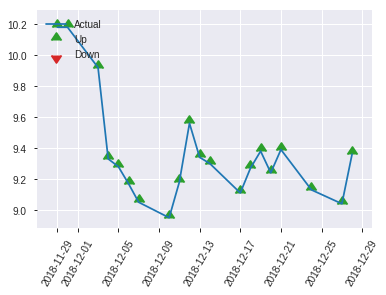


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24885858437232639
RMSE: 0.49885727856003703
LogLoss: 0.6908622264821165
Null degrees of freedom: 250
Residual degrees of freedom: -790
Null deviance: 348.0616751555067
Residual deviance: 346.81283769402245
AIC: 2428.8128376940226
AUC: 0.537968253968254
pr_auc: 0.5178667468416044
Gini: 0.07593650793650797
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4751251697049259: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   113  0.8968   (113.0/126.0)
1      3    122  0.024    (3.0/125.0)
Total  16   235  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475125     0.677778  234
max f2                       0.454375     0.833333  249
max f0point5                 0.477484     0.57561   224
max accuracy                 0.483893     0.545817  216
max precision                0.52483      0.6875    15
max recall                   0.454375     1         249
max specificity              0.541851     0.992063  0
max absolute_mcc             0.475125     0.162044  234
max min_per_class_accuracy   0.506834     0.507937  125
max mean_per_class_accuracy  0.477484     0.547397  224

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.538371           0         0                  0                0.540611  0                           0.540611            0               0                          -100      -100
    2        0.0239044                   0.532434           2.008     1.004              1                0.534347  0.5                         0.537479            0.024           0.024                      100.8     0.4
    3        0.0318725                   0.528221           0         0.753              0                0.528576  0.375                       0.535253            0               0.024                      -100      -24.7
    4        0.0438247                   0.527224           2.008     1.09527            1                0.527665  0.545455                    0.533184            0.024           0.048                      100.8     9.52727
    5        0.0517928                   0.525545           2.008     1.23569            1                0.526013  0.615385                    0.532081            0.016           0.064                      100.8     23.5692
    6        0.103586                    0.518917           1.23569   1.23569            0.615385         0.521801  0.615385                    0.526941            0.064           0.128                      23.5692   23.5692
    7        0.151394                    0.516968           0.502     1.004              0.25             0.517754  0.5                         0.52404             0.024           0.152                      -49.8     0.4
    8        0.203187                    0.514891           0.926769  0.984314           0.461538         0.515959  0.490196                    0.52198             0.048           0.2                        -7.32308  -1.56863
    9        0.302789                    0.51158            1.28512   1.08326            0.64             0.513401  0.539474                    0.519158            0.128           0.328                      28.512    8.32632
    10       0.40239                     0.50901            1.04416   1.07358            0.52             0.51011   0.534653                    0.516918            0.104           0.432                      4.416     7.35842
    11       0.501992                    0.506834           0.8032    1.01994            0.4              0.507979  0.507937                    0.515145            0.08            0.512                      -19.68    1.99365
    12       0.601594                    0.50366            1.04416   1.02395            0.52             0.505369  0.509934                    0.513526            0.104           0.616                      4.416     2.3947
    13       0.701195                    0.499407           1.12448   1.03823            0.56             0.50147   0.517045                    0.511814            0.112           0.728                      12.448    3.82273
    14       0.800797                    0.494711           0.96384   1.02898            0.48             0.49702   0.512438                    0.509974            0.096           0.824                      -3.616    2.89751
    15       0.900398                    0.476935           1.2048    1.04842            0.6              0.486265  0.522124                    0.507351            0.12            0.944                      20.48     4.84248
    16       1                           0.449698           0.56224   1                  0.28             0.471691  0.498008                    0.503799            0.056     

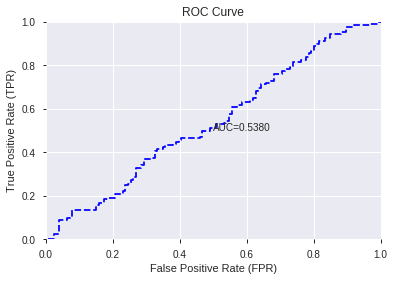

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


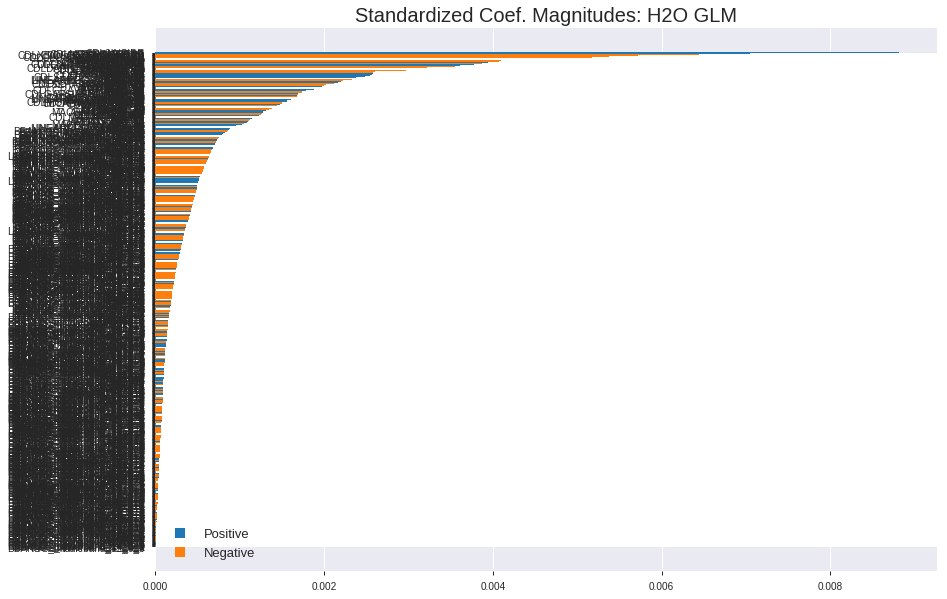

'log_likelihood'
--2019-08-26 20:12:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_201207_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_201207_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

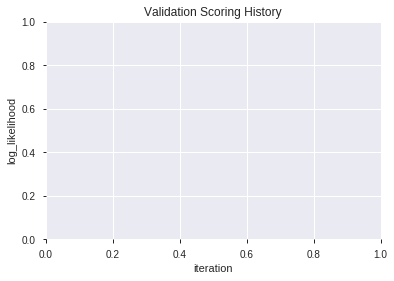

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_201244_model_6  0.536000  0.697776              0.436730  0.502153  0.252157
1  XGBoost_grid_1_AutoML_20190826_201244_model_4  0.534159  0.699960              0.496032  0.503224  0.253234
2               XGBoost_2_AutoML_20190826_201244  0.516444  0.716374              0.492063  0.510603  0.260715
3  XGBoost_grid_1_AutoML_20190826_201244_model_2  0.510286  0.705933              0.492063  0.506003  0.256040
4  XGBoost_grid_1_AutoML_20190826_201244_model_7  0.509651  0.714513              0.480190  0.509794  0.259890
5  XGBoost_grid_1_AutoML_20190826_201244_model_5  0.500127  0.747140              0.468349  0.521924  0.272405
6  XGBoost_grid_1_AutoML_20190826_201244_model_3  0.494730  0.702535              0.444444  0.504457  0.254476
7               XGBoost_3_AutoML_20190826_201244  0.481651  0.712851              0.480159  0.509156  0.259240
8  XGBoost_grid_1_AutoML_20190826_201244_model_1  0.480635  0.707906              0.468286  0.507052  0.257102
9               XGBoost_1_AutoML_20190826_201244  0.468952  0.724548              0.484159  0.514835  0.265055

variable  relative_importance  scaled_importance  percentage
0       HT_PHASOR_quadrature           143.051682           1.000000    0.019993
1                     BETA_8           134.789047           0.942240    0.018838
2                        BOP           112.992813           0.789874    0.015792
3                      ADOSC           112.482758           0.786309    0.015721
4                HT_DCPERIOD            95.131042           0.665012    0.013296
..                       ...                  ...                ...         ...
348  BBANDS_lowerband_20_3_5             3.281504           0.022939    0.000459
349  BBANDS_lowerband_12_5_2             3.197632           0.022353    0.000447
350  BBANDS_upperband_14_0_3             3.048443           0.021310    0.000426
351               PLUS_DM_24             2.480300           0.017338    0.000347
352  BBANDS_upperband_12_7_2             2.128310           0.014878    0.000297

[353 rows x 4 columns]

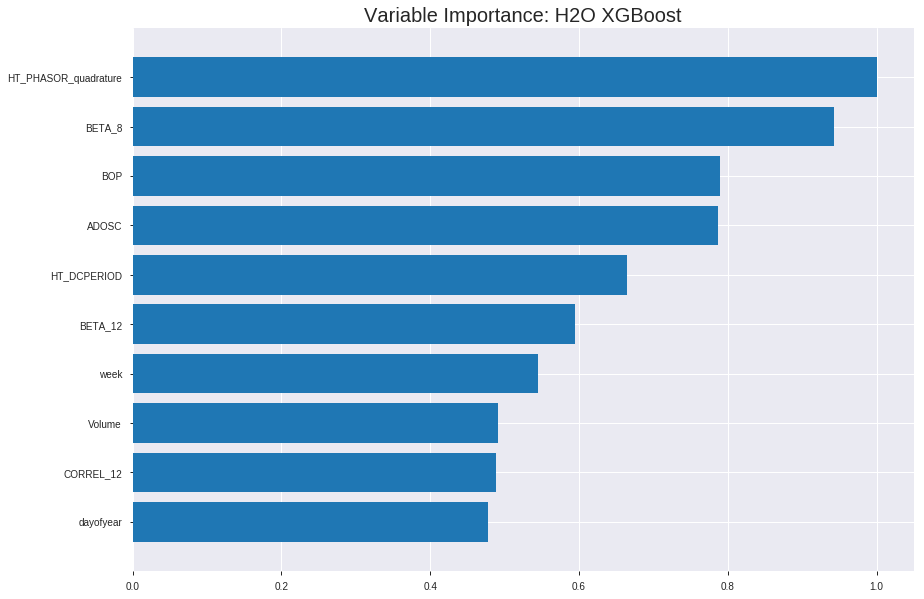

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_201244_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17767771275937005
RMSE: 0.42151834213871414
LogLoss: 0.5446274421769337
Mean Per-Class Error: 0.11762052075277141
AUC: 0.9507559482424138
pr_auc: 0.9521337820403234
Gini: 0.9015118964848277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5032461643218994: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      755  107  0.1241   (107.0/862.0)
1      99   792  0.1111   (99.0/891.0)
Total  854  899  0.1175   (206.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503246     0.884916  197
max f2                       0.451914     0.922865  249
max f0point5                 0.550977     0.894095  148
max accuracy                 0.503246     0.882487  197
max precision                0.746026     1         0
max recall                   0.37569      1         323
max specificity              0.746026     1         0
max absolute_mcc             0.503246     0.764906  197
max min_per_class_accuracy   0.505982     0.881671  195
max mean_per_class_accuracy  0.503246     0.882379  197

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.718568           1.96745    1.96745            1                0.730623  1                           0.730623            0.020202        0.020202                   96.7452   96.7452
    2        0.0205362                   0.710504           1.96745    1.96745            1                0.713803  1                           0.722213            0.020202        0.040404                   96.7452   96.7452
    3        0.0302339                   0.700996           1.96745    1.96745            1                0.706234  1                           0.717088            0.0190797       0.0594837                  96.7452   96.7452
    4        0.040502                    0.692365           1.96745    1.96745            1                0.696763  1                           0.711935            0.020202        0.0796857                  96.7452   96.7452
    5        0.0501997                   0.683765           1.96745    1.96745            1                0.687818  1                           0.707276            0.0190797       0.0987654                  96.7452   96.7452
    6        0.100399                    0.650498           1.96745    1.96745            1                0.666462  1                           0.686869            0.0987654       0.197531                   96.7452   96.7452
    7        0.150029                    0.630274           1.96745    1.96745            1                0.64073   1                           0.671606            0.0976431       0.295174                   96.7452   96.7452
    8        0.200228                    0.613329           1.94509    1.96185            0.988636         0.621387  0.997151                    0.659016            0.0976431       0.392817                   94.5095   96.1847
    9        0.300057                    0.57876            1.79881    1.90761            0.914286         0.595411  0.969582                    0.637854            0.179574        0.572391                   79.8814   90.7606
    10       0.399886                    0.547929           1.6639     1.84677            0.845714         0.563883  0.938659                    0.619388            0.166105        0.738496                   66.3903   84.6767
    11       0.500285                    0.508067           1.33027    1.74311            0.676136         0.52935   0.885975                    0.601319            0.133558        0.872054                   33.0266   74.3113
    12       0.600114                    0.470193           0.742011   1.57658            0.377143         0.488894  0.801331                    0.582617            0.0740741       0.946128                   -25.7989  57.658
    13       0.699943                    0.436634           0.382248   1.40624            0.194286         0.4538    0.714751                    0.564244            0.0381594       0.984287                   -61.7752  40.6239
    14       0.799772                    0.404597           0.123668   1.24615            0.0628571        0.420971  0.633381                    0.546361            0.0123457       0.996633                   -87.6332  24.6147
    15       0.899601                    0.364433           0.0337278  1.1116             0.0171429        0.386258  0.564997                    0.528594            0.003367        1                          -96.6272  11.1604
    16       1                           0.247954           0          1                  0                0.322164  0.508272                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2557182114792358
RMSE: 0.5056858822225867
LogLoss: 0.7049330757539672
Mean Per-Class Error: 0.48147039792947266
AUC: 0.4950258815917179
pr_auc: 0.5615023715875737
Gini: -0.009948236816564204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27236756682395935: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    219  0.9955   (219.0/220.0)
1      0    281  0        (0.0/281.0)
Total  1    500  0.4371   (219.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.272368     0.71959    398
max f2                       0.272368     0.865148   398
max f0point5                 0.272368     0.615958   398
max accuracy                 0.341043     0.562874   392
max precision                0.651587     0.636364   9
max recall                   0.272368     1          398
max specificity              0.686611     0.995455   0
max absolute_mcc             0.360426     0.0692156  384
max min_per_class_accuracy   0.508495     0.477273   200
max mean_per_class_accuracy  0.562486     0.51853    105

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 50.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.659726           0.891459  0.891459           0.5              0.671399  0.5                         0.671399            0.0106762       0.0106762                  -10.8541   -10.8541
    2        0.0219561                   0.651587           1.42633   1.13458            0.8              0.653409  0.636364                    0.663221            0.0142349       0.024911                   42.6335    13.4584
    3        0.0319361                   0.638495           0.356584  0.891459           0.2              0.642714  0.5                         0.656813            0.00355872      0.0284698                  -64.3416   -10.8541
    4        0.0419162                   0.631883           1.78292   1.10371            1                0.633348  0.619048                    0.651226            0.0177936       0.0462633                  78.2918    10.3711
    5        0.0518962                   0.625871           0.356584  0.960033           0.2              0.628884  0.538462                    0.646929            0.00355872      0.0498221                  -64.3416   -3.99672
    6        0.101796                    0.601719           1.14107   1.04878            0.64             0.613159  0.588235                    0.630375            0.0569395       0.106762                   14.1068    4.87754
    7        0.151697                    0.586319           1.06975   1.05568            0.6              0.592921  0.592105                    0.618055            0.0533808       0.160142                   6.97509    5.56752
    8        0.201597                    0.570794           0.927117  1.02385            0.52             0.577205  0.574257                    0.607943            0.0462633       0.206406                   -7.28826   2.3854
    9        0.301397                    0.547444           0.998434  1.01544            0.56             0.559731  0.569536                    0.591979            0.0996441       0.30605                    -0.156584  1.54368
    10       0.401198                    0.530285           0.891459  0.984597           0.5              0.537672  0.552239                    0.57847             0.088968        0.395018                   -10.8541   -1.54034
    11       0.500998                    0.508334           0.891459  0.966043           0.5              0.518702  0.541833                    0.566564            0.088968        0.483986                   -10.8541   -3.39567
    12       0.600798                    0.487322           0.962776  0.965501           0.54             0.496693  0.541528                    0.554957            0.0960854       0.580071                   -3.72242   -3.44995
    13       0.700599                    0.464773           1.14107   0.99051            0.64             0.47656   0.555556                    0.54379             0.113879        0.69395                    14.1068    -0.948992
    14       0.800399                    0.438808           1.14107   1.00928            0.64             0.451835  0.566085                    0.532324            0.113879        0.807829                   14.1068    0.928284
    15       0.9002                      0.395589           0.962776  1.00413            0.54             0.418896  0.563193                    0.519749            0.0960854       0.903915                   -3.72242   0.412685
    16       1                           0.233943           0.962776  1                  0.54             0.365385  0.560878           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:13:22  23.558 sec  0                  0.5              0.693147            0.5             0                  1                0.491728                         0.5                0.693147              0.5               0                    1                  0.439122
    2019-08-26 20:13:23  24.172 sec  5                  0.489624         0.672571            0.766735        0.774019           1.96745          0.318311                         0.500855           0.694857              0.469945          0.542875             1.42633            0.433134
    2019-08-26 20:13:23  24.367 sec  10                 0.479062         0.651949            0.828906        0.840066           1.96745          0.261266                         0.501567           0.696302              0.492891          0.559696             0.891459           0.43513
    2019-08-26 20:13:23  24.601 sec  15                 0.470373         0.635226            0.866265        0.873233           1.96745          0.241871                         0.50142            0.696018              0.496732          0.553673             0.891459           0.433134
    2019-08-26 20:13:23  24.807 sec  20                 0.462499         0.620258            0.891348        0.89969            1.96745          0.20308                          0.502716           0.698657              0.496546          0.559068             0.891459           0.433134
    2019-08-26 20:13:24  25.008 sec  25                 0.454854         0.605876            0.913647        0.919223           1.96745          0.171706                         0.503142           0.699543              0.492155          0.559155             1.18861            0.437126
    2019-08-26 20:13:24  25.221 sec  30                 0.448821         0.594568            0.918176        0.921776           1.96745          0.166001                         0.502993           0.699255              0.493028          0.557318             0.891459           0.437126
    2019-08-26 20:13:24  25.443 sec  35                 0.442314         0.582484            0.929706        0.932948           1.96745          0.146606                         0.50506            0.703459              0.483808          0.553755             1.18861            0.437126
    2019-08-26 20:13:24  25.664 sec  40                 0.436012         0.57086             0.934986        0.938151           1.96745          0.142613                         0.504343           0.702001              0.496684          0.571002             1.18861            0.433134
    2019-08-26 20:13:25  25.913 sec  45                 0.428493         0.557128            0.943311        0.945194           1.96745          0.136908                         0.505109           0.703668              0.496854          0.566796             0.594306           0.437126
    2019-08-26 20:13:25  26.146 sec  50                 0.421518         0.544627            0.950756        0.952134           1.96745          0.117513                         0.505686           0.704933              0.495026          0.561502             0.891459           0.437126

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_quadrature     143.0516815185547      1.0                   0.019993111321238866
BETA_8                   134.78904724121094     0.9422402156365283    0.018838313522569226
BOP                      112.99281311035156     0.7898740644701593    0.0157920401007113
ADOSC                    112.48275756835938     0.7863085311148171    0.015720753995418356
HT_DCPERIOD              95.13104248046875      0.6650117039563053    0.013295653027125156
---                      ---                    ---                   ---
BBANDS_lowerband_20_3_5  3.281503677368164      0.022939287693325944  0.00045862773248259034
BBANDS_lowerband_12_5_2  3.197632312774658      0.022352986548850217  0.0004469057484333174
BBANDS_upperband_14_0_3  3.04844331741333       0.021310083775687237  0.0004260548771922412
PLUS_DM_24               2.480299949645996      0.017338488602975884  0.00034665033278132815
BBANDS_upperband_12_7_2  2.128310203552246      0.014877911122465143  0.0002974557332989435


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6820809248554914)

('auc', 0.536)

('logloss', 0.6977755390438009)

('mean_per_class_error', 0.43673015873015875)

('rmse', 0.5021528259894195)

('mse', 0.25215746064916017)

xgboost prediction progress: |████████████████████████████████████████████| 100%


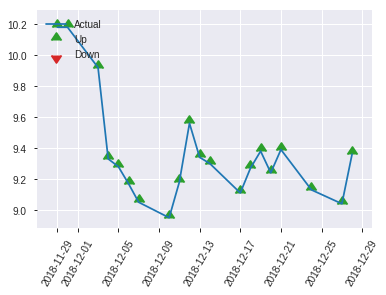


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25215746064916017
RMSE: 0.5021528259894195
LogLoss: 0.6977755390438009
Mean Per-Class Error: 0.43673015873015875
AUC: 0.536
pr_auc: 0.5389215162527259
Gini: 0.07200000000000006
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48385491967201233: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   103  0.8175   (103.0/126.0)
1      7    118  0.056    (7.0/125.0)
Total  30   221  0.4382   (110.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483855     0.682081  220
max f2                       0.432121     0.836707  240
max f0point5                 0.483855     0.584737  220
max accuracy                 0.483855     0.561753  220
max precision                0.700484     0.888889  8
max recall                   0.405317     1         246
max specificity              0.730301     0.992063  0
max absolute_mcc             0.483855     0.195034  220
max min_per_class_accuracy   0.563423     0.512     124
max mean_per_class_accuracy  0.483855     0.56327   220

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 56.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.720019           1.33867   1.33867            0.666667         0.725172  0.666667                    0.725172            0.016           0.016                      33.8667   33.8667
    2        0.0239044                   0.707132           2.008     1.67333            1                0.712258  0.833333                    0.718715            0.024           0.04                       100.8     67.3333
    3        0.0318725                   0.701286           2.008     1.757              1                0.703854  0.875                       0.715               0.016           0.056                      100.8     75.7
    4        0.0438247                   0.688954           0.669333  1.46036            0.333333         0.694856  0.727273                    0.709506            0.008           0.064                      -33.0667  46.0364
    5        0.0517928                   0.684285           0         1.23569            0                0.685211  0.615385                    0.705768            0               0.064                      -100      23.5692
    6        0.103586                    0.663641           1.08123   1.15846            0.538462         0.671699  0.576923                    0.688734            0.056           0.12                       8.12308   15.8462
    7        0.151394                    0.646182           1.004     1.10968            0.5              0.651638  0.552632                    0.677019            0.048           0.168                      0.4       10.9684
    8        0.203187                    0.624297           1.08123   1.10243            0.538462         0.634333  0.54902                     0.666139            0.056           0.224                      8.12308   10.2431
    9        0.302789                    0.600169           1.2048    1.13611            0.6              0.611864  0.565789                    0.648285            0.12            0.344                      20.48     13.6105
    10       0.40239                     0.579376           0.72288   1.03382            0.36             0.588842  0.514851                    0.633571            0.072           0.416                      -27.712   3.38218
    11       0.501992                    0.562931           0.96384   1.01994            0.48             0.569807  0.507937                    0.62092             0.096           0.512                      -3.616    1.99365
    12       0.601594                    0.545426           0.88352   0.997351           0.44             0.5549    0.496689                    0.609989            0.088           0.6                        -11.648   -0.264901
    13       0.701195                    0.530017           1.2048    1.02682            0.6              0.537344  0.511364                    0.599671            0.12            0.72                       20.48     2.68182
    14       0.800797                    0.509214           1.04416   1.02898            0.52             0.516184  0.512438                    0.589287            0.104           0.824                      4.416     2.89751
    15       0.900398                    0.473087           1.28512   1.05731            0.64             0.494532  0.526549                    0.578805            0.128           0.952                      28.512    5.73097
    16       1                           0.349752           0.48192   1                  0.24             0.432936  0.498008                    0.564276          

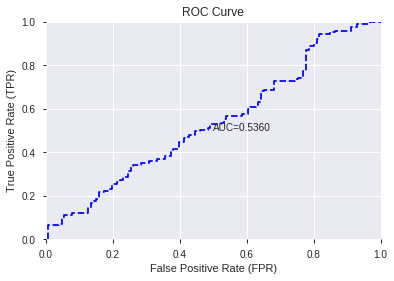

This function is available for GLM models only


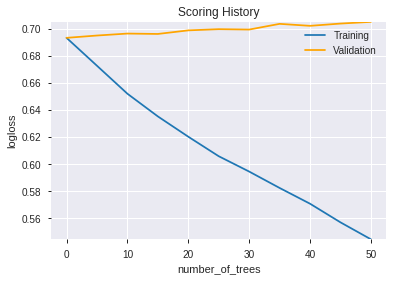

--2019-08-26 20:13:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_201244_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_201244_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_201338_model_9  0.533016  0.695755              0.500000  0.501299  0.251301
1  DeepLearning_grid_1_AutoML_20190826_201338_model_8  0.500000  0.698704              0.500000  0.502757  0.252764
2               DeepLearning_1_AutoML_20190826_201338  0.494349  0.747958              0.468413  0.524000  0.274576
3  DeepLearning_grid_1_AutoML_20190826_201338_model_5  0.460540  0.717238              0.492063  0.511061  0.261183
4  DeepLearning_grid_1_AutoML_20190826_201338_model_1  0.458286  2.083279              0.460413  0.676013  0.456993
5  DeepLearning_grid_1_AutoML_20190826_201338_model_6  0.457587  0.709078              0.496032  0.507756  0.257816
6  DeepLearning_grid_1_AutoML_20190826_201338_model_3  0.453270  1.102922              0.476222  0.600195  0.360234
7  DeepLearning_grid_1_AutoML_20190826_201338_model_2  0.439746  1.355523              0.480254  0.628665  0.395220
8  DeepLearning_grid_1_AutoML_20190826_201338_model_7  0.437841  0.963490              0.492063  0.584827  0.342022
9  DeepLearning_grid_1_AutoML_20190826_201338_model_4  0.436698  1.389943              0.500000  0.643076  0.413546

variable  relative_importance  scaled_importance  percentage
0        weekday_name             1.000000           1.000000    0.021293
1      STOCHRSI_fastk             0.991277           0.991277    0.021107
2                 BOP             0.982032           0.982032    0.020910
3   MACDFIX_signal_12             0.975722           0.975722    0.020776
4   MACDFIX_signal_20             0.974626           0.974626    0.020753
5       days_in_month             0.970734           0.970734    0.020670
6             weekday             0.970015           0.970015    0.020654
7           CORREL_12             0.966700           0.966700    0.020584
8      STOCHRSI_fastd             0.965256           0.965256    0.020553
9             ADXR_14             0.964337           0.964337    0.020533
10        AROONOSC_14             0.963783           0.963783    0.020522
11        HT_DCPERIOD             0.963681           0.963681    0.020520
12             SAREXT             0.963601           0.963601    0.020518
13              DX_30             0.963366           0.963366    0.020513
14    MACDFIX_hist_12             0.962659           0.962659    0.020498
15                SIN             0.960380           0.960380    0.020449
16            NATR_14             0.959226           0.959226    0.020425
17               COSH             0.956582           0.956582    0.020368
18         aroonup_14             0.953188           0.953188    0.020296
19               DX_8             0.952715           0.952715    0.020286
20            BETA_14             0.952342           0.952342    0.020278
21  MACDFIX_signal_24             0.950892           0.950892    0.020247
22                COS             0.948535           0.948535    0.020197
23            ADXR_12             0.947026           0.947026    0.020165
24         aroonup_20             0.944345           0.944345    0.020108
25              DX_14             0.942946           0.942946    0.020078
26             ATR_30             0.942387           0.942387    0.020066
27                day             0.942319           0.942319    0.020065
28            quarter             0.939734           0.939734    0.020010
29         aroonup_12             0.937622           0.937622    0.019965
30          dayofyear             0.936124           0.936124    0.019933
31         AROONOSC_8             0.934813           0.934813    0.019905
32         aroonup_30             0.932479           0.932479    0.019855
33               SINH             0.927083           0.927083    0.019740
34            BETA_12             0.924600           0.924600    0.019687
35             MFI_12             0.921062           0.921062    0.019612
36        AROONOSC_30             0.919963           0.919963    0.019589
37       aroondown_30             0.919279           0.919279    0.019574
38         PLUS_DM_12             0.917077           0.917077    0.019527
39               week             0.916572           0.916572    0.019516
40              VAR_8             0.914336           0.914336    0.019469
41          dayofweek             0.911486           0.911486    0.019408
42          CORREL_14             0.899266           0.899266    0.019148
43   is_quarter_start             0.898342           0.898342    0.019128
44  CDLGRAVESTONEDOJI             0.898269           0.898269    0.019127
45              month             0.896635           0.896635    0.019092
46             BETA_8             0.884976           0.884976    0.018844
47        AROONOSC_20             0.878153           0.878153    0.018698
48             ADX_24             0.873043           0.873043    0.018590
49         aroonup_24             0.852534           0.852534    0.018153

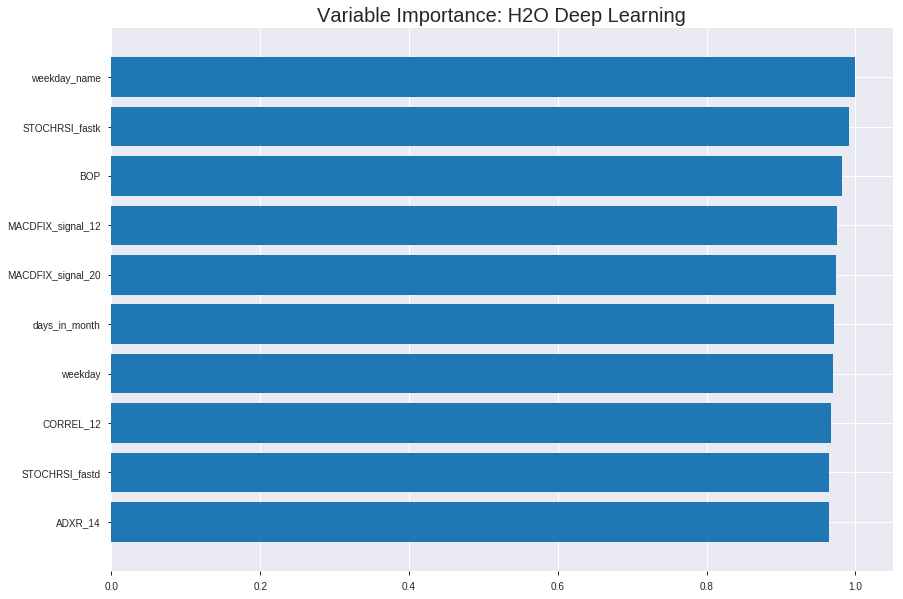

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_201338_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25061694412069724
RMSE: 0.5006165639695687
LogLoss: 0.6943849027828733
Mean Per-Class Error: 0.4827555003502413
AUC: 0.504853250212879
pr_auc: 0.5174274882002283
Gini: 0.009706500425757936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5275158347003256: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    860   0.9977   (860.0/862.0)
1      0    891   0        (0.0/891.0)
Total  2    1751  0.4906   (860.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.527516     0.674489   397
max f2                       0.527516     0.838194   397
max f0point5                 0.527516     0.564281   397
max accuracy                 0.534793     0.515687   154
max precision                0.538267     1          0
max recall                   0.527516     1          397
max specificity              0.538267     1          0
max absolute_mcc             0.529492     0.0411995  383
max min_per_class_accuracy   0.534525     0.500561   177
max mean_per_class_accuracy  0.534793     0.517244   154

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 53.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.53716            1.20233   1.20233            0.611111         0.537467  0.611111                    0.537467            0.0123457       0.0123457                  20.2332   20.2332
    2        0.0205362                   0.536871           0.655817  0.929075           0.333333         0.536996  0.472222                    0.537231            0.00673401      0.0190797                  -34.4183  -7.09253
    3        0.0302339                   0.536659           1.04159   0.965165           0.529412         0.536763  0.490566                    0.537081            0.010101        0.0291807                  4.15924   -3.48347
    4        0.040502                    0.536547           1.31163   1.053              0.666667         0.5366    0.535211                    0.536959            0.013468        0.0426487                  31.1635   5.30026
    5        0.0501997                   0.53641            1.15732   1.07316            0.588235         0.536483  0.545455                    0.536867            0.0112233       0.0538721                  15.7325   7.31558
    6        0.100399                    0.536003           0.983726  1.02844            0.5              0.536184  0.522727                    0.536526            0.0493827       0.103255                   -1.62738  2.8441
    7        0.150029                    0.535745           1.01765   1.02487            0.517241         0.535858  0.520913                    0.536305            0.0505051       0.15376                    1.76477   2.48706
    8        0.200228                    0.535514           1.09551   1.04258            0.556818         0.535625  0.529915                    0.536134            0.0549944       0.208754                   9.55132   4.25816
    9        0.300057                    0.535135           1.02308   1.03609            0.52             0.535311  0.526616                    0.53586             0.102132        0.310887                   2.30752   3.60918
    10       0.399886                    0.534805           1.03432   1.03565            0.525714         0.534972  0.526391                    0.535639            0.103255        0.414141                   3.43178   3.56489
    11       0.500285                    0.534512           0.86076   1.00055            0.4375           0.534656  0.508552                    0.535441            0.0864198       0.500561                   -13.924   0.0551569
    12       0.600114                    0.534193           0.95562   0.993077           0.485714         0.534367  0.504753                    0.535263            0.0953984       0.59596                    -4.43803  -0.692284
    13       0.699943                    0.533783           1.07929   1.00537            0.548571         0.533992  0.511002                    0.535082            0.107744        0.703704                   7.92881   0.537294
    14       0.799772                    0.533282           0.978105  1.00197            0.497143         0.533554  0.509272                    0.534891            0.0976431       0.801347                   -2.18951  0.196929
    15       0.899601                    0.532286           0.921892  0.993083           0.468571         0.532821  0.504756                    0.534661            0.0920314       0.893378                   -7.81081  -0.691691
    16       1                           0.526277           1.06198   1                  0.539773         0.531005  0.508272                    0.534294



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2470318125205125
RMSE: 0.497022949691976
LogLoss: 0.6872034935827291
Mean Per-Class Error: 0.4855305726302167
AUC: 0.4841151730831446
pr_auc: 0.5419374470909906
Gini: -0.031769653833710776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5267132528521858: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    220  1        (220.0/220.0)
1      0    281  0        (0.0/281.0)
Total  0    501  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.526713     0.71867    399
max f2                       0.526713     0.864615   399
max f0point5                 0.530168     0.615894   394
max accuracy                 0.530168     0.562874   394
max precision                0.537302     0.625      7
max recall                   0.526713     1          399
max specificity              0.537579     0.995455   0
max absolute_mcc             0.537573     0.0715495  1
max min_per_class_accuracy   0.534689     0.481818   192
max mean_per_class_accuracy  0.533893     0.514469   271

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 53.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.537401           0.891459  0.891459           0.5              0.537488  0.5                         0.537488            0.0106762       0.0106762                  -10.8541  -10.8541
    2        0.0219561                   0.537059           1.06975   0.972501           0.6              0.537243  0.545455                    0.537376            0.0106762       0.0213523                  6.97509   -2.74992
    3        0.0319361                   0.536929           0.713167  0.891459           0.4              0.536987  0.5                         0.537255            0.00711744      0.0284698                  -28.6833  -10.8541
    4        0.0419162                   0.536712           1.42633   1.01881            0.8              0.53679   0.571429                    0.537144            0.0142349       0.0427046                  42.6335   1.88104
    5        0.0518962                   0.536651           0.356584  0.891459           0.2              0.536684  0.5                         0.537056            0.00355872      0.0462633                  -64.3416  -10.8541
    6        0.101796                    0.536283           0.855801  0.873979           0.48             0.536419  0.490196                    0.536743            0.0427046       0.088968                   -14.4199  -12.6021
    7        0.151697                    0.535971           0.927117  0.891459           0.52             0.536137  0.5                         0.536544            0.0462633       0.135231                   -7.28826  -10.8541
    8        0.201597                    0.53574            1.06975   0.935591           0.6              0.535866  0.524752                    0.536376            0.0533808       0.188612                   6.97509   -6.44093
    9        0.301397                    0.535372           1.06975   0.980015           0.6              0.535555  0.549669                    0.536104            0.106762        0.295374                   6.97509   -1.99854
    10       0.401198                    0.53506            0.962776  0.975726           0.54             0.535193  0.547264                    0.535878            0.0960854       0.391459                   -3.72242  -2.42736
    11       0.500998                    0.534684           0.962776  0.973147           0.54             0.53486   0.545817                    0.535675            0.0960854       0.487544                   -3.72242  -2.68534
    12       0.600798                    0.534292           1.10541   0.995117           0.62             0.534493  0.55814                     0.535479            0.11032         0.597865                   10.5409   -0.488289
    13       0.700599                    0.533898           1.14107   1.01591            0.64             0.534088  0.569801                    0.53528             0.113879        0.711744                   14.1068   1.59078
    14       0.800399                    0.533429           0.855801  0.995944           0.48             0.533663  0.558603                    0.535079            0.0854093       0.797153                   -14.4199  -0.40557
    15       0.9002                      0.53278            0.927117  0.988314           0.52             0.53312   0.554324                    0.534862            0.0925267       0.88968                    -7.28826  -1.16862
    16       1                           0.526713           1.10541   1                  0.62             0.531725  0.560878                    0.5


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:21:55  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:21:58  2 min 58.555 sec  424 obs/sec       0.602396  1             1056       0.513204         0.723868            -0.0538018     0.524132        0.526915           0.76512          0.490017                         0.508831           0.715075              -0.0512218       0.548002          0.602644             1.18861            0.437126
    2019-08-26 20:22:15  3 min 16.096 sec  643 obs/sec       6.74843   11            11830      0.500617         0.694385            -0.0027422     0.504853        0.517427           1.20233          0.490588                         0.497023           0.687203              -0.00299631      0.484115          0.541937             0.891459           0.439122
    2019-08-26 20:22:32  3 min 33.050 sec  859 obs/sec       16.5881   27            29079      0.49969          0.692528            0.000964984    0.522462        0.519554           0.983726         0.488876                         0.499656           0.692459              -0.0136503       0.478543          0.541488             0.297153           0.433134
    2019-08-26 20:22:48  3 min 48.267 sec  1083 obs/sec      29.3828   48            51508      0.499955         0.693057            -9.25053e-05   0.5             0                  1                0.491728                         0.49959            0.692328              -0.0133844       0.5               0                    1                  0.439122
    2019-08-26 20:23:03  4 min  3.642 sec  1293 obs/sec      45.2601   74            79341      0.50042          0.69399             -0.0019555     0.5             0                  1                0.491728                         0.497216           0.68759               -0.0037768       0.5               0                    1                  0.439122
    2019-08-26 20:23:19  4 min 19.306 sec  1402 obs/sec      60.4141   99            105906     0.499658         0.692463            0.00109429     0.533424        0.530698           0.983726         0.486024                         0.498513           0.690178              -0.00902036      0.474046          0.531666             0.891459           0.439122
    2019-08-26 20:23:20  4 min 20.840 sec  1402 obs/sec      60.4141   99            105906     0.500617         0.694385            -0.0027422     0.504853        0.517427           1.20233          0.490588                         0.497023           0.687203              -0.00299631      0.484115          0.541937             0.891459           0.439122

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
weekday_name       1.0                    1.0                  0.02129285070273162
STOCHRSI_fastk     0.9912771582603455     0.9912771582603455   0.0211071165358656
BOP                0.9820316433906555     0.9820316433906555   0.020910253168075408
MACDFIX_signal_12  0.9757221341133118     0.9757221341133118   0.020775905729025428
MACDFIX_signal_20  0.9746260046958923     0.9746260046958923   0.02075256600898944
---                ---                    ---                  ---
month              0.8966352939605713     0.8966352939605713   0.019091921449102323
BETA_8             0.8849764466285706     0.8849764466285706   0.01884367135349609
AROONOSC_20        0.8781530261039734     0.8781530261039734   0.018698381278983888
ADX_24             0.8730428814888        0.8730428814888      0.018589571732623635
aroonup_24         0.8525344729423523     0.8525344729423523   0.0181528892512935


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.6648936170212766)

('auc', 0.5330158730158729)

('logloss', 0.6957553136838643)

('mean_per_class_error', 0.45492063492063495)

('rmse', 0.5012994541048827)

('mse', 0.2513011426858534)

deeplearning prediction progress: |███████████████████████████████████████| 100%


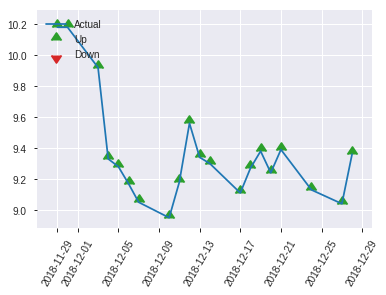


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2513011426858534
RMSE: 0.5012994541048827
LogLoss: 0.6957553136838643
Mean Per-Class Error: 0.45492063492063495
AUC: 0.5330158730158729
pr_auc: 0.527745958848897
Gini: 0.06603174603174589
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5291258066182144: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    126  1        (126.0/126.0)
1      0    125  0        (0.0/125.0)
Total  0    251  0.502    (126.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.529126     0.664894   250
max f2                       0.529126     0.832224   250
max f0point5                 0.534111     0.559482   180
max accuracy                 0.535217     0.545817   78
max precision                0.53652      1          0
max recall                   0.529126     1          250
max specificity              0.53652      1          0
max absolute_mcc             0.536241     0.0981661  10
max min_per_class_accuracy   0.5347       0.52       124
max mean_per_class_accuracy  0.535217     0.545079   78

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 53.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.536434           0.669333  0.669333           0.333333         0.536465  0.333333                    0.536465            0.008           0.008                      -33.0667  -33.0667
    2        0.0239044                   0.536312           2.008     1.33867            1                0.536381  0.666667                    0.536423            0.024           0.032                      100.8     33.8667
    3        0.0318725                   0.536264           1.004     1.255              0.5              0.536278  0.625                       0.536387            0.008           0.04                       0.4       25.5
    4        0.0438247                   0.536241           2.008     1.46036            1                0.536251  0.727273                    0.53635             0.024           0.064                      100.8     46.0364
    5        0.0517928                   0.536208           0         1.23569            0                0.53622   0.615385                    0.53633             0               0.064                      -100      23.5692
    6        0.103586                    0.535904           0.926769  1.08123            0.461538         0.536074  0.538462                    0.536202            0.048           0.112                      -7.32308  8.12308
    7        0.151394                    0.535629           1.33867   1.16253            0.666667         0.535716  0.578947                    0.536049            0.064           0.176                      33.8667   16.2526
    8        0.203187                    0.535461           1.08123   1.1418             0.538462         0.535519  0.568627                    0.535914            0.056           0.232                      8.12308   14.1804
    9        0.302789                    0.535239           1.04416   1.10968            0.52             0.535322  0.552632                    0.535719            0.104           0.336                      4.416     10.9684
    10       0.40239                     0.534962           0.88352   1.0537             0.44             0.535106  0.524752                    0.535567            0.088           0.424                      -11.648   5.3703
    11       0.501992                    0.5347             0.96384   1.03587            0.48             0.534844  0.515873                    0.535424            0.096           0.52                       -3.616    3.5873
    12       0.601594                    0.534448           0.96384   1.02395            0.48             0.534564  0.509934                    0.535281            0.096           0.616                      -3.616    2.3947
    13       0.701195                    0.534144           1.2048    1.04964            0.6              0.534313  0.522727                    0.535144            0.12            0.736                      20.48     4.96364
    14       0.800797                    0.533828           0.72288   1.009              0.36             0.534004  0.502488                    0.535002            0.072           0.808                      -27.712   0.899502
    15       0.900398                    0.533246           0.88352   0.995115           0.44             0.533539  0.495575                    0.53484             0.088           0.896                      -11.648   -0.488496
    16       1                           0.529126           1.04416   1                  0.52             0.532039  0.498008                    0.534561           

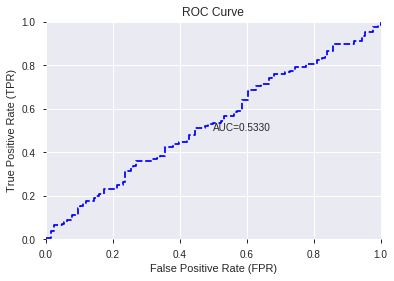

This function is available for GLM models only


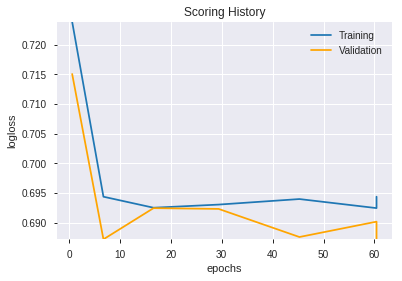

--2019-08-26 20:23:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_201338_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_201338_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'STOCHRSI_fastk',
 'BOP',
 'MACDFIX_signal_12',
 'MACDFIX_signal_20',
 'days_in_month',
 'weekday',
 'CORREL_12',
 'STOCHRSI_fastd',
 'ADXR_14',
 'AROONOSC_14',
 'HT_DCPERIOD',
 'SAREXT',
 'DX_30',
 'MACDFIX_hist_12',
 'SIN',
 'NATR_14',
 'COSH',
 'aroonup_14',
 'DX_8',
 'BETA_14',
 'MACDFIX_signal_24',
 'COS',
 'ADXR_12',
 'aroonup_20',
 'DX_14',
 'ATR_30',
 'day',
 'quarter',
 'aroonup_12',
 'dayofyear',
 'AROONOSC_8',
 'aroonup_30',
 'SINH',
 'BETA_12',
 'MFI_12',
 'AROONOSC_30',
 'aroondown_30',
 'PLUS_DM_12',
 'week',
 'VAR_8',
 'dayofweek',
 'CORREL_14',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'month',
 'BETA_8',
 'AROONOSC_20',
 'ADX_24',
 'aroonup_24']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_202336_model_1  0.495111  0.693513              0.472349  0.500182  0.250182

variable  relative_importance  scaled_importance  percentage
0          aroonup_20             0.008772           1.000000    0.063870
1                SINH             0.007882           0.898521    0.057388
2                COSH             0.007865           0.896580    0.057264
3         HT_DCPERIOD             0.006315           0.719913    0.045981
4        weekday_name             0.006118           0.697481    0.044548
5                 BOP             0.006022           0.686447    0.043843
6           CORREL_14             0.005856           0.667554    0.042637
7              ATR_30             0.005478           0.624467    0.039885
8             ADXR_14             0.005208           0.593665    0.037917
9              ADX_24             0.004891           0.557514    0.035608
10          CORREL_12             0.004735           0.539748    0.034474
11             SAREXT             0.004339           0.494597    0.031590
12         PLUS_DM_12             0.004325           0.493080    0.031493
13        AROONOSC_20             0.004255           0.485053    0.030980
14          dayofyear             0.003651           0.416169    0.026581
15              month             0.003482           0.396887    0.025349
16            ADXR_12             0.003422           0.390057    0.024913
17         aroonup_30             0.003284           0.374404    0.023913
18     STOCHRSI_fastk             0.003120           0.355626    0.022714
19       aroondown_30             0.002830           0.322670    0.020609
20  CDLGRAVESTONEDOJI             0.002749           0.313430    0.020019
21            quarter             0.002628           0.299599    0.019135
22             BETA_8             0.002192           0.249883    0.015960
23              VAR_8             0.002131           0.242964    0.015518
24            BETA_14             0.002104           0.239862    0.015320
25         AROONOSC_8             0.002016           0.229827    0.014679
26                COS             0.001827           0.208280    0.013303
27   is_quarter_start             0.001689           0.192559    0.012299
28                day             0.001683           0.191876    0.012255
29      days_in_month             0.001415           0.161309    0.010303
30              DX_30             0.001384           0.157736    0.010075
31               week             0.001337           0.152373    0.009732
32             MFI_12             0.001276           0.145406    0.009287
33        AROONOSC_14             0.001200           0.136838    0.008740
34  MACDFIX_signal_24             0.001193           0.135981    0.008685
35         aroonup_12             0.001165           0.132827    0.008484
36    MACDFIX_hist_12             0.001079           0.122988    0.007855
37                SIN             0.001060           0.120818    0.007717
38  MACDFIX_signal_20             0.000923           0.105185    0.006718
39            NATR_14             0.000785           0.089469    0.005714
40            BETA_12             0.000738           0.084185    0.005377
41               DX_8             0.000657           0.074901    0.004784
42  MACDFIX_signal_12             0.000558           0.063594    0.004062
43         aroonup_14             0.000527           0.060051    0.003835
44         aroonup_24             0.000429           0.048956    0.003127
45        AROONOSC_30             0.000291           0.033155    0.002118
46     STOCHRSI_fastd             0.000196           0.022304    0.001425
47              DX_14             0.000136           0.015548    0.000993
48            weekday             0.000065           0.007467    0.000477
49          dayofweek             0.000062           0.007021    0.000448

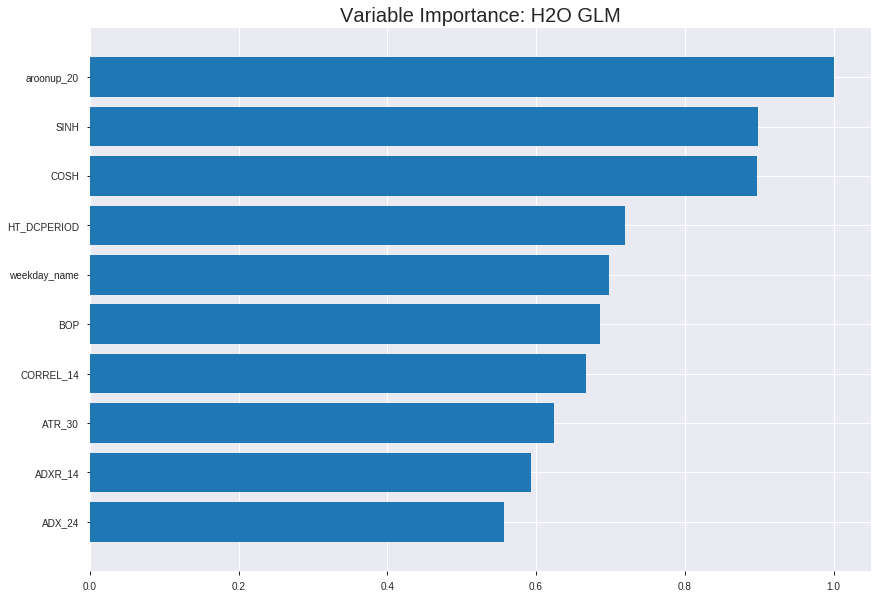

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_202336_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.249201887933441
RMSE: 0.4992012499317695
LogLoss: 0.6915496637225436
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.694244156657
Residual deviance: 2424.5731210112376
AIC: 2526.5731210112376
AUC: 0.5447560159470446
pr_auc: 0.5459033607011857
Gini: 0.08951203189408918
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48541936252710244: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   843   0.978    (843.0/862.0)
1      7    884   0.0079   (7.0/891.0)
Total  26   1727  0.4849   (850.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.485419     0.675325   375
max f2                       0.463856     0.838509   395
max f0point5                 0.498625     0.57253    311
max accuracy                 0.503702     0.536224   255
max precision                0.536257     1          0
max recall                   0.463856     1          395
max specificity              0.536257     1          0
max absolute_mcc             0.498625     0.0861849  311
max min_per_class_accuracy   0.508395     0.526682   195
max mean_per_class_accuracy  0.510867     0.533038   166

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.530993           1.31163   1.31163            0.666667         0.533223  0.666667                    0.533223            0.013468        0.013468                   31.1635   31.1635
    2        0.0205362                   0.528224           1.09303   1.20233            0.555556         0.529459  0.611111                    0.531341            0.0112233       0.0246914                  9.30291   20.2332
    3        0.0302339                   0.52554            1.27306   1.22502            0.647059         0.526801  0.622642                    0.529885            0.0123457       0.037037                   27.3057   22.5017
    4        0.040502                    0.523919           0.874423  1.13613            0.444444         0.524528  0.577465                    0.528527            0.00897868      0.0460157                  -12.5577  13.6134
    5        0.0501997                   0.522354           1.15732   1.14023            0.588235         0.522898  0.579545                    0.52744             0.0112233       0.0572391                  15.7325   14.0228
    6        0.100399                    0.518704           1.2073    1.17376            0.613636         0.520198  0.596591                    0.523819            0.0606061       0.117845                   20.73     17.3764
    7        0.150029                    0.516745           0.904576  1.08472            0.45977          0.517639  0.551331                    0.521775            0.0448934       0.162738                   -9.54242  8.4717
    8        0.200228                    0.514989           1.0508    1.07621            0.534091         0.515805  0.547009                    0.520278            0.0527497       0.215488                   5.07984   7.62132
    9        0.300057                    0.51256            1.07929   1.07724            0.548571         0.513624  0.547529                    0.518064            0.107744        0.323232                   7.92881   7.72362
    10       0.399886                    0.510325           1.09053   1.08056            0.554286         0.511541  0.549215                    0.516436            0.108866        0.432099                   9.05307   8.05551
    11       0.500285                    0.50837            0.939011  1.05215            0.477273         0.509366  0.534778                    0.515017            0.0942761       0.526375                   -6.09887  5.21495
    12       0.600114                    0.50639            0.989347  1.0417             0.502857         0.507332  0.529468                    0.513739            0.0987654       0.62514                    -1.06526  4.17024
    13       0.699943                    0.504263           1.0568    1.04386            0.537143         0.505323  0.530562                    0.512538            0.105499        0.73064                    5.6803    4.38561
    14       0.799772                    0.501647           0.944377  1.03144            0.48             0.502968  0.524251                    0.511344            0.0942761       0.824916                   -5.56229  3.1439
    15       0.899601                    0.498288           0.978105  1.02552            0.497143         0.50015   0.521243                    0.510102            0.0976431       0.922559                   -2.18951  2.55205
    16       1                           0.451479           0.771331  1                  0.392045         0.491874  0.508272                    0.508272           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24884466938479446
RMSE: 0.498843331502782
LogLoss: 0.6908381615964769
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 692.6521653604563
Residual deviance: 692.21983791967
AIC: 794.21983791967
AUC: 0.5072549336784212
pr_auc: 0.5553518105451931
Gini: 0.014509867356842454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4960060456190726: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    213  0.9682   (213.0/220.0)
1      2    279  0.0071   (2.0/281.0)
Total  9    492  0.4291   (215.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496006     0.721863  390
max f2                       0.49496      0.864731  393
max f0point5                 0.496006     0.620276  390
max accuracy                 0.497557     0.570858  375
max precision                0.523978     0.6       52
max recall                   0.489671     1         399
max specificity              0.555632     0.995455  0
max absolute_mcc             0.542547     0.124427  5
max min_per_class_accuracy   0.511989     0.5       203
max mean_per_class_accuracy  0.508002     0.521077  251

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.542547           0         0                  0                0.548351  0                           0.548351            0               0                          -100       -100
    2        0.0219561                   0.537485           1.42633   0.648334           0.8              0.540419  0.363636                    0.544745            0.0142349       0.0142349                  42.6335    -35.1666
    3        0.0319361                   0.532593           0.713167  0.668594           0.4              0.534609  0.375                       0.541578            0.00711744      0.0213523                  -28.6833   -33.1406
    4        0.0419162                   0.530764           1.06975   0.764108           0.6              0.531597  0.428571                    0.539201            0.0106762       0.0320285                  6.97509    -23.5892
    5        0.0518962                   0.528186           1.42633   0.891459           0.8              0.529009  0.5                         0.537241            0.0142349       0.0462633                  42.6335    -10.8541
    6        0.101796                    0.524362           1.14107   1.01382            0.64             0.525846  0.568627                    0.531656            0.0569395       0.103203                   14.1068    1.38162
    7        0.151697                    0.521545           0.998434  1.00876            0.56             0.522833  0.565789                    0.528753            0.0498221       0.153025                   -0.156584  0.875632
    8        0.201597                    0.520127           1.06975   1.02385            0.6              0.520872  0.574257                    0.526802            0.0533808       0.206406                   6.97509    2.3854
    9        0.301397                    0.51712            0.891459  0.980015           0.5              0.518353  0.549669                    0.524005            0.088968        0.295374                   -10.8541   -1.99854
    10       0.401198                    0.515075           1.14107   1.02008            0.64             0.515982  0.572139                    0.522009            0.113879        0.409253                   14.1068    2.00775
    11       0.500998                    0.511989           0.927117  1.00156            0.52             0.513382  0.561753                    0.52029             0.0925267       0.501779                   -7.28826   0.15596
    12       0.600798                    0.508629           1.10541   1.01881            0.62             0.510381  0.571429                    0.518644            0.11032         0.6121                     10.5409    1.88104
    13       0.700599                    0.506019           0.891459  1.00067            0.5              0.507467  0.561254                    0.517052            0.088968        0.701068                   -10.8541   0.0669161
    14       0.800399                    0.503197           0.998434  1.00039            0.56             0.504444  0.561097                    0.51548             0.0996441       0.800712                   -0.156584  0.0390483
    15       0.9002                      0.500339           1.06975   1.00808            0.6              0.501718  0.56541                     0.513954            0.106762        0.907473                   6.97509    0.808011
    16       1                           0.489671           0.927117  1                  0.52             0.497472  0.560878             


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 20:23:37  0.000 sec   2            2.1       51            1.3831            1.38168
    2019-08-26 20:23:37  0.011 sec   4            1.3       51            1.38198           1.38171
    2019-08-26 20:23:37  0.023 sec   6            0.79      51            1.38065           1.38201
    2019-08-26 20:23:37  0.036 sec   8            0.49      51            1.37914           1.38261
    2019-08-26 20:23:37  0.049 sec   10           0.3       51            1.37749           1.38352
    2019-08-26 20:23:37  0.063 sec   12           0.19      51            1.37573           1.3846

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.6703601108033241)

('auc', 0.4951111111111111)

('logloss', 0.6935126231072049)

('mean_per_class_error', 0.4530793650793651)

('rmse', 0.5001823474072012)

('mse', 0.2501823806577782)

glm prediction progress: |████████████████████████████████████████████████| 100%


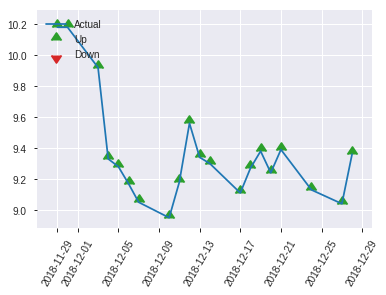


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2501823806577782
RMSE: 0.5001823474072012
LogLoss: 0.6935126231072049
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.0616751555067
Residual deviance: 348.14333679981684
AIC: 450.14333679981684
AUC: 0.4951111111111111
pr_auc: 0.4646667384392535
Gini: -0.009777777777777774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4999774020698316: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   115  0.9127   (115.0/126.0)
1      4    121  0.032    (4.0/125.0)
Total  15   236  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499977     0.67036   235
max f2                       0.492164     0.833333  249
max f0point5                 0.503316     0.569488  207
max accuracy                 0.505382     0.545817  180
max precision                0.505382     0.530387  180
max recall                   0.492164     1         249
max specificity              0.523689     0.992063  0
max absolute_mcc             0.513423     0.150657  39
max min_per_class_accuracy   0.508029     0.504     122
max mean_per_class_accuracy  0.504377     0.546921  194

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.522203           0         0                  0                0.522776  0                           0.522776            0               0                          -100      -100
    2        0.0239044                   0.521797           1.33867   0.669333           0.666667         0.52199   0.333333                    0.522383            0.016           0.016                      33.8667   -33.0667
    3        0.0318725                   0.519914           0         0.502              0                0.520555  0.25                        0.521926            0               0.016                      -100      -49.8
    4        0.0438247                   0.519115           0.669333  0.547636           0.333333         0.519443  0.272727                    0.521249            0.008           0.024                      -33.0667  -45.2364
    5        0.0517928                   0.518157           2.008     0.772308           1                0.518679  0.384615                    0.520853            0.016           0.04                       100.8     -22.7692
    6        0.103586                    0.515153           0.617846  0.695077           0.307692         0.516176  0.346154                    0.518515            0.032           0.072                      -38.2154  -30.4923
    7        0.151394                    0.513533           0.669333  0.686947           0.333333         0.51413   0.342105                    0.51713             0.032           0.104                      -33.0667  -31.3053
    8        0.203187                    0.512942           1.23569   0.826824           0.615385         0.513274  0.411765                    0.516147            0.064           0.168                      23.5692   -17.3176
    9        0.302789                    0.511156           1.12448   0.924737           0.56             0.511987  0.460526                    0.514779            0.112           0.28                       12.448    -7.52632
    10       0.40239                     0.509194           0.96384   0.934416           0.48             0.510089  0.465347                    0.513618            0.096           0.376                      -3.616    -6.55842
    11       0.501992                    0.507946           1.28512   1.004              0.64             0.508446  0.5                         0.512592            0.128           0.504                      28.512    0.4
    12       0.601594                    0.50659            1.12448   1.02395            0.56             0.507331  0.509934                    0.511721            0.112           0.616                      12.448    2.3947
    13       0.701195                    0.505527           1.28512   1.06105            0.64             0.506022  0.528409                    0.510911            0.128           0.744                      28.512    6.10455
    14       0.800797                    0.50404            0.96384   1.04896            0.48             0.50492   0.522388                    0.510166            0.096           0.84                       -3.616    4.89552
    15       0.900398                    0.501405           0.8032    1.02177            0.4              0.502732  0.50885                     0.509344            0.08            0.92                       -19.68    2.17699
    16       1                           0.491469           0.8032    1                  0.4              0.497557  0.498008                    0.50817            

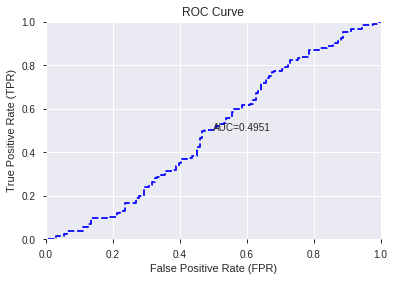

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


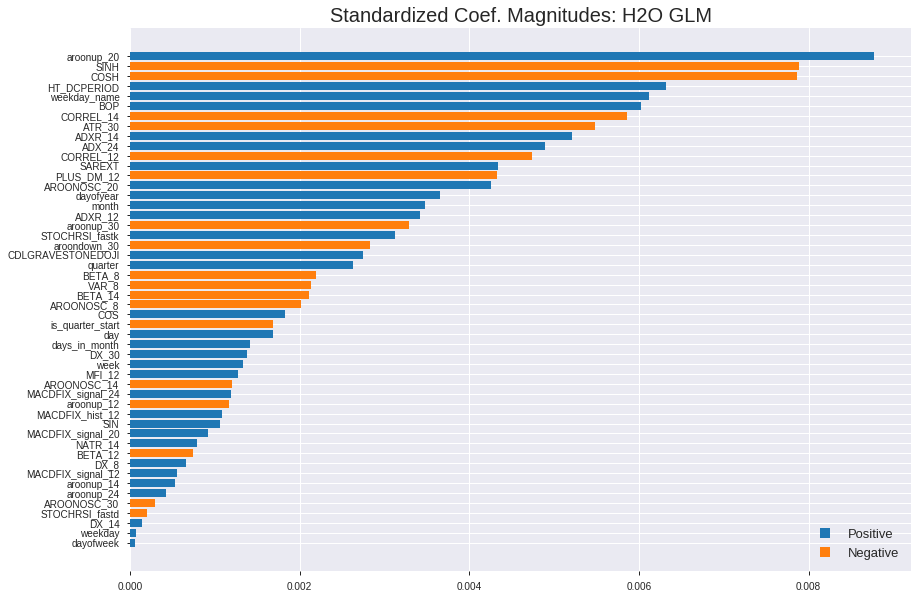

'log_likelihood'
--2019-08-26 20:23:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_202336_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_202336_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['aroonup_20',
 'SINH',
 'COSH',
 'HT_DCPERIOD',
 'weekday_name',
 'BOP',
 'CORREL_14',
 'ATR_30',
 'ADXR_14',
 'ADX_24',
 'CORREL_12',
 'SAREXT',
 'PLUS_DM_12',
 'AROONOSC_20',
 'dayofyear',
 'month',
 'ADXR_12',
 'aroonup_30',
 'STOCHRSI_fastk',
 'aroondown_30',
 'CDLGRAVESTONEDOJI',
 'quarter',
 'BETA_8',
 'VAR_8',
 'BETA_14',
 'AROONOSC_8',
 'COS',
 'is_quarter_start',
 'day',
 'days_in_month',
 'DX_30',
 'week',
 'MFI_12',
 'AROONOSC_14',
 'MACDFIX_signal_24',
 'aroonup_12',
 'MACDFIX_hist_12',
 'SIN',
 'MACDFIX_signal_20',
 'NATR_14',
 'BETA_12',
 'DX_8',
 'MACDFIX_signal_12',
 'aroonup_14',
 'aroonup_24',
 'AROONOSC_30',
 'STOCHRSI_fastd',
 'DX_14',
 'weekday',
 'dayofweek']

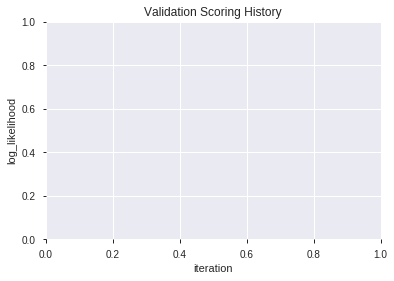

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_202353_model_4  0.513143  0.699153              0.500000  0.502938  0.252946
1               XGBoost_2_AutoML_20190826_202353  0.504825  0.711671              0.496032  0.508662  0.258738
2  XGBoost_grid_1_AutoML_20190826_202353_model_3  0.501524  0.708570              0.484127  0.507150  0.257202
3  XGBoost_grid_1_AutoML_20190826_202353_model_1  0.499683  0.702652              0.488095  0.504626  0.254647
4               XGBoost_3_AutoML_20190826_202353  0.490730  0.707625              0.480159  0.506927  0.256975
5  XGBoost_grid_1_AutoML_20190826_202353_model_7  0.489968  0.724486              0.496032  0.514274  0.264478
6               XGBoost_1_AutoML_20190826_202353  0.487175  0.714987              0.480159  0.510183  0.260287
7  XGBoost_grid_1_AutoML_20190826_202353_model_6  0.469079  0.710778              0.492095  0.508556  0.258629
8  XGBoost_grid_1_AutoML_20190826_202353_model_5  0.451175  0.758756              0.500000  0.529272  0.280129
9  XGBoost_grid_1_AutoML_20190826_202353_model_2  0.449778  0.711202              0.488095  0.508757  0.258833

variable  relative_importance  scaled_importance  percentage
0              ATR_30           121.038292           1.000000    0.044856
1                 BOP           118.269737           0.977127    0.043830
2             BETA_14           117.242004           0.968636    0.043449
3           dayofyear           115.848717           0.957125    0.042932
4              SAREXT           113.929863           0.941271    0.042221
5              BETA_8           108.360115           0.895255    0.040157
6      STOCHRSI_fastd           107.595062           0.888934    0.039874
7          aroonup_20            99.985443           0.826065    0.037054
8          PLUS_DM_12            88.934517           0.734763    0.032958
9              ADX_24            86.848763           0.717531    0.032185
10        HT_DCPERIOD            85.188774           0.703817    0.031570
11                COS            80.462227           0.664767    0.029818
12       aroondown_30            80.122871           0.661963    0.029693
13          CORREL_12            79.006737           0.652742    0.029279
14            ADXR_14            77.854691           0.643224    0.028852
15          CORREL_14            77.374817           0.639259    0.028674
16               COSH            73.243004           0.605123    0.027143
17         aroonup_24            71.690063           0.592292    0.026568
18            BETA_12            68.858727           0.568900    0.025518
19                SIN            65.740387           0.543137    0.024363
20        AROONOSC_30            60.424782           0.499220    0.022393
21             MFI_12            60.393139           0.498959    0.022381
22         aroonup_30            57.766403           0.477257    0.021408
23        AROONOSC_14            55.567848           0.459093    0.020593
24                day            51.925007           0.428997    0.019243
25              VAR_8            50.446735           0.416783    0.018695
26            ADXR_12            50.399925           0.416397    0.018678
27  MACDFIX_signal_24            49.430813           0.408390    0.018319
28        AROONOSC_20            49.038177           0.405146    0.018173
29               DX_8            48.391037           0.399799    0.017933
30    MACDFIX_hist_12            47.782639           0.394773    0.017708
31              DX_14            44.643406           0.368837    0.016544
32              DX_30            43.906761           0.362751    0.016271
33            NATR_14            30.293850           0.250283    0.011227
34  MACDFIX_signal_12            24.220093           0.200103    0.008976
35         AROONOSC_8            22.120295           0.182755    0.008198
36         aroonup_12            21.678436           0.179104    0.008034
37          dayofweek            21.537676           0.177941    0.007982
38     STOCHRSI_fastk            18.354963           0.151646    0.006802
39       weekday_name            16.242214           0.134191    0.006019
40  MACDFIX_signal_20            13.715343           0.113314    0.005083
41               week            12.821875           0.105932    0.004752
42      days_in_month             9.706295           0.080192    0.003597

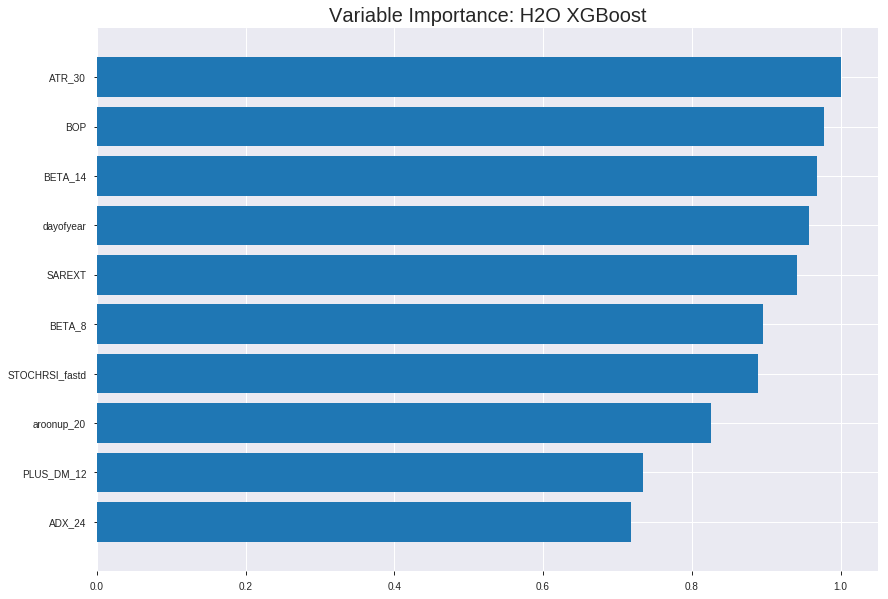

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_202353_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22104462176056644
RMSE: 0.470153827763389
LogLoss: 0.6344748055594428
Mean Per-Class Error: 0.2791116892044967
AUC: 0.7962246856291714
pr_auc: 0.7965707072868208
Gini: 0.5924493712583427
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48410525918006897: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      504  358   0.4153   (358.0/862.0)
1      134  757   0.1504   (134.0/891.0)
Total  638  1115  0.2807   (492.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484105     0.754736  236
max f2                       0.419675     0.852405  333
max f0point5                 0.521843     0.73386   171
max accuracy                 0.506289     0.72105   199
max precision                0.688923     1         0
max recall                   0.346372     1         394
max specificity              0.688923     1         0
max absolute_mcc             0.484105     0.451262  236
max min_per_class_accuracy   0.50805      0.718294  196
max mean_per_class_accuracy  0.506289     0.720888  199

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.655716           1.96745   1.96745            1                0.667769  1                           0.667769            0.020202        0.020202                   96.7452   96.7452
    2        0.0205362                   0.639115           1.85815   1.9128             0.944444         0.644596  0.972222                    0.656183            0.0190797       0.0392817                  85.8149   91.2801
    3        0.0302339                   0.628037           1.73599   1.85609            0.882353         0.63414   0.943396                    0.649112            0.016835        0.0561167                  73.5987   85.6087
    4        0.040502                    0.622466           1.74885   1.8289             0.888889         0.624935  0.929577                    0.642983            0.0179574       0.0740741                  74.8846   82.8899
    5        0.0501997                   0.61642            1.85172   1.83331            0.941176         0.619108  0.931818                    0.638371            0.0179574       0.0920314                  85.172    83.3308
    6        0.100399                    0.595132           1.81095   1.82213            0.920455         0.605459  0.926136                    0.621915            0.0909091       0.182941                   81.095    82.2129
    7        0.150029                    0.57753            1.67347   1.77295            0.850575         0.585492  0.901141                    0.609866            0.0830527       0.265993                   67.3465   77.2951
    8        0.200228                    0.564758           1.45323   1.69279            0.738636         0.571206  0.860399                    0.600174            0.0729517       0.338945                   45.3232   69.2794
    9        0.300057                    0.542827           1.39408   1.59341            0.708571         0.553296  0.809886                    0.584577            0.139169        0.478114                   39.408    59.3412
    10       0.399886                    0.523467           1.2929    1.51839            0.657143         0.533249  0.771755                    0.571764            0.129068        0.607183                   29.2897   51.839
    11       0.500285                    0.508003           1.07316   1.42904            0.545455         0.515817  0.72634                     0.560536            0.107744        0.714927                   7.31558   42.9039
    12       0.600114                    0.49064            0.933135  1.34655            0.474286         0.499522  0.684411                    0.550386            0.0931538       0.808081                   -6.68655  34.6545
    13       0.699943                    0.474013           0.843194  1.27476            0.428571         0.482031  0.647922                    0.540637            0.0841751       0.892256                   -15.6806  27.4755
    14       0.799772                    0.451517           0.472189  1.17458            0.24             0.463061  0.597004                    0.530954            0.047138        0.939394                   -52.7811  17.4577
    15       0.899601                    0.42326            0.427218  1.09164            0.217143         0.438767  0.554851                    0.520724            0.0426487       0.982043                   -57.2782  9.16428
    16       1                           0.30383            0.178859  1                  0.0909091        0.393173  0.508272                    0.507918          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25187774814635044
RMSE: 0.5018742353880606
LogLoss: 0.6970549227891016
Mean Per-Class Error: 0.46912811387900355
AUC: 0.5023778712390812
pr_auc: 0.549312339567106
Gini: 0.00475574247816235
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.371648907661438: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    220  1        (220.0/220.0)
1      0    281  0        (0.0/281.0)
Total  0    501  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.371649     0.71867    399
max f2                       0.371649     0.864615   399
max f0point5                 0.371649     0.61488    399
max accuracy                 0.371649     0.560878   399
max precision                0.667749     1          0
max recall                   0.371649     1          399
max specificity              0.667749     1          0
max absolute_mcc             0.620057     0.0805504  14
max min_per_class_accuracy   0.516132     0.513636   200
max mean_per_class_accuracy  0.488019     0.530872   269

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.640448           0.891459  0.891459           0.5              0.648791  0.5                         0.648791            0.0106762       0.0106762                  -10.8541  -10.8541
    2        0.0219561                   0.63103            0.713167  0.810417           0.4              0.635075  0.454545                    0.642556            0.00711744      0.0177936                  -28.6833  -18.9583
    3        0.0319361                   0.618635           0.356584  0.668594           0.2              0.623673  0.375                       0.636655            0.00355872      0.0213523                  -64.3416  -33.1406
    4        0.0419162                   0.614522           1.42633   0.849009           0.8              0.615762  0.47619                     0.631681            0.0142349       0.0355872                  42.6335   -15.0991
    5        0.0518962                   0.610412           1.06975   0.891459           0.6              0.612478  0.5                         0.627988            0.0106762       0.0462633                  6.97509   -10.8541
    6        0.101796                    0.590115           0.927117  0.908939           0.52             0.600899  0.509804                    0.614709            0.0462633       0.0925267                  -7.28826  -9.10613
    7        0.151697                    0.568049           0.927117  0.914919           0.52             0.579699  0.513158                    0.603192            0.0462633       0.13879                    -7.28826  -8.50815
    8        0.201597                    0.557613           0.855801  0.900285           0.48             0.562609  0.50495                     0.593147            0.0427046       0.181495                   -14.4199  -9.97146
    9        0.301397                    0.543978           1.14107   0.980015           0.64             0.55015   0.549669                    0.57891             0.113879        0.295374                   14.1068   -1.99854
    10       0.401198                    0.530025           1.10541   1.01121            0.62             0.535813  0.567164                    0.568189            0.11032         0.405694                   10.5409   1.12073
    11       0.500998                    0.516454           1.06975   1.02287            0.6              0.523432  0.573705                    0.559274            0.106762        0.512456                   6.97509   2.28694
    12       0.600798                    0.50086            0.927117  1.00696            0.52             0.50756   0.564784                    0.550683            0.0925267       0.604982                   -7.28826  0.696374
    13       0.700599                    0.485759           1.17673   1.03115            0.66             0.492697  0.578348                    0.542423            0.117438        0.72242                    17.6726   3.11464
    14       0.800399                    0.469518           0.927117  1.01818            0.52             0.477605  0.571072                    0.534341            0.0925267       0.814947                   -7.28826  1.81752
    15       0.9002                      0.444549           0.784484  0.992267           0.44             0.457511  0.556541                    0.525823            0.0782918       0.893238                   -21.5516  -0.773291
    16       1                           0.371649           1.06975   1                  0.6              0.421799  0.560878                    0.515


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:23:59  2.132 sec   0                  0.5              0.693147            0.5             0                  1                0.491728                         0.5                0.693147              0.5               0                    1                  0.439122
    2019-08-26 20:23:59  2.191 sec   5                  0.496954         0.687071            0.644354        0.634893           1.27884          0.469481                         0.499541           0.692228              0.513871          0.576607             1.52822            0.43513
    2019-08-26 20:23:59  2.239 sec   10                 0.493572         0.680353            0.682937        0.677645           1.53024          0.431261                         0.498966           0.691082              0.532538          0.582132             0.891459           0.437126
    2019-08-26 20:23:59  2.297 sec   15                 0.490287         0.673854            0.708555        0.7114             1.74885          0.412436                         0.499132           0.691416              0.516508          0.571351             0.594306           0.439122
    2019-08-26 20:23:59  2.352 sec   20                 0.487478         0.668313            0.723496        0.725178           1.96745          0.380491                         0.49899            0.691134              0.514631          0.574451             0.891459           0.439122
    2019-08-26 20:23:59  2.409 sec   25                 0.484435         0.662344            0.743528        0.74488            1.96745          0.332573                         0.499258           0.691667              0.512464          0.572615             1.18861            0.439122
    2019-08-26 20:23:59  2.470 sec   30                 0.481517         0.656612            0.750413        0.753776           1.85815          0.365659                         0.499588           0.692333              0.505031          0.568923             1.18861            0.439122
    2019-08-26 20:23:59  2.530 sec   35                 0.478634         0.650988            0.768477        0.770607           1.96745          0.338848                         0.500219           0.693616              0.501973          0.566467             1.18861            0.439122
    2019-08-26 20:23:59  2.596 sec   40                 0.475558         0.645003            0.783041        0.781894           1.96745          0.313748                         0.500995           0.695211              0.501804          0.55466              0.891459           0.439122
    2019-08-26 20:23:59  2.679 sec   45                 0.473046         0.640093            0.787678        0.784591           1.96745          0.293212                         0.501503           0.696279              0.503688          0.551167             0.891459           0.439122
    2019-08-26 20:23:59  2.758 sec   50                 0.470154         0.634475            0.796225        0.796571           1.96745          0.280662                         0.501874           0.697055              0.502378          0.549312             0.891459           0.439122

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ---------------------
ATR_30             121.03829193115234     1.0                  0.04485553617016874
BOP                118.26973724365234     0.9771266213086122   0.04382953850494323
BETA_14            117.24200439453125     0.9686356484708124   0.043448671365697376
dayofyear          115.84871673583984     0.9571245172704157   0.04293233340377843
SAREXT             113.92986297607422     0.9412712386992254   0.04222122609341264
---                ---                    ---                  ---
STOCHRSI_fastk     18.354963302612305     0.15164592138372848  0.006802159111686398
weekday_name       16.24221420288086      0.13419070893795804  0.006019196198467163
MACDFIX_signal_20  13.71534252166748      0.11331407856836652  0.005082763749812707
week               12.821874618530273     0.10593238233916479  0.00475165380760655
days_in_month      9.706295013427734      0.08019193644064938  0.0035970523055694212


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5298804780876494)

('F1', 0.6648936170212766)

('auc', 0.5131428571428572)

('logloss', 0.6991528782195638)

('mean_per_class_error', 0.4701587301587302)

('rmse', 0.5029375199182946)

('mse', 0.252946148941565)

xgboost prediction progress: |████████████████████████████████████████████| 100%


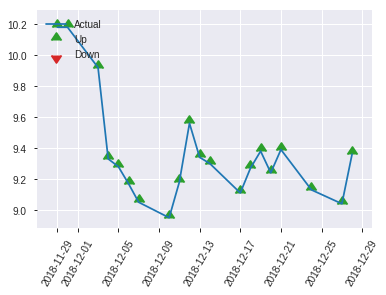


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.252946148941565
RMSE: 0.5029375199182946
LogLoss: 0.6991528782195638
Mean Per-Class Error: 0.4701587301587302
AUC: 0.5131428571428572
pr_auc: 0.5082360066019719
Gini: 0.026285714285714468
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40457162261009216: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    126  1        (126.0/126.0)
1      0    125  0        (0.0/125.0)
Total  0    251  0.502    (126.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.404572     0.664894   250
max f2                       0.404572     0.832224   250
max f0point5                 0.404572     0.553587   250
max accuracy                 0.53586      0.52988    122
max precision                0.63925      1          0
max recall                   0.404572     1          250
max specificity              0.63925      1          0
max absolute_mcc             0.639163     0.0899799  1
max min_per_class_accuracy   0.5343       0.52381    125
max mean_per_class_accuracy  0.53586      0.529841   122

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 53.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.631813           1.33867   1.33867            0.666667         0.637372  0.666667                    0.637372            0.016           0.016                      33.8667   33.8667
    2        0.0239044                   0.628451           0.669333  1.004              0.333333         0.628956  0.5                         0.633164            0.008           0.024                      -33.0667  0.4
    3        0.0318725                   0.620421           0         0.753              0                0.621251  0.375                       0.630186            0               0.024                      -100      -24.7
    4        0.0438247                   0.616713           2.008     1.09527            1                0.617872  0.545455                    0.626827            0.024           0.048                      100.8     9.52727
    5        0.0517928                   0.612299           0         0.926769           0                0.613437  0.461538                    0.624767            0               0.048                      -100      -7.32308
    6        0.103586                    0.603587           1.08123   1.004              0.538462         0.608243  0.5                         0.616505            0.056           0.104                      8.12308   0.4
    7        0.151394                    0.591991           1.004     1.004              0.5              0.597617  0.5                         0.61054             0.048           0.152                      0.4       0.4
    8        0.203187                    0.58444            1.08123   1.02369            0.538462         0.587824  0.509804                    0.60475             0.056           0.208                      8.12308   2.36863
    9        0.302789                    0.562413           1.2048    1.08326            0.6              0.573325  0.539474                    0.594413            0.12            0.328                      20.48     8.32632
    10       0.40239                     0.545802           0.72288   0.994059           0.36             0.554614  0.49505                     0.584562            0.072           0.4                        -27.712   -0.594059
    11       0.501992                    0.5343             1.28512   1.05181            0.64             0.540339  0.52381                     0.575787            0.128           0.528                      28.512    5.18095
    12       0.601594                    0.518464           0.96384   1.03725            0.48             0.525287  0.516556                    0.567426            0.096           0.624                      -3.616    3.7245
    13       0.701195                    0.502023           0.8032    1.004              0.4              0.51      0.5                         0.559269            0.08            0.704                      -19.68    0.4
    14       0.800797                    0.485282           0.96384   0.999005           0.48             0.493087  0.497512                    0.551037            0.096           0.8                        -3.616    -0.0995025
    15       0.900398                    0.46418            1.04416   1.004              0.52             0.473527  0.5                         0.542463            0.104           0.904                      4.416     0.4
    16       1                           0.404572           0.96384   1                  0.48             0.437072  0.498008                    0.531966            0.096         

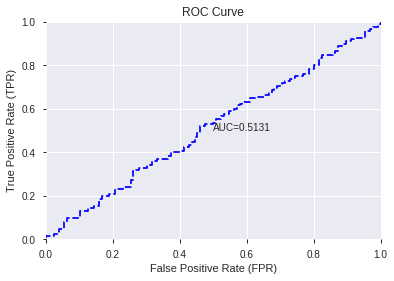

This function is available for GLM models only


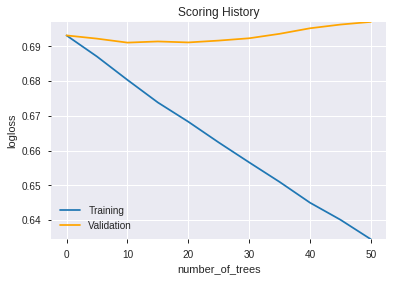

--2019-08-26 20:24:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_202353_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_202353_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ATR_30',
 'BOP',
 'BETA_14',
 'dayofyear',
 'SAREXT',
 'BETA_8',
 'STOCHRSI_fastd',
 'aroonup_20',
 'PLUS_DM_12',
 'ADX_24',
 'HT_DCPERIOD',
 'COS',
 'aroondown_30',
 'CORREL_12',
 'ADXR_14',
 'CORREL_14',
 'COSH',
 'aroonup_24',
 'BETA_12',
 'SIN',
 'AROONOSC_30',
 'MFI_12',
 'aroonup_30',
 'AROONOSC_14',
 'day',
 'VAR_8',
 'ADXR_12',
 'MACDFIX_signal_24',
 'AROONOSC_20',
 'DX_8',
 'MACDFIX_hist_12',
 'DX_14',
 'DX_30',
 'NATR_14',
 'MACDFIX_signal_12',
 'AROONOSC_8',
 'aroonup_12',
 'dayofweek',
 'STOCHRSI_fastk',
 'weekday_name',
 'MACDFIX_signal_20',
 'week',
 'days_in_month']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_202416_model_2  0.536317  0.726397              0.448698  0.513301  0.263478
1  DeepLearning_grid_1_AutoML_20190826_202416_model_1  0.535873  1.975268              0.444635  0.631678  0.399017
2               DeepLearning_1_AutoML_20190826_202416  0.510794  0.841411              0.480190  0.542016  0.293782
3  DeepLearning_grid_1_AutoML_20190826_202416_model_8  0.500000  0.699674              0.500000  0.503233  0.253244
4  DeepLearning_grid_1_AutoML_20190826_202416_model_9  0.500000  0.699778              0.500000  0.503284  0.253295
5  DeepLearning_grid_1_AutoML_20190826_202416_model_7  0.494286  1.135640              0.500000  0.573819  0.329268
6  DeepLearning_grid_1_AutoML_20190826_202416_model_6  0.493746  0.700373              0.500000  0.503613  0.253626
7  DeepLearning_grid_1_AutoML_20190826_202416_model_4  0.493016  1.054432              0.484190  0.589935  0.348023
8  DeepLearning_grid_1_AutoML_20190826_202416_model_5  0.476698  0.704230              0.484190  0.505509  0.255540
9  DeepLearning_grid_1_AutoML_20190826_202416_model_3  0.441968  0.792856              0.492063  0.538761  0.290264

variable  relative_importance  scaled_importance  percentage
0                 weekday_name             1.000000           1.000000    0.002379
1                       SAREXT             0.881899           0.881899    0.002098
2                   aroonup_20             0.866291           0.866291    0.002061
3                          BOP             0.864559           0.864559    0.002057
4                          day             0.812731           0.812731    0.001934
...                        ...                  ...                ...         ...
1035   BBANDS_lowerband_30_1_2             0.325402           0.325402    0.000774
1036                    MIN_24             0.325110           0.325110    0.000774
1037   BBANDS_middleband_8_3_5             0.324963           0.324963    0.000773
1038                    TSF_12             0.322457           0.322457    0.000767
1039  BBANDS_middleband_20_6_2             0.320800           0.320800    0.000763

[1040 rows x 4 columns]

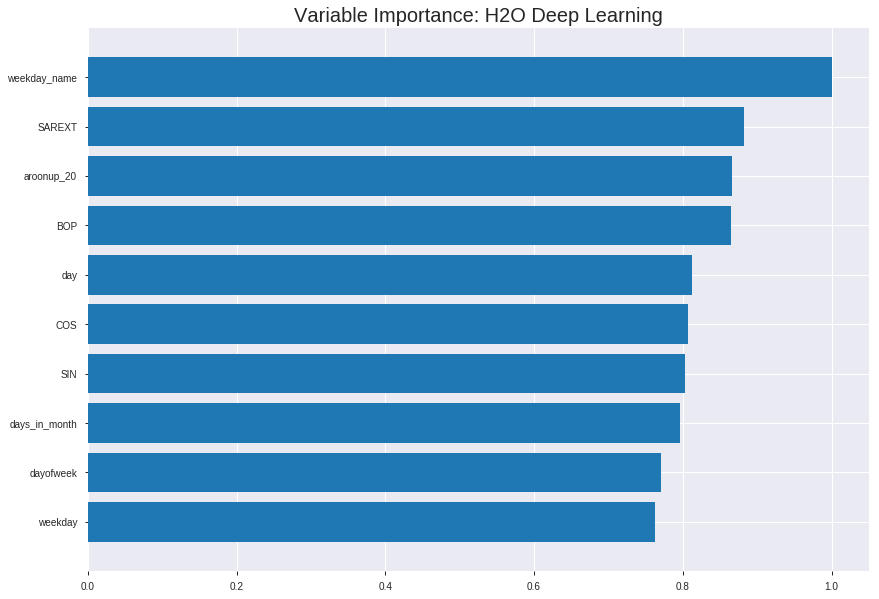

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_202416_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26615863428811937
RMSE: 0.5159056447531073
LogLoss: 0.7357593392083107
Mean Per-Class Error: 0.4548240851411772
AUC: 0.5452820288473808
pr_auc: 0.5446725672670646
Gini: 0.0905640576947615
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22787084603227128: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      21   841   0.9756   (841.0/862.0)
1      9    882   0.0101   (9.0/891.0)
Total  30   1723  0.4849   (850.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.227871     0.674828   384
max f2                       0.160008     0.837879   399
max f0point5                 0.28247      0.567168   363
max accuracy                 0.586413     0.543639   176
max precision                0.968205     1          0
max recall                   0.160008     1          399
max specificity              0.968205     1          0
max absolute_mcc             0.586413     0.0919132  176
max min_per_class_accuracy   0.540613     0.536476   205
max mean_per_class_accuracy  0.586413     0.545176   176

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 54.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.913373           1.09303   1.09303            0.555556         0.935598  0.555556                    0.935598            0.0112233       0.0112233                  9.30291   9.30291
    2        0.0205362                   0.886468           1.53024   1.31163            0.777778         0.899233  0.666667                    0.917416            0.0157127       0.026936                   53.0241   31.1635
    3        0.0302339                   0.865297           0.92586   1.1879             0.470588         0.875672  0.603774                    0.904026            0.00897868      0.0359147                  -7.41401  18.7896
    4        0.040502                    0.849638           1.20233   1.19156            0.611111         0.855853  0.605634                    0.891813            0.0123457       0.0482604                  20.2332   19.1556
    5        0.0501997                   0.830456           1.15732   1.18494            0.588235         0.840862  0.602273                    0.88197             0.0112233       0.0594837                  15.7325   18.4943
    6        0.100399                    0.769374           1.07316   1.12905            0.545455         0.795132  0.573864                    0.838551            0.0538721       0.113356                   7.31558   12.9049
    7        0.150029                    0.731111           1.08549   1.11464            0.551724         0.748471  0.56654                     0.808753            0.0538721       0.167228                   8.54909   11.464
    8        0.200228                    0.699348           1.07316   1.10424            0.545455         0.717849  0.561254                    0.785962            0.0538721       0.2211                     7.31558   10.424
    9        0.300057                    0.647351           1.02308   1.07724            0.52             0.672859  0.547529                    0.748333            0.102132        0.323232                   2.30752   7.72362
    10       0.399886                    0.591089           1.18047   1.10301            0.6              0.619423  0.560628                    0.716151            0.117845        0.441077                   18.0471   10.3008
    11       0.500285                    0.539531           0.961369  1.07458            0.488636         0.563409  0.54618                     0.685498            0.0965208       0.537598                   -3.86313  7.45834
    12       0.600114                    0.49264            0.933135  1.05105            0.474286         0.515377  0.534221                    0.657199            0.0931538       0.630752                   -6.68655  5.10534
    13       0.699943                    0.443493           0.966862  1.03905            0.491429         0.468346  0.528117                    0.630264            0.0965208       0.727273                   -3.31377  3.90457
    14       0.799772                    0.391081           0.865679  1.01741            0.44             0.417125  0.517118                    0.603659            0.0864198       0.813692                   -13.4321  1.74058
    15       0.899601                    0.329222           0.933135  1.00805            0.474286         0.361303  0.512365                    0.576765            0.0931538       0.906846                   -6.68655  0.805419
    16       1                           0.160008           0.927833  1                  0.471591         0.27201   0.508272                    0.546168          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26895682602061755
RMSE: 0.5186104761963621
LogLoss: 0.7405780365481565
Mean Per-Class Error: 0.46655613070203816
AUC: 0.5114040763506956
pr_auc: 0.549734992088309
Gini: 0.02280815270139125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18839318167564398: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    218  0.9909   (218.0/220.0)
1      1    280  0.0036   (1.0/281.0)
Total  3    498  0.4371   (219.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.188393     0.71887    396
max f2                       0.168532     0.864615   399
max f0point5                 0.188393     0.615926   396
max accuracy                 0.188393     0.562874   396
max precision                0.521402     0.589354   208
max recall                   0.168532     1          399
max specificity              0.898316     0.995455   0
max absolute_mcc             0.770858     0.0998822  23
max min_per_class_accuracy   0.52885      0.518182   202
max mean_per_class_accuracy  0.465582     0.533444   269

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 53.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.856815           0.594306  0.594306           0.333333         0.871212  0.333333                    0.871212            0.00711744      0.00711744                 -40.5694   -40.5694
    2        0.0219561                   0.840753           0.713167  0.648334           0.4              0.846547  0.363636                    0.860001            0.00711744      0.0142349                  -28.6833   -35.1666
    3        0.0319361                   0.823143           0.356584  0.557162           0.2              0.831141  0.3125                      0.850982            0.00355872      0.0177936                  -64.3416   -44.2838
    4        0.0419162                   0.791917           1.06975   0.679207           0.6              0.799627  0.380952                    0.838755            0.0106762       0.0284698                  6.97509    -32.0793
    5        0.0518962                   0.783525           0.713167  0.685738           0.4              0.787623  0.384615                    0.828922            0.00711744      0.0355872                  -28.6833   -31.4262
    6        0.101796                    0.716967           1.06975   0.873979           0.6              0.740846  0.490196                    0.785747            0.0533808       0.088968                   6.97509    -12.6021
    7        0.151697                    0.685999           1.14107   0.961837           0.64             0.701146  0.539474                    0.757918            0.0569395       0.145907                   14.1068    -3.81626
    8        0.201597                    0.664404           0.998434  0.970896           0.56             0.678372  0.544554                    0.738228            0.0498221       0.19573                    -0.156584  -2.9104
    9        0.301397                    0.616113           1.03409   0.991822           0.58             0.638659  0.556291                    0.705258            0.103203        0.298932                   3.40925    -0.817798
    10       0.401198                    0.562192           1.14107   1.02895            0.64             0.590083  0.577114                    0.676608            0.113879        0.412811                   14.1068    2.89478
    11       0.500998                    0.529695           1.03409   1.02997            0.58             0.546453  0.577689                    0.650681            0.103203        0.516014                   3.40925    2.99726
    12       0.600798                    0.495411           0.998434  1.02473            0.56             0.510651  0.574751                    0.62742             0.0996441       0.615658                   -0.156584  2.47337
    13       0.700599                    0.462117           1.10541   1.03623            0.62             0.480489  0.581197                    0.60649             0.11032         0.725979                   10.5409    3.62259
    14       0.800399                    0.405987           0.820142  1.00928            0.46             0.43685   0.566085                    0.585338            0.0818505       0.807829                   -17.9858   0.928284
    15       0.9002                      0.331146           0.784484  0.984361           0.44             0.372469  0.552106                    0.561738            0.0782918       0.886121                   -21.5516   -1.56394
    16       1                           0.168532           1.14107   1                  0.64             0.270101  0.560878         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:26:21  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:26:24  2 min  6.544 sec  374 obs/sec       0.439817  1             771        0.663301         5.70691             -0.760352      0.536631        0.437186           0.874423         0.491728                         0.673207           6.03675               -0.84011         0.500315          0.494398             0.891459           0.439122
    2019-08-26 20:26:39  2 min 21.909 sec  384 obs/sec       3.50884   8             6151       0.553913         0.882893            -0.227613      0.540705        0.540418           1.20233          0.487165                         0.60372            1.13368               -0.479848        0.473463          0.554779             0.891459           0.439122
    2019-08-26 20:26:54  2 min 36.607 sec  396 obs/sec       6.59897   15            11568      0.556088         0.966586            -0.237272      0.525014        0.521371           0.874423         0.490017                         0.589499           1.0274                -0.410951        0.478729          0.561034             1.18861            0.427146
    2019-08-26 20:27:10  2 min 52.619 sec  409 obs/sec       10.2299   23            17933      0.554531         1.01213             -0.230355      0.527727        0.516772           1.09303          0.486594                         0.566813           0.961688              -0.304446        0.485563          0.555066             1.18861            0.42515
    2019-08-26 20:27:26  3 min  8.917 sec  412 obs/sec       13.7787   31            24154      0.597061         1.25249             -0.426316      0.531207        0.513905           1.09303          0.484883                         0.638438           1.42092               -0.654946        0.483832          0.543454             0.594306           0.437126
    2019-08-26 20:27:41  3 min 23.702 sec  423 obs/sec       17.3776   39            30463      0.515906         0.735759            -0.064926      0.545282        0.544673           1.09303          0.484883                         0.51861            0.740578              -0.0920161       0.511404          0.549735             0.594306           0.437126
    2019-08-26 20:27:56  3 min 39.372 sec  434 obs/sec       21.3383   48            37406      0.551923         1.07002             -0.218808      0.546466        0.523145           0.983726         0.483742                         0.569504           1.06125               -0.31686         0.468635          0.529929             0.297153           0.431138
    2019-08-26 20:27:58  3 min 40.877 sec  434 obs/sec       21.3383   48            37406      0.515906         0.735759            -0.064926      0.545282        0.544673           1.09303          0.484883                         0.51861            0.740578              -0.0920161       0.511404          0.549735             0.594306           0.437126

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
weekday_name              1.0                    1.0                  0.002379481777867648
SAREXT                    0.8818988800048828     0.8818988800048828   0.002098462314893506
aroonup_20                0.8662905693054199     0.8662905693054199   0.0020613226240008375
BOP                       0.8645585179328918     0.8645585179328918   0.0020572012393215763
day                       0.812731146812439      0.812731146812439    0.0019338789541456748
---                       ---                    ---                  ---
BBANDS_lowerband_30_1_2   0.3254023492336273     0.3254023492336273   0.0007742889604767408
MIN_24                    0.3251096308231354     0.3251096308231354   0.0007735924423529288
BBANDS_middleband_8_3_5   0.3249626159667969     0.3249626159667969   0.0007732426231811956
TSF_12                    0.322457492351532      0.322457492351532    0.0007672817271873668
BBANDS_middleband_20_6_2  0.320800244808197      0.320800244808197    0.0007633383368565854


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.672463768115942)

('auc', 0.5363174603174603)

('logloss', 0.7263971566609752)

('mean_per_class_error', 0.4414920634920635)

('rmse', 0.5133006265639333)

('mse', 0.26347753323092643)

deeplearning prediction progress: |███████████████████████████████████████| 100%


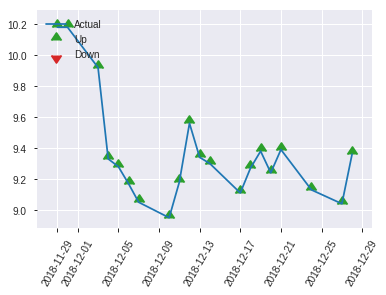


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26347753323092643
RMSE: 0.5133006265639333
LogLoss: 0.7263971566609752
Mean Per-Class Error: 0.4414920634920635
AUC: 0.5363174603174603
pr_auc: 0.5162136770380897
Gini: 0.07263492063492061
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.412982146514374: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   104  0.8254   (104.0/126.0)
1      9    116  0.072    (9.0/125.0)
Total  31   220  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412982     0.672464  219
max f2                       0.257074     0.833333  249
max f0point5                 0.412982     0.577114  219
max accuracy                 0.532531     0.557769  171
max precision                0.896384     1         0
max recall                   0.257074     1         249
max specificity              0.896384     1         0
max absolute_mcc             0.412982     0.155923  219
max min_per_class_accuracy   0.5803       0.5       125
max mean_per_class_accuracy  0.532531     0.558508  171

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 57.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.8598             1.33867   1.33867            0.666667         0.883233  0.666667                    0.883233            0.016           0.016                      33.8667   33.8667
    2        0.0239044                   0.837861           0         0.669333           0                0.848608  0.333333                    0.865921            0               0.016                      -100      -33.0667
    3        0.0318725                   0.820011           1.004     0.753              0.5              0.828441  0.375                       0.856551            0.008           0.024                      0.4       -24.7
    4        0.0438247                   0.785722           2.008     1.09527            1                0.795857  0.545455                    0.839998            0.024           0.048                      100.8     9.52727
    5        0.0517928                   0.776655           1.004     1.08123            0.5              0.779503  0.538462                    0.830691            0.008           0.056                      0.4       8.12308
    6        0.103586                    0.74251            1.08123   1.08123            0.538462         0.759792  0.538462                    0.795242            0.056           0.112                      8.12308   8.12308
    7        0.151394                    0.712641           1.33867   1.16253            0.666667         0.729776  0.578947                    0.774568            0.064           0.176                      33.8667   16.2526
    8        0.203187                    0.698199           0.617846  1.02369            0.307692         0.706707  0.509804                    0.75727             0.032           0.208                      -38.2154  2.36863
    9        0.302789                    0.653983           1.2048    1.08326            0.6              0.676964  0.539474                    0.730854            0.12            0.328                      20.48     8.32632
    10       0.40239                     0.612142           0.72288   0.994059           0.36             0.631102  0.49505                     0.706163            0.072           0.4                        -27.712   -0.594059
    11       0.501992                    0.5803             1.04416   1.004              0.52             0.595938  0.5                         0.684293            0.104           0.504                      4.416     0.4
    12       0.601594                    0.555363           1.12448   1.02395            0.56             0.566157  0.509934                    0.664734            0.112           0.616                      12.448    2.3947
    13       0.701195                    0.526004           1.36544   1.07245            0.68             0.543858  0.534091                    0.647564            0.136           0.752                      36.544    7.24545
    14       0.800797                    0.468884           0.96384   1.05895            0.48             0.500879  0.527363                    0.62932             0.096           0.848                      -3.616    5.89453
    15       0.900398                    0.38066            0.8032    1.03065            0.4              0.432901  0.513274                    0.607592            0.08            0.928                      -19.68    3.06549
    16       1                           0.23816            0.72288   1                  0.36             0.303369  0.498008                    0.577291            0

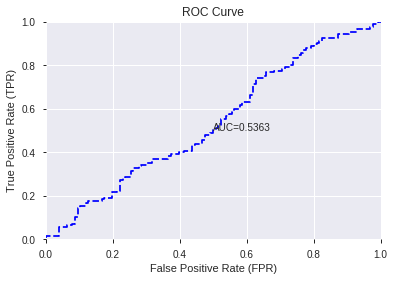

This function is available for GLM models only


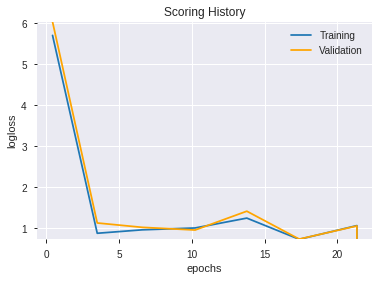

--2019-08-26 20:58:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_202416_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_202416_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'SAREXT',
 'aroonup_20',
 'BOP',
 'day',
 'COS',
 'SIN',
 'days_in_month',
 'dayofweek',
 'weekday',
 'BETA_8',
 'CDLSTALLEDPATTERN',
 'aroondown_12',
 'CDLMORNINGDOJISTAR',
 'AROONOSC_12',
 'CDLLADDERBOTTOM',
 'HT_DCPERIOD',
 'CDLUNIQUE3RIVER',
 'is_month_end',
 'aroondown_14',
 'aroondown_20',
 'aroonup_12',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'MACDEXT_hist',
 'aroondown_8',
 'DX_20',
 'CDLHIKKAKEMOD',
 'DX_8',
 'DX_12',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'aroonup_8',
 'CORREL_14',
 'AROONOSC_14',
 'AROONOSC_20',
 'CDLTHRUSTING',
 'HT_PHASOR_quadrature',
 'CORREL_8',
 'CDLTASUKIGAP',
 'BETA_14',
 'DX_14',
 'aroondown_30',
 'CDL2CROWS',
 'DX_30',
 'ADX_24',
 'DX_24',
 'CDLRICKSHAWMAN',
 'CDLSTICKSANDWICH',
 'STOCHRSI_fastd',
 'quarter',
 'BETA_12',
 'CORREL_12',
 'CDLPIERCING',
 'CDLLONGLEGGEDDOJI',
 'CCI_8',
 'CDLONNECK',
 'BETA_20',
 'week',
 'CDLINVERTEDHAMMER',
 'AROONOSC_8',
 'STOCH_slowd',
 'aroondown_24',
 'STOCHF_fastk',
 'CDLDARKCLOUDCOVER',
 'BETA_2

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_205807_model_1  0.537968  0.690862              0.460413  0.498857  0.248859

variable  relative_importance  scaled_importance    percentage
0                   CDL3INSIDE         8.818429e-03           1.000000  1.539900e-02
1                  CDL3OUTSIDE         7.491794e-03           0.849561  1.308239e-02
2               CDLMORNINGSTAR         7.052002e-03           0.799689  1.231441e-02
3          CDLXSIDEGAP3METHODS         6.514045e-03           0.738685  1.137502e-02
4              CDLLADDERBOTTOM         6.446665e-03           0.731045  1.125736e-02
...                        ...                  ...                ...           ...
1035  BBANDS_middleband_14_5_3         2.239225e-06           0.000254  3.910200e-06
1036                   MA_20_3         2.221849e-06           0.000252  3.879857e-06
1037   BBANDS_lowerband_14_5_2         1.865141e-06           0.000212  3.256964e-06
1038   BBANDS_upperband_14_5_4         3.278868e-07           0.000037  5.725655e-07
1039  BBANDS_middleband_12_6_5         5.747812e-08           0.000007  1.003700e-07

[1040 rows x 4 columns]

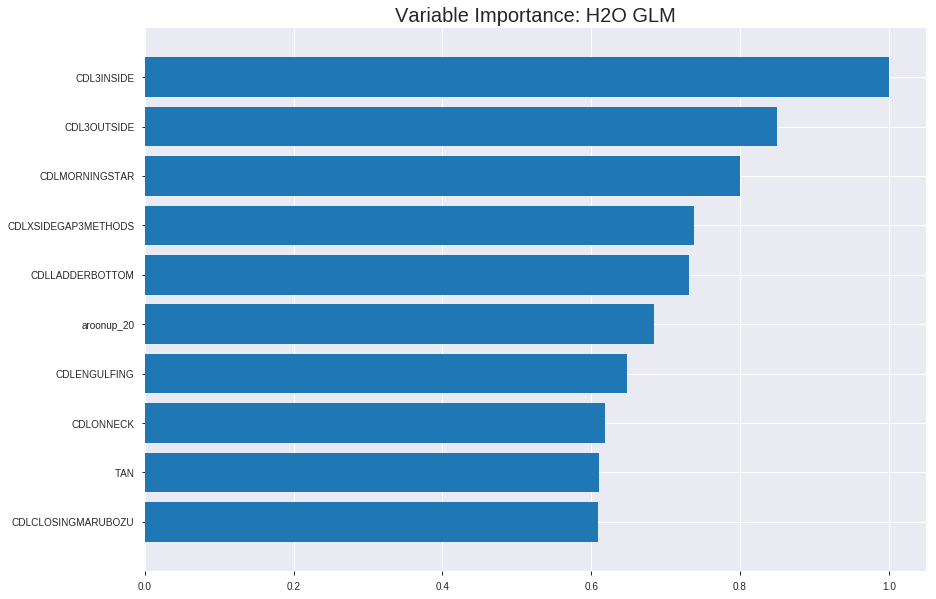

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_205807_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2476532825373303
RMSE: 0.4976477494547024
LogLoss: 0.6884436772919229
Null degrees of freedom: 1752
Residual degrees of freedom: 712
Null deviance: 2429.694244156657
Residual deviance: 2413.6835325854818
AIC: 4495.683532585482
AUC: 0.5693692532439633
pr_auc: 0.570190195389539
Gini: 0.13873850648792652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4703684928400702: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   823   0.9548   (823.0/862.0)
1      14   877   0.0157   (14.0/891.0)
Total  53   1700  0.4775   (837.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470368     0.676959  364
max f2                       0.453498     0.839616  389
max f0point5                 0.48805      0.57735   296
max accuracy                 0.508658     0.549914  192
max precision                0.580101     1         0
max recall                   0.453498     1         389
max specificity              0.580101     1         0
max absolute_mcc             0.48805      0.107543  296
max min_per_class_accuracy   0.510912     0.54321   182
max mean_per_class_accuracy  0.515115     0.55075   159

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.551286           1.53024   1.53024            0.777778         0.556767  0.777778                    0.556767            0.0157127       0.0157127                  53.0241    53.0241
    2        0.0205362                   0.546329           1.31163   1.42094            0.666667         0.548972  0.722222                    0.55287             0.013468        0.0291807                  31.1635    42.0938
    3        0.0302339                   0.543545           1.04159   1.29926            0.529412         0.544667  0.660377                    0.550239            0.010101        0.0392817                  4.15924    29.9261
    4        0.040502                    0.541331           0.874423  1.19156            0.444444         0.542435  0.605634                    0.54826             0.00897868      0.0482604                  -12.5577   19.1556
    5        0.0501997                   0.539722           0.92586   1.14023            0.470588         0.540566  0.579545                    0.546774            0.00897868      0.0572391                  -7.41401   14.0228
    6        0.100399                    0.533846           1.31909   1.22966            0.670455         0.536533  0.625                       0.541654            0.0662177       0.123457                   31.9087    22.9658
    7        0.150029                    0.529298           1.10811   1.18945            0.563218         0.53167   0.604563                    0.538351            0.0549944       0.178451                   10.8105    18.9448
    8        0.200228                    0.5259             1.09551   1.1659             0.556818         0.527481  0.592593                    0.535626            0.0549944       0.233446                   9.55132    16.5898
    9        0.300057                    0.520597           1.10177   1.14456            0.56             0.523024  0.581749                    0.531433            0.109989        0.343434                   10.1773    14.4564
    10       0.399886                    0.515758           1.03432   1.11704            0.525714         0.518051  0.56776                     0.528092            0.103255        0.446689                   3.43178    11.7041
    11       0.500285                    0.510756           0.961369  1.0858             0.488636         0.513338  0.551881                    0.525131            0.0965208       0.54321                    -3.86313   8.58004
    12       0.600114                    0.502442           0.978105  1.06789            0.497143         0.506601  0.542776                    0.522049            0.0976431       0.640853                   -2.18951   6.78852
    13       0.699943                    0.496403           1.00059   1.05829            0.508571         0.499157  0.537897                    0.518784            0.0998878       0.740741                   0.0590027  5.82873
    14       0.799772                    0.490251           0.966862  1.04688            0.491429         0.493386  0.532097                    0.515614            0.0965208       0.837262                   -3.31377   4.68755
    15       0.899601                    0.481696           0.888164  1.02926            0.451429         0.486573  0.523145                    0.512391            0.0886644       0.925926                   -11.1836   2.92633
    16       1                           0.425392           0.737795  1                  0.375            0.47136   0.508272                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25020660989601395
RMSE: 0.5002065672259951
LogLoss: 0.6935653418254446
Null degrees of freedom: 500
Residual degrees of freedom: -540
Null deviance: 692.6521653604563
Residual deviance: 694.9524725090955
AIC: 2776.9524725090955
AUC: 0.45993206082174054
pr_auc: 0.5219636131374688
Gini: -0.08013587835651892
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4591338436273881: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    220  1        (220.0/220.0)
1      0    281  0        (0.0/281.0)
Total  0    501  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459134     0.71867   399
max f2                       0.459134     0.864615  399
max f0point5                 0.459134     0.61488   399
max accuracy                 0.478947     0.560878  362
max precision                0.485799     0.566038  328
max recall                   0.459134     1         399
max specificity              0.56146      0.995455  0
max absolute_mcc             0.533032     0.113956  70
max min_per_class_accuracy   0.517658     0.476868  188
max mean_per_class_accuracy  0.478947     0.509374  362

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.552595           0.594306  0.594306           0.333333         0.556748  0.333333                    0.556748            0.00711744      0.00711744                 -40.5694   -40.5694
    2        0.0219561                   0.551271           0.713167  0.648334           0.4              0.551831  0.363636                    0.554513            0.00711744      0.0142349                  -28.6833   -35.1666
    3        0.0319361                   0.548505           0.713167  0.668594           0.4              0.549865  0.375                       0.55306             0.00711744      0.0213523                  -28.6833   -33.1406
    4        0.0419162                   0.546481           1.06975   0.764108           0.6              0.547402  0.428571                    0.551713            0.0106762       0.0320285                  6.97509    -23.5892
    5        0.0518962                   0.544119           1.06975   0.822885           0.6              0.545016  0.461538                    0.550425            0.0106762       0.0427046                  6.97509    -17.7115
    6        0.101796                    0.537087           0.927117  0.873979           0.52             0.540184  0.490196                    0.545405            0.0462633       0.088968                   -7.28826   -12.6021
    7        0.151697                    0.533969           0.641851  0.797621           0.36             0.535326  0.447368                    0.542089            0.0320285       0.120996                   -35.8149   -20.2379
    8        0.201597                    0.531057           1.06975   0.86498            0.6              0.532385  0.485149                    0.539687            0.0533808       0.174377                   6.97509    -13.502
    9        0.301397                    0.527297           0.998434  0.90917            0.56             0.529144  0.509934                    0.536196            0.0996441       0.274021                   -0.156584  -9.08298
    10       0.401198                    0.522729           0.998434  0.931375           0.56             0.525119  0.522388                    0.533441            0.0996441       0.373665                   -0.156584  -6.86248
    11       0.500998                    0.517019           1.06975   0.95894            0.6              0.519725  0.537849                    0.530709            0.106762        0.480427                   6.97509    -4.106
    12       0.600798                    0.511647           0.927117  0.953654           0.52             0.514365  0.534884                    0.527994            0.0925267       0.572954                   -7.28826   -4.63461
    13       0.700599                    0.505746           1.14107   0.980351           0.64             0.508694  0.549858                    0.525244            0.113879        0.686833                   14.1068    -1.9649
    14       0.800399                    0.493176           1.03409   0.987052           0.58             0.500733  0.553616                    0.522188            0.103203        0.790036                   3.40925    -1.29481
    15       0.9002                      0.481125           1.10541   1.00017            0.62             0.486135  0.560976                    0.518191            0.11032         0.900356                   10.5409    0.0173596
    16       1                           0.459134           0.998434  1                  0.56             0.474269  0.560878        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 20:58:10  0.000 sec   2            2.9       1041          1.37689           1.38713
    2019-08-26 20:58:13  2.191 sec   4            2.1       1041          1.3745            1.38774
    2019-08-26 20:58:15  4.386 sec   6            1.5       1041          1.37159           1.38868
    2019-08-26 20:58:17  6.589 sec   8            1.1       1041          1.3681            1.38999
    2019-08-26 20:58:19  8.747 sec   10           0.81      1041          1.36406           1.39178

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.6777777777777777)

('auc', 0.537968253968254)

('logloss', 0.6908622264821165)

('mean_per_class_error', 0.4526031746031747)

('rmse', 0.49885727856003703)

('mse', 0.24885858437232639)

glm prediction progress: |████████████████████████████████████████████████| 100%


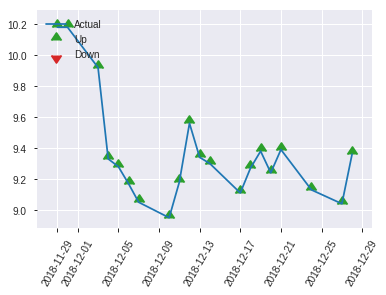


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24885858437232639
RMSE: 0.49885727856003703
LogLoss: 0.6908622264821165
Null degrees of freedom: 250
Residual degrees of freedom: -790
Null deviance: 348.0616751555067
Residual deviance: 346.81283769402245
AIC: 2428.8128376940226
AUC: 0.537968253968254
pr_auc: 0.5178667468416044
Gini: 0.07593650793650797
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4751251697049259: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   113  0.8968   (113.0/126.0)
1      3    122  0.024    (3.0/125.0)
Total  16   235  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475125     0.677778  234
max f2                       0.454375     0.833333  249
max f0point5                 0.477484     0.57561   224
max accuracy                 0.483893     0.545817  216
max precision                0.52483      0.6875    15
max recall                   0.454375     1         249
max specificity              0.541851     0.992063  0
max absolute_mcc             0.475125     0.162044  234
max min_per_class_accuracy   0.506834     0.507937  125
max mean_per_class_accuracy  0.477484     0.547397  224

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.538371           0         0                  0                0.540611  0                           0.540611            0               0                          -100      -100
    2        0.0239044                   0.532434           2.008     1.004              1                0.534347  0.5                         0.537479            0.024           0.024                      100.8     0.4
    3        0.0318725                   0.528221           0         0.753              0                0.528576  0.375                       0.535253            0               0.024                      -100      -24.7
    4        0.0438247                   0.527224           2.008     1.09527            1                0.527665  0.545455                    0.533184            0.024           0.048                      100.8     9.52727
    5        0.0517928                   0.525545           2.008     1.23569            1                0.526013  0.615385                    0.532081            0.016           0.064                      100.8     23.5692
    6        0.103586                    0.518917           1.23569   1.23569            0.615385         0.521801  0.615385                    0.526941            0.064           0.128                      23.5692   23.5692
    7        0.151394                    0.516968           0.502     1.004              0.25             0.517754  0.5                         0.52404             0.024           0.152                      -49.8     0.4
    8        0.203187                    0.514891           0.926769  0.984314           0.461538         0.515959  0.490196                    0.52198             0.048           0.2                        -7.32308  -1.56863
    9        0.302789                    0.51158            1.28512   1.08326            0.64             0.513401  0.539474                    0.519158            0.128           0.328                      28.512    8.32632
    10       0.40239                     0.50901            1.04416   1.07358            0.52             0.51011   0.534653                    0.516918            0.104           0.432                      4.416     7.35842
    11       0.501992                    0.506834           0.8032    1.01994            0.4              0.507979  0.507937                    0.515145            0.08            0.512                      -19.68    1.99365
    12       0.601594                    0.50366            1.04416   1.02395            0.52             0.505369  0.509934                    0.513526            0.104           0.616                      4.416     2.3947
    13       0.701195                    0.499407           1.12448   1.03823            0.56             0.50147   0.517045                    0.511814            0.112           0.728                      12.448    3.82273
    14       0.800797                    0.494711           0.96384   1.02898            0.48             0.49702   0.512438                    0.509974            0.096           0.824                      -3.616    2.89751
    15       0.900398                    0.476935           1.2048    1.04842            0.6              0.486265  0.522124                    0.507351            0.12            0.944                      20.48     4.84248
    16       1                           0.449698           0.56224   1                  0.28             0.471691  0.498008                    0.503799            0.056     

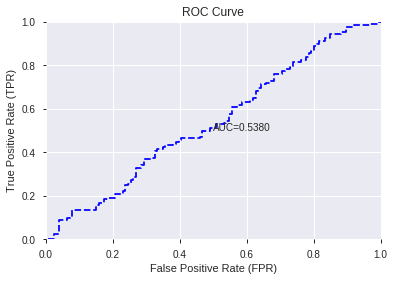

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


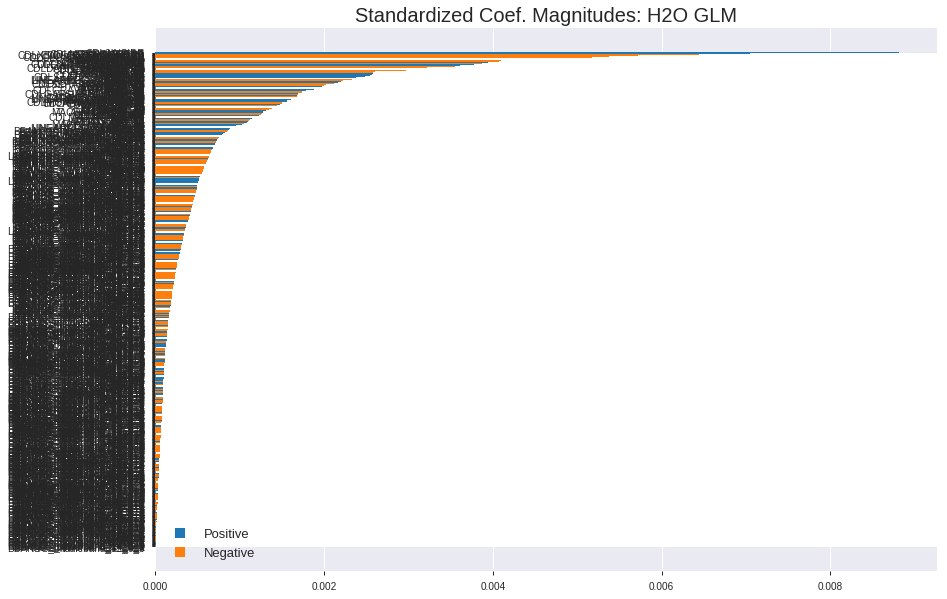

'log_likelihood'
--2019-08-26 20:58:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.152
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.152|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_205807_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_205807_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDL3INSIDE',
 'CDL3OUTSIDE',
 'CDLMORNINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLLADDERBOTTOM',
 'aroonup_20',
 'CDLENGULFING',
 'CDLONNECK',
 'TAN',
 'CDLCLOSINGMARUBOZU',
 'CDLTASUKIGAP',
 'CDLINVERTEDHAMMER',
 'MACDEXT_hist',
 'HT_DCPERIOD',
 'CDLHIGHWAVE',
 'weekday_name',
 'aroondown_12',
 'COSH',
 'SINH',
 'EXP',
 'is_quarter_end',
 'CDL3LINESTRIKE',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLPIERCING',
 'HT_TRENDMODE',
 'CDLUNIQUE3RIVER',
 'ADXR_14',
 'BOP',
 'CORREL_14',
 'is_month_end',
 'MINUS_DI_30',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'BETA_30',
 'ADX_20',
 'AROONOSC_12',
 'ADX_24',
 'CORREL_12',
 'AROONOSC_20',
 'MINUS_DI_24',
 'is_month_start',
 'ROCR_24',
 'ROCR100_24',
 'SAREXT',
 'ROC_24',
 'CDLHANGINGMAN',
 'ROCP_24',
 'ADXR_12',
 'RSI_30',
 'CMO_30',
 'CDLSTALLEDPATTERN',
 'CMO_8',
 'RSI_8',
 'LINEARREG_SLOPE_20',
 'LINEARREG_ANGLE_20',
 'CDLSHORTLINE',
 'CORREL_8',
 'dayofyear',
 'aroondown_30',
 'aroondown_8',
 'Volume',
 'month',
 'CDLSTICKSANDWICH',
 '

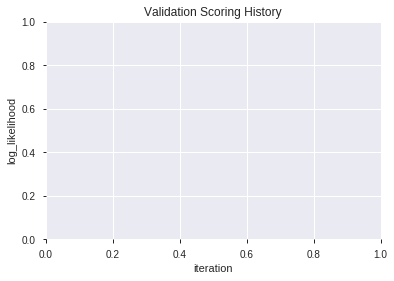

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_205846_model_6  0.536000  0.697776              0.436730  0.502153  0.252157
1  XGBoost_grid_1_AutoML_20190826_205846_model_4  0.534159  0.699960              0.496032  0.503224  0.253234
2               XGBoost_2_AutoML_20190826_205846  0.516444  0.716374              0.492063  0.510603  0.260715
3  XGBoost_grid_1_AutoML_20190826_205846_model_2  0.510286  0.705933              0.492063  0.506003  0.256040
4  XGBoost_grid_1_AutoML_20190826_205846_model_7  0.509651  0.714513              0.480190  0.509794  0.259890
5  XGBoost_grid_1_AutoML_20190826_205846_model_5  0.500127  0.747140              0.468349  0.521924  0.272405
6  XGBoost_grid_1_AutoML_20190826_205846_model_3  0.494730  0.702535              0.444444  0.504457  0.254476
7               XGBoost_3_AutoML_20190826_205846  0.481651  0.712851              0.480159  0.509156  0.259240
8  XGBoost_grid_1_AutoML_20190826_205846_model_1  0.480635  0.707906              0.468286  0.507052  0.257102
9               XGBoost_1_AutoML_20190826_205846  0.468952  0.724548              0.484159  0.514835  0.265055

variable  relative_importance  scaled_importance  percentage
0       HT_PHASOR_quadrature           143.051682           1.000000    0.019993
1                     BETA_8           134.789047           0.942240    0.018838
2                        BOP           112.992813           0.789874    0.015792
3                      ADOSC           112.482758           0.786309    0.015721
4                HT_DCPERIOD            95.131042           0.665012    0.013296
..                       ...                  ...                ...         ...
348  BBANDS_lowerband_20_3_5             3.281504           0.022939    0.000459
349  BBANDS_lowerband_12_5_2             3.197632           0.022353    0.000447
350  BBANDS_upperband_14_0_3             3.048443           0.021310    0.000426
351               PLUS_DM_24             2.480300           0.017338    0.000347
352  BBANDS_upperband_12_7_2             2.128310           0.014878    0.000297

[353 rows x 4 columns]

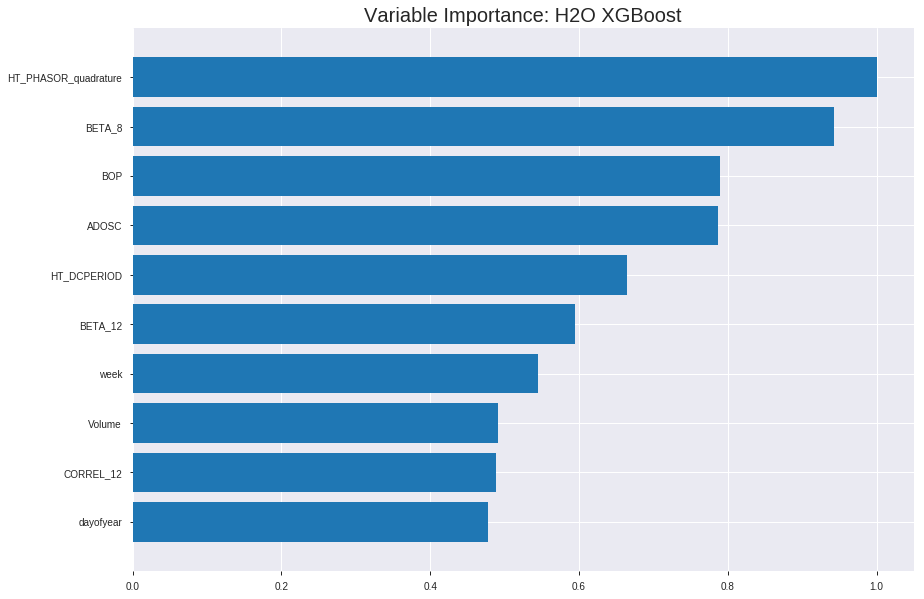

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_205846_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17767771275937005
RMSE: 0.42151834213871414
LogLoss: 0.5446274421769337
Mean Per-Class Error: 0.11762052075277141
AUC: 0.9507559482424138
pr_auc: 0.9521337820403234
Gini: 0.9015118964848277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5032461643218994: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      755  107  0.1241   (107.0/862.0)
1      99   792  0.1111   (99.0/891.0)
Total  854  899  0.1175   (206.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503246     0.884916  197
max f2                       0.451914     0.922865  249
max f0point5                 0.550977     0.894095  148
max accuracy                 0.503246     0.882487  197
max precision                0.746026     1         0
max recall                   0.37569      1         323
max specificity              0.746026     1         0
max absolute_mcc             0.503246     0.764906  197
max min_per_class_accuracy   0.505982     0.881671  195
max mean_per_class_accuracy  0.503246     0.882379  197

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.718568           1.96745    1.96745            1                0.730623  1                           0.730623            0.020202        0.020202                   96.7452   96.7452
    2        0.0205362                   0.710504           1.96745    1.96745            1                0.713803  1                           0.722213            0.020202        0.040404                   96.7452   96.7452
    3        0.0302339                   0.700996           1.96745    1.96745            1                0.706234  1                           0.717088            0.0190797       0.0594837                  96.7452   96.7452
    4        0.040502                    0.692365           1.96745    1.96745            1                0.696763  1                           0.711935            0.020202        0.0796857                  96.7452   96.7452
    5        0.0501997                   0.683765           1.96745    1.96745            1                0.687818  1                           0.707276            0.0190797       0.0987654                  96.7452   96.7452
    6        0.100399                    0.650498           1.96745    1.96745            1                0.666462  1                           0.686869            0.0987654       0.197531                   96.7452   96.7452
    7        0.150029                    0.630274           1.96745    1.96745            1                0.64073   1                           0.671606            0.0976431       0.295174                   96.7452   96.7452
    8        0.200228                    0.613329           1.94509    1.96185            0.988636         0.621387  0.997151                    0.659016            0.0976431       0.392817                   94.5095   96.1847
    9        0.300057                    0.57876            1.79881    1.90761            0.914286         0.595411  0.969582                    0.637854            0.179574        0.572391                   79.8814   90.7606
    10       0.399886                    0.547929           1.6639     1.84677            0.845714         0.563883  0.938659                    0.619388            0.166105        0.738496                   66.3903   84.6767
    11       0.500285                    0.508067           1.33027    1.74311            0.676136         0.52935   0.885975                    0.601319            0.133558        0.872054                   33.0266   74.3113
    12       0.600114                    0.470193           0.742011   1.57658            0.377143         0.488894  0.801331                    0.582617            0.0740741       0.946128                   -25.7989  57.658
    13       0.699943                    0.436634           0.382248   1.40624            0.194286         0.4538    0.714751                    0.564244            0.0381594       0.984287                   -61.7752  40.6239
    14       0.799772                    0.404597           0.123668   1.24615            0.0628571        0.420971  0.633381                    0.546361            0.0123457       0.996633                   -87.6332  24.6147
    15       0.899601                    0.364433           0.0337278  1.1116             0.0171429        0.386258  0.564997                    0.528594            0.003367        1                          -96.6272  11.1604
    16       1                           0.247954           0          1                  0                0.322164  0.508272                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2557182114792358
RMSE: 0.5056858822225867
LogLoss: 0.7049330757539672
Mean Per-Class Error: 0.48147039792947266
AUC: 0.4950258815917179
pr_auc: 0.5615023715875737
Gini: -0.009948236816564204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27236756682395935: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    219  0.9955   (219.0/220.0)
1      0    281  0        (0.0/281.0)
Total  1    500  0.4371   (219.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.272368     0.71959    398
max f2                       0.272368     0.865148   398
max f0point5                 0.272368     0.615958   398
max accuracy                 0.341043     0.562874   392
max precision                0.651587     0.636364   9
max recall                   0.272368     1          398
max specificity              0.686611     0.995455   0
max absolute_mcc             0.360426     0.0692156  384
max min_per_class_accuracy   0.508495     0.477273   200
max mean_per_class_accuracy  0.562486     0.51853    105

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 50.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.659726           0.891459  0.891459           0.5              0.671399  0.5                         0.671399            0.0106762       0.0106762                  -10.8541   -10.8541
    2        0.0219561                   0.651587           1.42633   1.13458            0.8              0.653409  0.636364                    0.663221            0.0142349       0.024911                   42.6335    13.4584
    3        0.0319361                   0.638495           0.356584  0.891459           0.2              0.642714  0.5                         0.656813            0.00355872      0.0284698                  -64.3416   -10.8541
    4        0.0419162                   0.631883           1.78292   1.10371            1                0.633348  0.619048                    0.651226            0.0177936       0.0462633                  78.2918    10.3711
    5        0.0518962                   0.625871           0.356584  0.960033           0.2              0.628884  0.538462                    0.646929            0.00355872      0.0498221                  -64.3416   -3.99672
    6        0.101796                    0.601719           1.14107   1.04878            0.64             0.613159  0.588235                    0.630375            0.0569395       0.106762                   14.1068    4.87754
    7        0.151697                    0.586319           1.06975   1.05568            0.6              0.592921  0.592105                    0.618055            0.0533808       0.160142                   6.97509    5.56752
    8        0.201597                    0.570794           0.927117  1.02385            0.52             0.577205  0.574257                    0.607943            0.0462633       0.206406                   -7.28826   2.3854
    9        0.301397                    0.547444           0.998434  1.01544            0.56             0.559731  0.569536                    0.591979            0.0996441       0.30605                    -0.156584  1.54368
    10       0.401198                    0.530285           0.891459  0.984597           0.5              0.537672  0.552239                    0.57847             0.088968        0.395018                   -10.8541   -1.54034
    11       0.500998                    0.508334           0.891459  0.966043           0.5              0.518702  0.541833                    0.566564            0.088968        0.483986                   -10.8541   -3.39567
    12       0.600798                    0.487322           0.962776  0.965501           0.54             0.496693  0.541528                    0.554957            0.0960854       0.580071                   -3.72242   -3.44995
    13       0.700599                    0.464773           1.14107   0.99051            0.64             0.47656   0.555556                    0.54379             0.113879        0.69395                    14.1068    -0.948992
    14       0.800399                    0.438808           1.14107   1.00928            0.64             0.451835  0.566085                    0.532324            0.113879        0.807829                   14.1068    0.928284
    15       0.9002                      0.395589           0.962776  1.00413            0.54             0.418896  0.563193                    0.519749            0.0960854       0.903915                   -3.72242   0.412685
    16       1                           0.233943           0.962776  1                  0.54             0.365385  0.560878           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:59:25  24.222 sec  0                  0.5              0.693147            0.5             0                  1                0.491728                         0.5                0.693147              0.5               0                    1                  0.439122
    2019-08-26 20:59:26  24.851 sec  5                  0.489624         0.672571            0.766735        0.774019           1.96745          0.318311                         0.500855           0.694857              0.469945          0.542875             1.42633            0.433134
    2019-08-26 20:59:26  25.066 sec  10                 0.479062         0.651949            0.828906        0.840066           1.96745          0.261266                         0.501567           0.696302              0.492891          0.559696             0.891459           0.43513
    2019-08-26 20:59:26  25.270 sec  15                 0.470373         0.635226            0.866265        0.873233           1.96745          0.241871                         0.50142            0.696018              0.496732          0.553673             0.891459           0.433134
    2019-08-26 20:59:27  25.469 sec  20                 0.462499         0.620258            0.891348        0.89969            1.96745          0.20308                          0.502716           0.698657              0.496546          0.559068             0.891459           0.433134
    2019-08-26 20:59:27  25.694 sec  25                 0.454854         0.605876            0.913647        0.919223           1.96745          0.171706                         0.503142           0.699543              0.492155          0.559155             1.18861            0.437126
    2019-08-26 20:59:27  25.931 sec  30                 0.448821         0.594568            0.918176        0.921776           1.96745          0.166001                         0.502993           0.699255              0.493028          0.557318             0.891459           0.437126
    2019-08-26 20:59:27  26.151 sec  35                 0.442314         0.582484            0.929706        0.932948           1.96745          0.146606                         0.50506            0.703459              0.483808          0.553755             1.18861            0.437126
    2019-08-26 20:59:27  26.373 sec  40                 0.436012         0.57086             0.934986        0.938151           1.96745          0.142613                         0.504343           0.702001              0.496684          0.571002             1.18861            0.433134
    2019-08-26 20:59:28  26.633 sec  45                 0.428493         0.557128            0.943311        0.945194           1.96745          0.136908                         0.505109           0.703668              0.496854          0.566796             0.594306           0.437126
    2019-08-26 20:59:28  26.884 sec  50                 0.421518         0.544627            0.950756        0.952134           1.96745          0.117513                         0.505686           0.704933              0.495026          0.561502             0.891459           0.437126

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_quadrature     143.0516815185547      1.0                   0.019993111321238866
BETA_8                   134.78904724121094     0.9422402156365283    0.018838313522569226
BOP                      112.99281311035156     0.7898740644701593    0.0157920401007113
ADOSC                    112.48275756835938     0.7863085311148171    0.015720753995418356
HT_DCPERIOD              95.13104248046875      0.6650117039563053    0.013295653027125156
---                      ---                    ---                   ---
BBANDS_lowerband_20_3_5  3.281503677368164      0.022939287693325944  0.00045862773248259034
BBANDS_lowerband_12_5_2  3.197632312774658      0.022352986548850217  0.0004469057484333174
BBANDS_upperband_14_0_3  3.04844331741333       0.021310083775687237  0.0004260548771922412
PLUS_DM_24               2.480299949645996      0.017338488602975884  0.00034665033278132815
BBANDS_upperband_12_7_2  2.128310203552246      0.014877911122465143  0.0002974557332989435


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6820809248554914)

('auc', 0.536)

('logloss', 0.6977755390438009)

('mean_per_class_error', 0.43673015873015875)

('rmse', 0.5021528259894195)

('mse', 0.25215746064916017)

xgboost prediction progress: |████████████████████████████████████████████| 100%


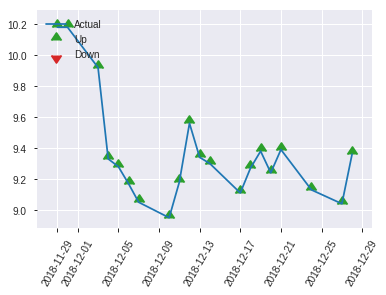


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25215746064916017
RMSE: 0.5021528259894195
LogLoss: 0.6977755390438009
Mean Per-Class Error: 0.43673015873015875
AUC: 0.536
pr_auc: 0.5389215162527259
Gini: 0.07200000000000006
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48385491967201233: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   103  0.8175   (103.0/126.0)
1      7    118  0.056    (7.0/125.0)
Total  30   221  0.4382   (110.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483855     0.682081  220
max f2                       0.432121     0.836707  240
max f0point5                 0.483855     0.584737  220
max accuracy                 0.483855     0.561753  220
max precision                0.700484     0.888889  8
max recall                   0.405317     1         246
max specificity              0.730301     0.992063  0
max absolute_mcc             0.483855     0.195034  220
max min_per_class_accuracy   0.563423     0.512     124
max mean_per_class_accuracy  0.483855     0.56327   220

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 56.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.720019           1.33867   1.33867            0.666667         0.725172  0.666667                    0.725172            0.016           0.016                      33.8667   33.8667
    2        0.0239044                   0.707132           2.008     1.67333            1                0.712258  0.833333                    0.718715            0.024           0.04                       100.8     67.3333
    3        0.0318725                   0.701286           2.008     1.757              1                0.703854  0.875                       0.715               0.016           0.056                      100.8     75.7
    4        0.0438247                   0.688954           0.669333  1.46036            0.333333         0.694856  0.727273                    0.709506            0.008           0.064                      -33.0667  46.0364
    5        0.0517928                   0.684285           0         1.23569            0                0.685211  0.615385                    0.705768            0               0.064                      -100      23.5692
    6        0.103586                    0.663641           1.08123   1.15846            0.538462         0.671699  0.576923                    0.688734            0.056           0.12                       8.12308   15.8462
    7        0.151394                    0.646182           1.004     1.10968            0.5              0.651638  0.552632                    0.677019            0.048           0.168                      0.4       10.9684
    8        0.203187                    0.624297           1.08123   1.10243            0.538462         0.634333  0.54902                     0.666139            0.056           0.224                      8.12308   10.2431
    9        0.302789                    0.600169           1.2048    1.13611            0.6              0.611864  0.565789                    0.648285            0.12            0.344                      20.48     13.6105
    10       0.40239                     0.579376           0.72288   1.03382            0.36             0.588842  0.514851                    0.633571            0.072           0.416                      -27.712   3.38218
    11       0.501992                    0.562931           0.96384   1.01994            0.48             0.569807  0.507937                    0.62092             0.096           0.512                      -3.616    1.99365
    12       0.601594                    0.545426           0.88352   0.997351           0.44             0.5549    0.496689                    0.609989            0.088           0.6                        -11.648   -0.264901
    13       0.701195                    0.530017           1.2048    1.02682            0.6              0.537344  0.511364                    0.599671            0.12            0.72                       20.48     2.68182
    14       0.800797                    0.509214           1.04416   1.02898            0.52             0.516184  0.512438                    0.589287            0.104           0.824                      4.416     2.89751
    15       0.900398                    0.473087           1.28512   1.05731            0.64             0.494532  0.526549                    0.578805            0.128           0.952                      28.512    5.73097
    16       1                           0.349752           0.48192   1                  0.24             0.432936  0.498008                    0.564276          

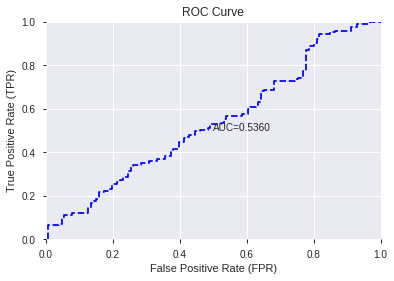

This function is available for GLM models only


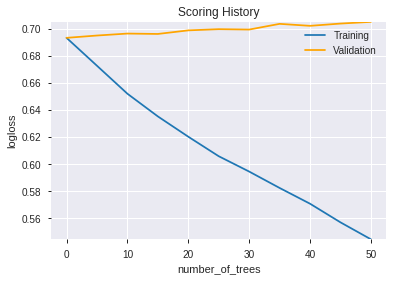

--2019-08-26 20:59:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_205846_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_205846_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_quadrature',
 'BETA_8',
 'BOP',
 'ADOSC',
 'HT_DCPERIOD',
 'BETA_12',
 'week',
 'Volume',
 'CORREL_12',
 'dayofyear',
 'STOCHF_fastk',
 'DX_20',
 'DIV',
 'MFI_14',
 'CORREL_8',
 'OBV',
 'CORREL_20',
 'TAN',
 'PLUS_DM_8',
 'HT_PHASOR_inphase',
 'STOCH_slowd',
 'BETA_14',
 'SAREXT',
 'ADXR_14',
 'STOCHRSI_fastd',
 'AROONOSC_24',
 'CCI_8',
 'CORREL_24',
 'MINUS_DM_12',
 'BETA_24',
 'CORREL_30',
 'DX_8',
 'SIN',
 'TRANGE',
 'DX_24',
 'PLUS_DI_8',
 'day',
 'COS',
 'ADXR_12',
 'STDDEV_30',
 'BETA_20',
 'WILLR_14',
 'MFI_24',
 'PPO',
 'PLUS_DM_30',
 'MINUS_DI_8',
 'PLUS_DM_12',
 'STOCH_slowk',
 'MFI_30',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_8',
 'aroonup_30',
 'WILLR_12',
 'weekday_name',
 'CCI_14',
 'CORREL_14',
 'CCI_30',
 'ROC_30',
 'BETA_30',
 'BBANDS_lowerband_24_6_4',
 'CMO_8',
 'AD',
 'BBANDS_upperband_30_7_5',
 'MACDFIX_hist_8',
 'ROC_20',
 'AROONOSC_20',
 'ADX_24',
 'CCI_24',
 'TRIX_12',
 'PLUS_DM_20',
 'BBANDS_upperband_14_3_4',
 'PLUS_DM_14',
 'MACDEXT_hist',
 'STDDEV_8',
 

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

971

['TEMA_8',
 'TRIMA_8',
 'WMA_8',
 'MA_8_0',
 'MAVP_8_0',
 'T3_8_0',
 'BBANDS_upperband_8_0_2',
 'BBANDS_middleband_8_0_2',
 'BBANDS_lowerband_8_0_2',
 'BBANDS_upperband_8_0_3',
 'BBANDS_middleband_8_0_3',
 'BBANDS_lowerband_8_0_3',
 'BBANDS_upperband_8_0_4',
 'BBANDS_middleband_8_0_4',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_upperband_8_0_5',
 'BBANDS_middleband_8_0_5',
 'BBANDS_lowerband_8_0_5',
 'MA_8_1',
 'MAVP_8_1',
 'T3_8_1',
 'BBANDS_upperband_8_1_2',
 'BBANDS_middleband_8_1_2',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_upperband_8_1_3',
 'BBANDS_middleband_8_1_3',
 'BBANDS_lowerband_8_1_3',
 'BBANDS_upperband_8_1_4',
 'BBANDS_middleband_8_1_4',
 'BBANDS_lowerband_8_1_4',
 'BBANDS_upperband_8_1_5',
 'BBANDS_middleband_8_1_5',
 'BBANDS_lowerband_8_1_5',
 'MA_8_2',
 'MAVP_8_2',
 'T3_8_2',
 'BBANDS_upperband_8_2_2',
 'BBANDS_middleband_8_2_2',
 'BBANDS_lowerband_8_2_2',
 'BBANDS_upperband_8_2_3',
 'BBANDS_middleband_8_2_3',
 'BBANDS_lowerband_8_2_3',
 'BBANDS_upperband_8_2_4',
 'BBANDS_middle

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_210046_model_3  0.526286  0.729395              0.476349  0.514053  0.264250
1  DeepLearning_grid_1_AutoML_20190826_210046_model_5  0.511175  0.699031              0.500000  0.502786  0.252794
2  DeepLearning_grid_1_AutoML_20190826_210046_model_1  0.505810  1.956691              0.488127  0.636171  0.404714
3  DeepLearning_grid_1_AutoML_20190826_210046_model_6  0.504286  0.704205              0.500000  0.505472  0.255502
4  DeepLearning_grid_1_AutoML_20190826_210046_model_8  0.500000  0.703056              0.500000  0.504885  0.254909
5  DeepLearning_grid_1_AutoML_20190826_210046_model_9  0.500000  0.699790              0.500000  0.503291  0.253301
6  DeepLearning_grid_1_AutoML_20190826_210046_model_7  0.488571  1.250886              0.500000  0.595789  0.354964
7               DeepLearning_1_AutoML_20190826_210046  0.483683  0.878621              0.500000  0.523185  0.273723
8  DeepLearning_grid_1_AutoML_20190826_210046_model_4  0.476444  1.244370              0.492095  0.618988  0.383147
9  DeepLearning_grid_1_AutoML_20190826_210046_model_2  0.426540  0.823525              0.500000  0.546693  0.298874

variable  relative_importance  scaled_importance  percentage
0          CDLMORNINGDOJISTAR             1.000000           1.000000    0.003131
1             CDLLADDERBOTTOM             0.948155           0.948155    0.002969
2           CDLSTALLEDPATTERN             0.942794           0.942794    0.002952
3              CDLEVENINGSTAR             0.932409           0.932409    0.002919
4              CDLMORNINGSTAR             0.927320           0.927320    0.002904
..                        ...                  ...                ...         ...
966                    TSF_30             0.269518           0.269518    0.000844
967                 MAVP_24_0             0.268042           0.268042    0.000839
968  BBANDS_middleband_12_0_4             0.267652           0.267652    0.000838
969  BBANDS_middleband_20_7_3             0.264289           0.264289    0.000828
970   BBANDS_upperband_14_1_2             0.261766           0.261766    0.000820

[971 rows x 4 columns]

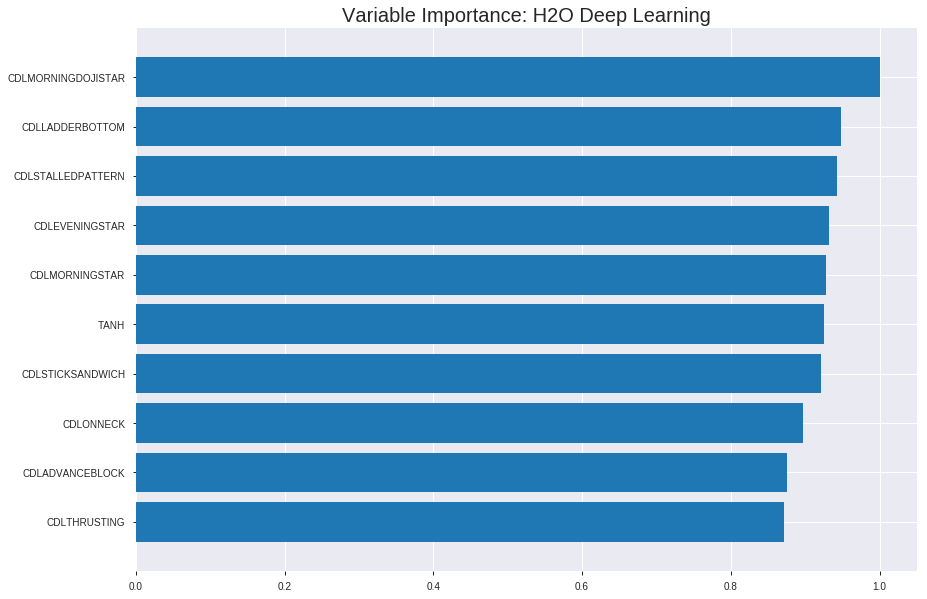

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_210046_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26423545190157643
RMSE: 0.5140383759035666
LogLoss: 0.7355438049912565
Mean Per-Class Error: 0.4387924097900896
AUC: 0.5644274662062752
pr_auc: 0.5520227982761858
Gini: 0.1288549324125503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3112986402747414: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      11   851   0.9872   (851.0/862.0)
1      4    887   0.0045   (4.0/891.0)
Total  15   1738  0.4877   (855.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311299     0.674781  388
max f2                       0.250416     0.838036  398
max f0point5                 0.478178     0.581806  284
max accuracy                 0.562967     0.561894  221
max precision                0.966329     1         0
max recall                   0.250416     1         398
max specificity              0.966329     1         0
max absolute_mcc             0.478178     0.126055  284
max min_per_class_accuracy   0.581717     0.555556  207
max mean_per_class_accuracy  0.562967     0.561208  221

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 59.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.917989           1.20233   1.20233            0.611111         0.933578  0.611111                    0.933578            0.0123457       0.0123457                  20.2332   20.2332
    2        0.0205362                   0.904344           1.31163   1.25698            0.666667         0.90937   0.638889                    0.921474            0.013468        0.0258137                  31.1635   25.6983
    3        0.0302339                   0.89403            0.810127  1.11365            0.411765         0.897778  0.566038                    0.913873            0.00785634      0.03367                    -18.9873  11.3652
    4        0.040502                    0.882049           1.20233   1.13613            0.611111         0.888578  0.577465                    0.90746             0.0123457       0.0460157                  20.2332   13.6134
    5        0.0501997                   0.867137           1.04159   1.11787            0.529412         0.875312  0.568182                    0.90125             0.010101        0.0561167                  4.15924   11.7871
    6        0.100399                    0.818446           1.11787   1.11787            0.568182         0.842044  0.568182                    0.871647            0.0561167       0.112233                   11.7871   11.7871
    7        0.150029                    0.772984           1.10811   1.11464            0.563218         0.794776  0.56654                     0.846218            0.0549944       0.167228                   10.8105   11.464
    8        0.200228                    0.735284           0.916654  1.065              0.465909         0.751937  0.541311                    0.822581            0.0460157       0.213244                   -8.33461  6.50027
    9        0.300057                    0.675988           1.07929   1.06976            0.548571         0.702729  0.543726                    0.782706            0.107744        0.320988                   7.92881   6.97554
    10       0.399886                    0.626115           1.14674   1.08898            0.582857         0.652412  0.553495                    0.750179            0.114478        0.435466                   14.6744   8.8975
    11       0.500285                    0.581029           1.2073    1.11272            0.613636         0.602212  0.565564                    0.720484            0.121212        0.556678                   20.73     11.2721
    12       0.600114                    0.532745           0.933135  1.08285            0.474286         0.557701  0.55038                     0.693405            0.0931538       0.649832                   -6.68655  8.28468
    13       0.699943                    0.485375           1.0568    1.07913            0.537143         0.507595  0.548492                    0.666904            0.105499        0.755331                   5.6803    7.91324
    14       0.799772                    0.443032           0.854436  1.05109            0.434286         0.46488   0.534237                    0.641687            0.0852974       0.840629                   -14.5564  5.10854
    15       0.899601                    0.394146           0.809466  1.02427            0.411429         0.418054  0.520609                    0.616871            0.0808081       0.921437                   -19.0534  2.42729
    16       1                           0.248328           0.782509  1                  0.397727         0.353762  0.508272                    0.590455           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2826149496632555
RMSE: 0.53161541518588
LogLoss: 0.7697874324600555
Mean Per-Class Error: 0.4946457457133614
AUC: 0.4725412487868004
pr_auc: 0.5446519852302916
Gini: -0.054917502426399145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26295565793287695: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    220  1        (220.0/220.0)
1      0    281  0        (0.0/281.0)
Total  0    501  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.262956     0.71867    399
max f2                       0.262956     0.864615   399
max f0point5                 0.262956     0.61488    399
max accuracy                 0.307308     0.560878   395
max precision                0.923114     1          0
max recall                   0.262956     1          399
max specificity              0.923114     1          0
max absolute_mcc             0.508103     0.0734699  248
max min_per_class_accuracy   0.579372     0.477273   201
max mean_per_class_accuracy  0.802478     0.505354   38

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 58.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.862258           0.891459  0.891459           0.5              0.898339  0.5                         0.898339            0.0106762       0.0106762                  -10.8541  -10.8541
    2        0.0219561                   0.849182           1.06975   0.972501           0.6              0.855493  0.545455                    0.878864            0.0106762       0.0213523                  6.97509   -2.74992
    3        0.0319361                   0.836179           0.356584  0.780027           0.2              0.839779  0.4375                      0.86665             0.00355872      0.024911                   -64.3416  -21.9973
    4        0.0419162                   0.827261           1.06975   0.849009           0.6              0.830922  0.47619                     0.858143            0.0106762       0.0355872                  6.97509   -15.0991
    5        0.0518962                   0.819782           1.06975   0.891459           0.6              0.822695  0.5                         0.851326            0.0106762       0.0462633                  6.97509   -10.8541
    6        0.101796                    0.795105           1.14107   1.01382            0.64             0.80776   0.568627                    0.82997             0.0569395       0.103203                   14.1068   1.38162
    7        0.151697                    0.776908           0.927117  0.985297           0.52             0.78581   0.552632                    0.815444            0.0462633       0.149466                   -7.28826  -1.47031
    8        0.201597                    0.759997           0.855801  0.953243           0.48             0.7681    0.534653                    0.803725            0.0427046       0.192171                   -14.4199  -4.67566
    9        0.301397                    0.722264           0.962776  0.9564             0.54             0.741925  0.536424                    0.783261            0.0960854       0.288256                   -3.72242  -4.36002
    10       0.401198                    0.660077           0.891459  0.940245           0.5              0.6949    0.527363                    0.761281            0.088968        0.377224                   -10.8541  -5.97546
    11       0.500998                    0.575955           1.06975   0.966043           0.6              0.613942  0.541833                    0.73193             0.106762        0.483986                   6.97509   -3.39567
    12       0.600798                    0.519435           0.891459  0.953654           0.5              0.54248   0.534884                    0.70046             0.088968        0.572954                   -10.8541  -4.63461
    13       0.700599                    0.455489           1.03409   0.965112           0.58             0.486401  0.541311                    0.669968            0.103203        0.676157                   3.40925   -3.48876
    14       0.800399                    0.402443           1.14107   0.987052           0.64             0.425413  0.553616                    0.639474            0.113879        0.790036                   14.1068   -1.29481
    15       0.9002                      0.363092           1.06975   0.99622            0.6              0.383029  0.558758                    0.611044            0.106762        0.896797                   6.97509   -0.377966
    16       1                           0.262956           1.03409   1                  0.58             0.339777  0.560878                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:04:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 21:04:42  3 min 53.556 sec  435 obs/sec       0.505419  1             886        0.608767         1.3519              -0.482797      0.527277        0.521831           1.63954          0.487735                         0.626616           1.46045               -0.594226        0.532198          0.588631             0.594306           0.439122
    2019-08-26 21:04:58  4 min  9.379 sec  492 obs/sec       4.6275    9             8112       0.651842         2.74315             -0.700055      0.528203        0.533227           1.63954          0.491728                         0.681347           3.50509               -0.884875        0.508444          0.572352             0.297153           0.439122
    2019-08-26 21:05:13  4 min 24.290 sec  508 obs/sec       8.68739   17            15229      0.588665         1.25711             -0.386487      0.565151        0.538413           1.31163          0.472333                         0.598809           1.38927               -0.455873        0.543505          0.586551             0.594306           0.439122
    2019-08-26 21:05:27  4 min 39.130 sec  514 obs/sec       12.7404   25            22334      0.614943         1.63571             -0.513035      0.554755        0.541116           1.20233          0.491728                         0.664143           2.08411               -0.790893        0.480419          0.539719             0.891459           0.439122
    2019-08-26 21:05:42  4 min 53.722 sec  506 obs/sec       16.2761   32            28532      0.556033         0.879203            -0.237029      0.566149        0.570461           1.74885          0.464347                         0.550933           0.880922              -0.232377        0.511461          0.563689             1.18861            0.439122
    2019-08-26 21:06:00  5 min 11.746 sec  502 obs/sec       20.8374   41            36528      0.514038         0.735544            -0.0572311     0.564427        0.552023           1.20233          0.487735                         0.531615           0.769787              -0.147471        0.472541          0.544652             0.891459           0.439122
    2019-08-26 21:06:17  5 min 29.290 sec  502 obs/sec       25.3833   50            44497      0.521619         0.766008            -0.0886431     0.563016        0.546675           1.31163          0.485454                         0.537015           0.801026              -0.1709          0.485118          0.543786             0.594306           0.439122
    2019-08-26 21:06:35  5 min 46.818 sec  502 obs/sec       29.9726   59            52542      0.547824         0.900634            -0.200773      0.552744        0.5365             1.09303          0.486024                         0.55862            0.895304              -0.267008        0.473188          0.542124             1.18861            0.439122
    2019-08-26 21:06:52

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLMORNINGDOJISTAR        1.0                    1.0                  0.003131131097062477
CDLLADDERBOTTOM           0.948154628276825      0.948154628276825    0.00296879644142128
CDLSTALLEDPATTERN         0.9427940845489502     0.9427940845489502   0.002952011876257768
CDLEVENINGSTAR            0.9324089288711548     0.9324089288711548   0.002919494592367188
CDLMORNINGSTAR            0.9273203611373901     0.9273203611373901   0.002903561619696489
---                       ---                    ---                  ---
TSF_30                    0.26951760053634644    0.26951760053634644  0.0008438949402450169
MAVP_24_0                 0.26804205775260925    0.26804205775260925  0.0008392748223498113
BBANDS_middleband_12_0_4  0.2676515579223633     0.2676515579223633   0.0008380521161879304
BBANDS_middleband_20_7_3  0.2642892897129059     0.2642892897129059   0.0008275244136406338
BBANDS_upperband_14_1_2   0.26176634430885315    0.26176634430885315  0.0008196247408298134


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6666666666666666)

('auc', 0.5262857142857142)

('logloss', 0.7293952276475516)

('mean_per_class_error', 0.44193650793650796)

('rmse', 0.5140529469780707)

('mse', 0.26425043229683914)

deeplearning prediction progress: |███████████████████████████████████████| 100%


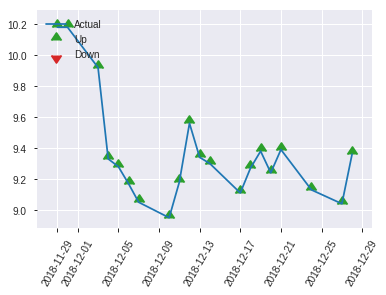


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26425043229683914
RMSE: 0.5140529469780707
LogLoss: 0.7293952276475516
Mean Per-Class Error: 0.44193650793650796
AUC: 0.5262857142857142
pr_auc: 0.4988190515677203
Gini: 0.05257142857142849
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38008087594490547: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   115  0.9127   (115.0/126.0)
1      5    120  0.04     (5.0/125.0)
Total  16   235  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380081     0.666667  234
max f2                       0.292377     0.833333  249
max f0point5                 0.565059     0.563481  143
max accuracy                 0.565059     0.557769  143
max precision                0.657978     0.557692  51
max recall                   0.292377     1         249
max specificity              0.948188     0.992063  0
max absolute_mcc             0.745902     0.12141   9
max min_per_class_accuracy   0.574764     0.515873  125
max mean_per_class_accuracy  0.565059     0.558063  143

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 56.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.827986           0.669333  0.669333           0.333333         0.901063  0.333333                    0.901063            0.008           0.008                      -33.0667  -33.0667
    2        0.0239044                   0.771733           0         0.334667           0                0.780257  0.166667                    0.84066             0               0.008                      -100      -66.5333
    3        0.0318725                   0.760618           1.004     0.502              0.5              0.767698  0.25                        0.82242             0.008           0.016                      0.4       -49.8
    4        0.0438247                   0.730784           0.669333  0.547636           0.333333         0.744014  0.272727                    0.801036            0.008           0.024                      -33.0667  -45.2364
    5        0.0517928                   0.716176           1.004     0.617846           0.5              0.719548  0.307692                    0.7885              0.008           0.032                      0.4       -38.2154
    6        0.103586                    0.684488           1.23569   0.926769           0.615385         0.697497  0.461538                    0.742998            0.064           0.096                      23.5692   -7.32308
    7        0.151394                    0.67106            1.33867   1.05684            0.666667         0.678448  0.526316                    0.722614            0.064           0.16                       33.8667   5.68421
    8        0.203187                    0.659864           1.23569   1.10243            0.615385         0.664529  0.54902                     0.707808            0.064           0.224                      23.5692   10.2431
    9        0.302789                    0.630349           0.88352   1.03042            0.44             0.643893  0.513158                    0.686783            0.088           0.312                      -11.648   3.04211
    10       0.40239                     0.611443           0.96384   1.01394            0.48             0.619769  0.50495                     0.670196            0.096           0.408                      -3.616    1.39406
    11       0.501992                    0.574764           1.12448   1.03587            0.56             0.592429  0.515873                    0.654766            0.112           0.52                       12.448    3.5873
    12       0.601594                    0.550706           1.2048    1.06384            0.6              0.565882  0.529801                    0.64005             0.12            0.64                       20.48     6.38411
    13       0.701195                    0.511082           0.96384   1.04964            0.48             0.527688  0.522727                    0.624089            0.096           0.736                      -3.616    4.96364
    14       0.800797                    0.467263           0.64256   0.999005           0.32             0.487997  0.497512                    0.607162            0.064           0.8                        -35.744   -0.0995025
    15       0.900398                    0.413657           1.04416   1.004              0.52             0.436897  0.5                         0.588328            0.104           0.904                      4.416     0.4
    16       1                           0.274523           0.96384   1                  0.48             0.36658   0.498008                    0.566241        

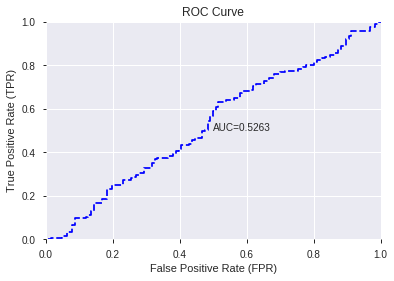

This function is available for GLM models only


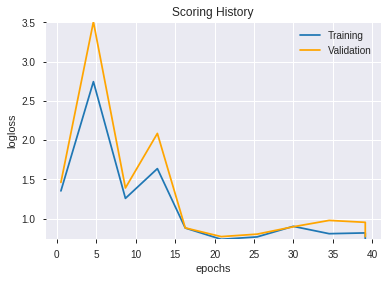

--2019-08-26 21:33:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_210046_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_210046_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'CDLMORNINGSTAR',
 'TANH',
 'CDLSTICKSANDWICH',
 'CDLONNECK',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLHIKKAKEMOD',
 'CDL3WHITESOLDIERS',
 'CDLINVERTEDHAMMER',
 'CDL3LINESTRIKE',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'CDLUNIQUE3RIVER',
 'SINH',
 'EXP',
 'COSH',
 'CDLTASUKIGAP',
 'CDLGAPSIDESIDEWHITE',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CDLHOMINGPIGEON',
 'CDLXSIDEGAP3METHODS',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDL3INSIDE',
 'SIN',
 'CDLDOJISTAR',
 'BOP',
 'aroonup_20',
 'aroonup_12',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'CDLSEPARATINGLINES',
 'COS',
 'AROONOSC_20',
 'HT_DCPERIOD',
 'CDL3OUTSIDE',
 'VAR_8',
 'CORREL_8',
 'CORREL_12',
 'AROONOSC_12',
 'CDLRICKSHAWMAN',
 'OBV',
 'CORREL_30',
 'CORREL_14',
 'STOCH_slowk',
 'CORREL_24',
 'AD',
 'DIV',
 'AROONOSC_14',
 'aroondown_8',
 'aroondown_12',
 'aroondown_14',
 'VAR_20',
 'CDLHARAMICROS

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190826_213352_model_1  0.546159  0.691049              0.464317  0.49895  0.248951

variable  relative_importance  scaled_importance    percentage
0                  CDL3INSIDE         8.830091e-03           1.000000  1.670915e-02
1                 CDL3OUTSIDE         7.470291e-03           0.846004  1.413601e-02
2              CDLMORNINGSTAR         7.096399e-03           0.803661  1.342849e-02
3             CDLLADDERBOTTOM         6.501501e-03           0.736289  1.230277e-02
4         CDLXSIDEGAP3METHODS         6.498750e-03           0.735978  1.229756e-02
..                        ...                  ...                ...           ...
966  BBANDS_middleband_14_5_3         1.658111e-06           0.000188  3.137639e-06
967              STOCHF_fastk         1.408493e-06           0.000160  2.665288e-06
968  BBANDS_middleband_20_3_4         1.358610e-06           0.000154  2.570893e-06
969   BBANDS_middleband_8_3_3         1.061850e-06           0.000120  2.009335e-06
970              MINMAX_min_8         3.247256e-07           0.000037  6.144773e-07

[971 rows x 4 columns]

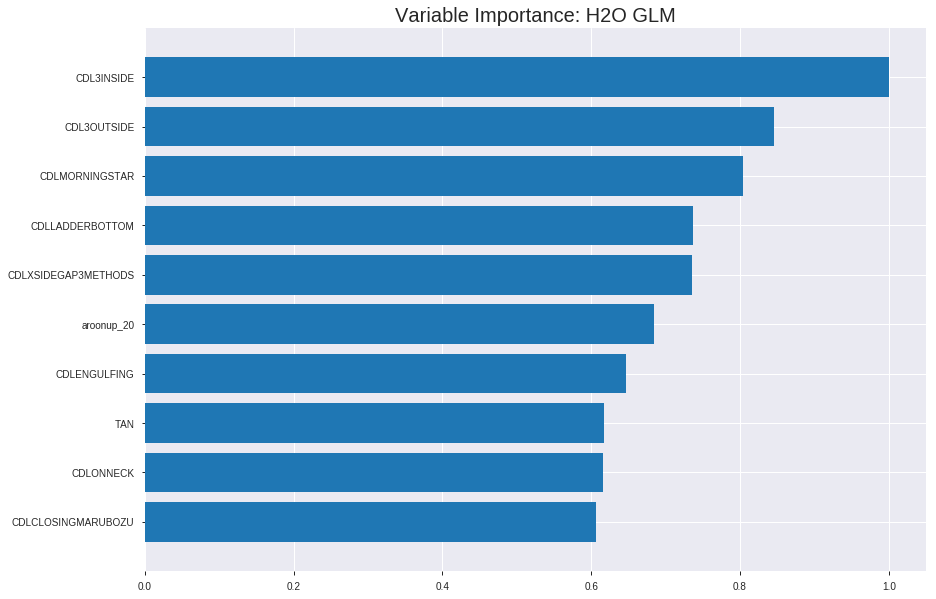

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_213352_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24779920977912062
RMSE: 0.49779434486454405
LogLoss: 0.6887369311949085
Null degrees of freedom: 1752
Residual degrees of freedom: 781
Null deviance: 2429.694244156657
Residual deviance: 2414.711680769349
AIC: 4358.711680769349
AUC: 0.566122034992878
pr_auc: 0.5659960190284241
Gini: 0.1322440699857561
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47080900511967727: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      38   824   0.9559   (824.0/862.0)
1      13   878   0.0146   (13.0/891.0)
Total  51   1702  0.4775   (837.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470809     0.677208  367
max f2                       0.455299     0.839616  388
max f0point5                 0.484113     0.576076  319
max accuracy                 0.502009     0.552196  226
max precision                0.57872      1         0
max recall                   0.455299     1         388
max specificity              0.57872      1         0
max absolute_mcc             0.484113     0.103406  319
max min_per_class_accuracy   0.511063     0.540603  185
max mean_per_class_accuracy  0.502009     0.550459  226

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.550859           1.63954   1.63954            0.833333         0.555052  0.833333                    0.555052            0.016835        0.016835                   63.9544   63.9544
    2        0.0205362                   0.546226           1.09303   1.36629            0.555556         0.548122  0.694444                    0.551587            0.0112233       0.0280584                  9.30291   36.6286
    3        0.0302339                   0.543166           1.15732   1.29926            0.588235         0.544566  0.660377                    0.549335            0.0112233       0.0392817                  15.7325   29.9261
    4        0.040502                    0.540958           0.874423  1.19156            0.444444         0.542206  0.605634                    0.547528            0.00897868      0.0482604                  -12.5577  19.1556
    5        0.0501997                   0.539114           1.15732   1.18494            0.588235         0.539887  0.602273                    0.546052            0.0112233       0.0594837                  15.7325   18.4943
    6        0.100399                    0.533127           1.18494   1.18494            0.602273         0.535917  0.602273                    0.540984            0.0594837       0.118967                   18.4943   18.4943
    7        0.150029                    0.52914            1.10811   1.15953            0.563218         0.531074  0.589354                    0.537706            0.0549944       0.173962                   10.8105   15.9525
    8        0.200228                    0.525768           1.2073    1.1715             0.613636         0.527407  0.595442                    0.535124            0.0606061       0.234568                   20.73     17.1503
    9        0.300057                    0.520418           1.02308   1.12212            0.52             0.522635  0.570342                    0.530969            0.102132        0.3367                     2.30752   12.2121
    10       0.399886                    0.515982           1.12426   1.12265            0.571429         0.518249  0.570613                    0.527794            0.112233        0.448934                   12.4258   12.2655
    11       0.500285                    0.511049           0.916654  1.08131            0.465909         0.51353   0.549601                    0.524931            0.0920314       0.540965                   -8.33461  8.13136
    12       0.600114                    0.502568           1.06805   1.07911            0.542857         0.507131  0.548479                    0.52197             0.106622        0.647587                   6.80455   7.91064
    13       0.699943                    0.495879           0.944377  1.05989            0.48             0.499144  0.538712                    0.518715            0.0942761       0.741863                   -5.56229  5.98908
    14       0.799772                    0.490098           0.910649  1.04126            0.462857         0.49318   0.529244                    0.515527            0.0909091       0.832772                   -8.93506  4.12622
    15       0.899601                    0.481626           0.966862  1.03301            0.491429         0.486436  0.525048                    0.512299            0.0965208       0.929293                   -3.31377  3.3006
    16       1                           0.428162           0.704258  1                  0.357955         0.472184  0.508272                    0.508272          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2502590767160798
RMSE: 0.5002590096300913
LogLoss: 0.6936707589893011
Null degrees of freedom: 500
Residual degrees of freedom: -471
Null deviance: 692.6521653604563
Residual deviance: 695.0581005072796
AIC: 2639.0581005072795
AUC: 0.45858945325137496
pr_auc: 0.5191001946436357
Gini: -0.08282109349725009
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45781015324482927: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    219  0.9955   (219.0/220.0)
1      0    281  0        (0.0/281.0)
Total  1    500  0.4371   (219.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45781      0.71959   398
max f2                       0.45781      0.865148  398
max f0point5                 0.45781      0.615958  398
max accuracy                 0.45781      0.562874  398
max precision                0.559537     1         0
max recall                   0.45781      1         398
max specificity              0.559537     1         0
max absolute_mcc             0.529941     0.104951  95
max min_per_class_accuracy   0.518759     0.472727  189
max mean_per_class_accuracy  0.483317     0.512917  331

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 51.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.553342           0.594306  0.594306           0.333333         0.555846  0.333333                    0.555846            0.00711744      0.00711744                 -40.5694   -40.5694
    2        0.0219561                   0.549945           0.356584  0.48625            0.2              0.551538  0.272727                    0.553888            0.00355872      0.0106762                  -64.3416   -51.375
    3        0.0319361                   0.548618           1.06975   0.668594           0.6              0.549258  0.375                       0.552441            0.0106762       0.0213523                  6.97509    -33.1406
    4        0.0419162                   0.544335           1.06975   0.764108           0.6              0.546994  0.428571                    0.551144            0.0106762       0.0320285                  6.97509    -23.5892
    5        0.0518962                   0.541996           1.06975   0.822885           0.6              0.542739  0.461538                    0.549528            0.0106762       0.0427046                  6.97509    -17.7115
    6        0.101796                    0.536334           0.784484  0.804061           0.44             0.538568  0.45098                     0.544155            0.0391459       0.0818505                  -21.5516   -19.5939
    7        0.151697                    0.533162           0.927117  0.84454            0.52             0.534748  0.473684                    0.541061            0.0462633       0.128114                   -7.28826   -15.546
    8        0.201597                    0.530837           0.855801  0.847327           0.48             0.531978  0.475248                    0.538813            0.0427046       0.170819                   -14.4199   -15.2673
    9        0.301397                    0.527067           0.998434  0.897363           0.56             0.528794  0.503311                    0.535495            0.0996441       0.270463                   -0.156584  -10.2637
    10       0.401198                    0.523857           1.03409   0.931375           0.58             0.52573   0.522388                    0.533066            0.103203        0.373665                   3.40925    -6.86248
    11       0.500998                    0.51838            1.03409   0.951837           0.58             0.521213  0.533865                    0.530705            0.103203        0.476868                   3.40925    -4.81632
    12       0.600798                    0.51296            0.962776  0.953654           0.54             0.515474  0.534884                    0.528175            0.0960854       0.572954                   -3.72242   -4.63461
    13       0.700599                    0.507006           1.10541   0.975271           0.62             0.509992  0.547009                    0.525585            0.11032         0.683274                   10.5409    -2.47285
    14       0.800399                    0.490803           1.14107   0.995944           0.64             0.500803  0.558603                    0.522495            0.113879        0.797153                   14.1068    -0.40557
    15       0.9002                      0.478554           1.06975   1.00413            0.6              0.483669  0.563193                    0.51819             0.106762        0.903915                   6.97509    0.412685
    16       1                           0.456938           0.962776  1                  0.54             0.472079  0.560878       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 21:33:55  0.000 sec   2            2.9       972           1.37747           1.38734
    2019-08-26 21:33:57  1.947 sec   4            2.1       972           1.37524           1.388
    2019-08-26 21:33:59  3.836 sec   6            1.5       972           1.37253           1.38904
    2019-08-26 21:34:01  5.753 sec   8            1.1       972           1.36928           1.39047
    2019-08-26 21:34:03  7.661 sec   10           0.81      972           1.36549           1.39239

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6794520547945206)

('auc', 0.5461587301587302)

('logloss', 0.6910490470854623)

('mean_per_class_error', 0.4375555555555556)

('rmse', 0.4989503595761651)

('mse', 0.24895146132118448)

glm prediction progress: |████████████████████████████████████████████████| 100%


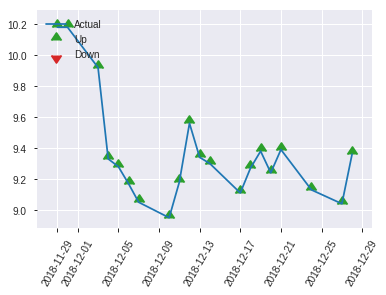


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24895146132118448
RMSE: 0.4989503595761651
LogLoss: 0.6910490470854623
Null degrees of freedom: 250
Residual degrees of freedom: -721
Null deviance: 348.0616751555067
Residual deviance: 346.90662163690206
AIC: 2290.906621636902
AUC: 0.5461587301587302
pr_auc: 0.515477795770071
Gini: 0.09231746031746035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4760457475101175: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   116  0.9206   (116.0/126.0)
1      1    124  0.008    (1.0/125.0)
Total  11   240  0.4661   (117.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476046     0.679452  239
max f2                       0.476046     0.837838  239
max f0point5                 0.478541     0.574549  231
max accuracy                 0.499932     0.561753  168
max precision                0.524793     0.583333  11
max recall                   0.457358     1         249
max specificity              0.541741     0.992063  0
max absolute_mcc             0.476046     0.174311  239
max min_per_class_accuracy   0.506183     0.552     123
max mean_per_class_accuracy  0.499932     0.562444  168

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.537531           0         0                  0                0.540301  0                           0.540301            0               0                          -100      -100
    2        0.0239044                   0.529667           1.33867   0.669333           0.666667         0.531832  0.333333                    0.536066            0.016           0.016                      33.8667   -33.0667
    3        0.0318725                   0.527493           1.004     0.753              0.5              0.527702  0.375                       0.533975            0.008           0.024                      0.4       -24.7
    4        0.0438247                   0.525441           2.008     1.09527            1                0.526086  0.545455                    0.531824            0.024           0.048                      100.8     9.52727
    5        0.0517928                   0.522755           1.004     1.08123            0.5              0.5243    0.538462                    0.530666            0.008           0.056                      0.4       8.12308
    6        0.103586                    0.518664           1.08123   1.08123            0.538462         0.51992   0.538462                    0.525293            0.056           0.112                      8.12308   8.12308
    7        0.151394                    0.515965           1.004     1.05684            0.5              0.51718   0.526316                    0.522731            0.048           0.16                       0.4       5.68421
    8        0.203187                    0.514102           0.772308  0.984314           0.384615         0.515105  0.490196                    0.520787            0.04            0.2                        -22.7692  -1.56863
    9        0.302789                    0.510457           1.2048    1.05684            0.6              0.512261  0.526316                    0.517983            0.12            0.32                       20.48     5.68421
    10       0.40239                     0.508455           1.12448   1.07358            0.56             0.509586  0.534653                    0.515904            0.112           0.432                      12.448    7.35842
    11       0.501992                    0.506045           1.2048    1.09962            0.6              0.507047  0.547619                    0.514147            0.12            0.552                      20.48     9.9619
    12       0.601594                    0.502274           0.8032    1.05054            0.4              0.504557  0.523179                    0.512559            0.08            0.632                      -19.68    5.0543
    13       0.701195                    0.499126           1.04416   1.04964            0.52             0.500566  0.522727                    0.510855            0.104           0.736                      4.416     4.96364
    14       0.800797                    0.494091           0.96384   1.03897            0.48             0.496687  0.517413                    0.509093            0.096           0.832                      -3.616    3.89652
    15       0.900398                    0.47978            1.04416   1.03954            0.52             0.487039  0.517699                    0.506653            0.104           0.936                      4.416     3.95398
    16       1                           0.450224           0.64256   1                  0.32             0.474437  0.498008                    0.503445            0.

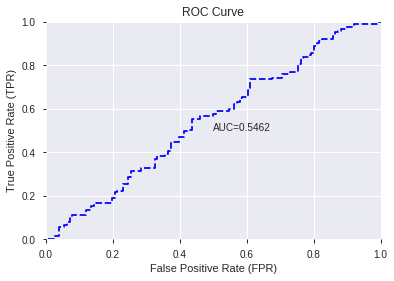

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


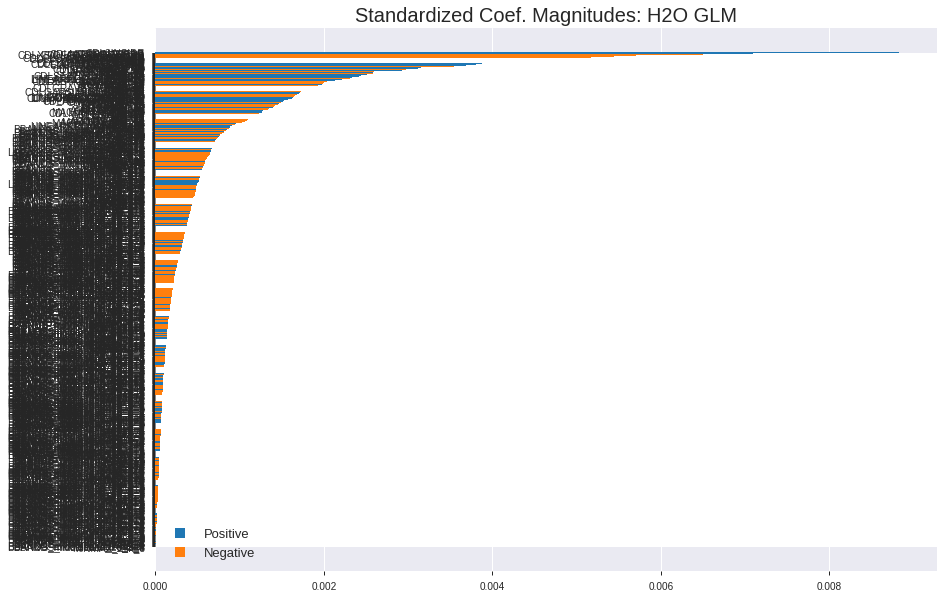

'log_likelihood'
--2019-08-26 21:34:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_213352_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_213352_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDL3INSIDE',
 'CDL3OUTSIDE',
 'CDLMORNINGSTAR',
 'CDLLADDERBOTTOM',
 'CDLXSIDEGAP3METHODS',
 'aroonup_20',
 'CDLENGULFING',
 'TAN',
 'CDLONNECK',
 'CDLCLOSINGMARUBOZU',
 'CDLTASUKIGAP',
 'CDLINVERTEDHAMMER',
 'MACDEXT_hist',
 'HT_DCPERIOD',
 'CDLHIGHWAVE',
 'aroondown_12',
 'EXP',
 'SINH',
 'COSH',
 'CDL3LINESTRIKE',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'HT_TRENDMODE',
 'CDLUNIQUE3RIVER',
 'ADXR_14',
 'BOP',
 'CORREL_14',
 'MINUS_DI_30',
 'BETA_30',
 'ADX_20',
 'CDLEVENINGSTAR',
 'ADX_24',
 'CORREL_12',
 'AROONOSC_12',
 'AROONOSC_20',
 'CDLHANGINGMAN',
 'ROCP_24',
 'ROCR_24',
 'ADXR_12',
 'MINUS_DI_24',
 'ROCR100_24',
 'ROC_24',
 'RSI_30',
 'CMO_30',
 'CDLSTALLEDPATTERN',
 'CMO_8',
 'RSI_8',
 'CORREL_8',
 'LINEARREG_SLOPE_20',
 'LINEARREG_ANGLE_20',
 'CDLSHORTLINE',
 'aroondown_30',
 'aroondown_8',
 'CDLSTICKSANDWICH',
 'CDLSEPARATINGLINES',
 'MINUS_DI_20',
 'MOM_24',
 'aroondown_14',
 'aroondown_24',
 'ADX_14',
 'MOM_30',
 'aroonup_30',
 'RSI_24',
 'CMO_24',

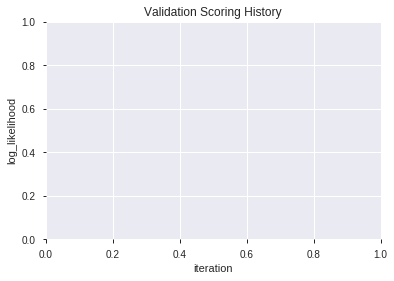

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_213428_model_5  0.580825  0.699963              0.440730  0.502487  0.252493
1  XGBoost_grid_1_AutoML_20190826_213428_model_1  0.547270  0.704959              0.460413  0.505192  0.255219
2               XGBoost_1_AutoML_20190826_213428  0.545016  0.703906              0.460413  0.504676  0.254698
3  XGBoost_grid_1_AutoML_20190826_213428_model_4  0.543238  0.694654              0.492095  0.500710  0.250711
4               XGBoost_3_AutoML_20190826_213428  0.526921  0.701784              0.472286  0.504043  0.254059
5  XGBoost_grid_1_AutoML_20190826_213428_model_2  0.518794  0.706313              0.492063  0.506141  0.256179
6  XGBoost_grid_1_AutoML_20190826_213428_model_7  0.517905  0.709462              0.488095  0.507727  0.257786
7               XGBoost_2_AutoML_20190826_213428  0.510349  0.710106              0.500000  0.507899  0.257961
8  XGBoost_grid_1_AutoML_20190826_213428_model_6  0.502159  0.704960              0.460349  0.505570  0.255601
9  XGBoost_grid_1_AutoML_20190826_213428_model_3  0.498667  0.701851              0.480222  0.504229  0.254247

variable  relative_importance  scaled_importance  percentage
0                        BOP           343.900635           1.000000    0.014769
1       HT_PHASOR_quadrature           284.724854           0.827928    0.012228
2                     TEMA_8           282.731293           0.822131    0.012142
3                HT_DCPERIOD           282.154541           0.820454    0.012118
4                    TRIMA_8           222.379410           0.646639    0.009550
..                       ...                  ...                ...         ...
669  BBANDS_lowerband_14_1_2             1.187342           0.003453    0.000051
670  BBANDS_upperband_12_5_5             1.126104           0.003275    0.000048
671                ROCR100_8             1.101922           0.003204    0.000047
672                   MA_8_7             0.970731           0.002823    0.000042
673                  DEMA_20             0.252412           0.000734    0.000011

[674 rows x 4 columns]

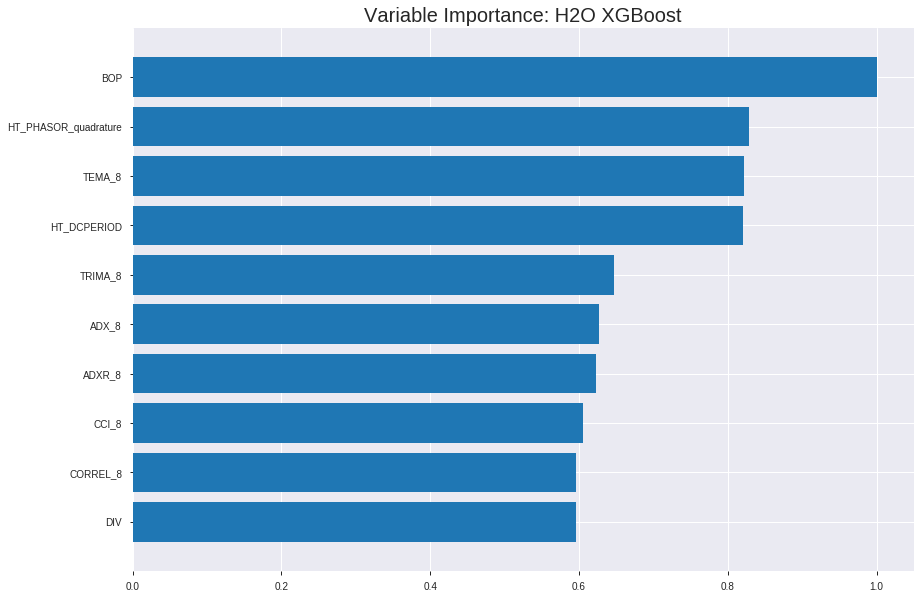

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_213428_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0460825142794688
RMSE: 0.2146683821140617
LogLoss: 0.23065311100651006
Mean Per-Class Error: 0.000580046403712231
AUC: 0.9999960939636114
pr_auc: 0.9977515500586148
Gini: 0.9999921879272229
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49007534980773926: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      861  1    0.0012   (1.0/862.0)
1      0    891  0        (0.0/891.0)
Total  861  892  0.0006   (1.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490075     0.999439  198
max f2                       0.490075     0.999776  198
max f0point5                 0.518156     0.999325  194
max accuracy                 0.490075     0.99943   198
max precision                0.926455     1         0
max recall                   0.490075     1         198
max specificity              0.926455     1         0
max absolute_mcc             0.490075     0.998859  198
max min_per_class_accuracy   0.497059     0.99884   197
max mean_per_class_accuracy  0.490075     0.99942   198

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.908537           1.96745   1.96745            1                0.916044  1                           0.916044            0.020202        0.020202                   96.7452   96.7452
    2        0.0205362                   0.899424           1.96745   1.96745            1                0.903098  1                           0.909571            0.020202        0.040404                   96.7452   96.7452
    3        0.0302339                   0.890182           1.96745   1.96745            1                0.895627  1                           0.905098            0.0190797       0.0594837                  96.7452   96.7452
    4        0.040502                    0.885732           1.96745   1.96745            1                0.888307  1                           0.900841            0.020202        0.0796857                  96.7452   96.7452
    5        0.0501997                   0.879887           1.96745   1.96745            1                0.883045  1                           0.897403            0.0190797       0.0987654                  96.7452   96.7452
    6        0.100399                    0.860976           1.96745   1.96745            1                0.869714  1                           0.883559            0.0987654       0.197531                   96.7452   96.7452
    7        0.150029                    0.842037           1.96745   1.96745            1                0.852155  1                           0.87317             0.0976431       0.295174                   96.7452   96.7452
    8        0.200228                    0.827636           1.96745   1.96745            1                0.835248  1                           0.863663            0.0987654       0.393939                   96.7452   96.7452
    9        0.300057                    0.79426            1.96745   1.96745            1                0.812408  1                           0.84661             0.196409        0.590348                   96.7452   96.7452
    10       0.399886                    0.750589           1.96745   1.96745            1                0.772585  1                           0.82813             0.196409        0.786756                   96.7452   96.7452
    11       0.500285                    0.602622           1.96745   1.96745            1                0.705079  1                           0.803436            0.197531        0.984287                   96.7452   96.7452
    12       0.600114                    0.262435           0.157396  1.66635            0.08             0.339154  0.846958                    0.726203            0.0157127       1                          -84.2604  66.635
    13       0.699943                    0.213634           0         1.42869            0                0.234275  0.726161                    0.656042            0               1                          -100      42.8688
    14       0.799772                    0.180374           0         1.25036            0                0.196911  0.635521                    0.598733            0               1                          -100      25.0357
    15       0.899601                    0.142649           0         1.1116             0                0.162941  0.564997                    0.550373            0               1                          -100      11.1604
    16       1                           0.0750229          0         1                  0                0.120077  0.508272                    0.507171          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26975239426387215
RMSE: 0.5193769288906392
LogLoss: 0.7370189573689152
Mean Per-Class Error: 0.47384341637010685
AUC: 0.5107813005499838
pr_auc: 0.5861665654646516
Gini: 0.02156260109996766
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20818951725959778: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    214  0.9727   (214.0/220.0)
1      2    279  0.0071   (2.0/281.0)
Total  8    493  0.4311   (216.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.20819      0.72093   391
max f2                       0.185008     0.865148  398
max f0point5                 0.20819      0.619174  391
max accuracy                 0.20819      0.568862  391
max precision                0.851589     1         0
max recall                   0.185008     1         398
max specificity              0.851589     1         0
max absolute_mcc             0.707751     0.089032  29
max min_per_class_accuracy   0.492789     0.512456  197
max mean_per_class_accuracy  0.562915     0.526157  135

Gains/Lift Table: Avg response rate: 56.09 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.790879           1.48577   1.48577            0.833333         0.817253  0.833333                    0.817253            0.0177936       0.0177936                  48.5765    48.5765
    2        0.0219561                   0.76383            1.06975   1.29667            0.6              0.777697  0.727273                    0.799273            0.0106762       0.0284698                  6.97509    29.6668
    3        0.0319361                   0.755736           1.06975   1.22576            0.6              0.760332  0.6875                      0.787104            0.0106762       0.0391459                  6.97509    22.5756
    4        0.0419162                   0.73448            1.42633   1.27351            0.8              0.739742  0.714286                    0.775827            0.0142349       0.0533808                  42.6335    27.3513
    5        0.0518962                   0.724862           1.42633   1.3029             0.8              0.73014   0.730769                    0.767041            0.0142349       0.0676157                  42.6335    30.2902
    6        0.101796                    0.687342           0.998434  1.15365            0.56             0.70357   0.647059                    0.735928            0.0498221       0.117438                   -0.156584  15.3653
    7        0.151697                    0.649948           0.784484  1.03222            0.44             0.666874  0.578947                    0.713213            0.0391459       0.156584                   -21.5516   3.22158
    8        0.201597                    0.629121           1.21238   1.07681            0.68             0.640459  0.60396                     0.695204            0.0604982       0.217082                   21.2384    7.6812
    9        0.301397                    0.572103           0.998434  1.05086            0.56             0.599405  0.589404                    0.663483            0.0996441       0.316726                   -0.156584  5.0859
    10       0.401198                    0.540531           0.962776  1.02895            0.54             0.554002  0.577114                    0.636249            0.0960854       0.412811                   -3.72242   2.89478
    11       0.500998                    0.490697           0.998434  1.02287            0.56             0.517877  0.573705                    0.612669            0.0996441       0.512456                   -0.156584  2.28694
    12       0.600798                    0.455098           0.891459  1.00104            0.5              0.471186  0.561462                    0.589167            0.088968        0.601423                   -10.8541   0.104042
    13       0.700599                    0.39955            0.855801  0.980351           0.48             0.42468   0.549858                    0.565736            0.0854093       0.686833                   -14.4199   -1.9649
    14       0.800399                    0.350603           1.14107   1.00039            0.64             0.374654  0.561097                    0.54191             0.113879        0.800712                   14.1068    0.0390483
    15       0.9002                      0.281851           0.891459  0.988314           0.5              0.319243  0.554324                    0.517224            0.088968        0.88968                    -10.8541   -1.16862
    16       1                           0.173503           1.10541   1                  0.62             0.240862  0.560878                  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:34:57  14.727 sec  0                  0.5              0.693147            0.5             0                  1                0.491728                         0.5                0.693147              0.5               0                    1                  0.439122
    2019-08-26 21:34:59  15.995 sec  5                  0.455496         0.607522            0.957344        0.955178           1.96745          0.107245                         0.500112           0.693395              0.525687          0.578697             0.891459           0.437126
    2019-08-26 21:34:59  16.678 sec  10                 0.412912         0.53117             0.991663        0.990221           1.96745          0.0450656                        0.502324           0.697941              0.518489          0.583682             1.18861            0.439122
    2019-08-26 21:35:00  17.356 sec  15                 0.374338         0.465826            0.997057        0.996097           1.96745          0.0222476                        0.506374           0.70644               0.50774           0.571549             0.891459           0.437126
    2019-08-26 21:35:01  18.011 sec  20                 0.345417         0.419128            0.99893         0.996731           1.96745          0.0148317                        0.509082           0.712037              0.489259          0.573975             1.48577            0.437126
    2019-08-26 21:35:01  18.739 sec  25                 0.321843         0.382491            0.999651        0.997418           1.96745          0.00684541                       0.511105           0.716683              0.491071          0.573419             1.78292            0.437126
    2019-08-26 21:35:02  19.442 sec  30                 0.298174         0.346678            0.99976         0.998647           1.96745          0.00570451                       0.51559            0.726596              0.483323          0.568313             1.48577            0.439122
    2019-08-26 21:35:03  20.265 sec  35                 0.271781         0.308692            0.99993         0.998811           1.96745          0.00399315                       0.516272           0.729218              0.500704          0.577561             1.18861            0.439122
    2019-08-26 21:35:04  20.975 sec  40                 0.253273         0.282315            0.999949        0.998829           1.96745          0.0034227                        0.517407           0.731769              0.49945           0.578952             1.18861            0.439122
    2019-08-26 21:35:04  21.810 sec  45                 0.232105         0.253641            0.999986        0.998864           1.96745          0.00171135                       0.519172           0.736029              0.501553          0.582495             1.48577            0.437126
    2019-08-26 21:35:05  22.595 sec  50                 0.214668         0.230653            0.999996        0.997752           1.96745          0.000570451                      0.519377           0.737019              0.510781          0.586167             1.48577            0.431138

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      343.900634765625       1.0                    0.01476933312675139
HT_PHASOR_quadrature     284.724853515625       0.8279276765792263     0.012227939660255876
TEMA_8                   282.7312927246094      0.8221307672703084     0.012142323175566903
HT_DCPERIOD              282.154541015625       0.8204536790341165     0.012117553700723628
TRIMA_8                  222.37940979003906     0.6466385557607214     0.009550420242631497
---                      ---                    ---                    ---
BBANDS_lowerband_14_1_2  1.1873416900634766     0.0034525719642031867  5.099218548339923e-05
BBANDS_upperband_12_5_5  1.1261043548583984     0.00327450501981731    4.836225546290151e-05
ROCR100_8                1.1019221544265747     0.0032041876141855807  4.732371427451759e-05
MA_8_7                   0.9707309603691101     0.002822707672612126   4.168950993624559e-05
DEMA_20                  0.2524118423461914     0.0007339673639108431  1.0840208501762806e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5816733067729084)

('F1', 0.6782608695652175)

('auc', 0.5808253968253968)

('logloss', 0.6999628550506084)

('mean_per_class_error', 0.4178412698412699)

('rmse', 0.5024871227986092)

('mse', 0.2524933085784245)

xgboost prediction progress: |████████████████████████████████████████████| 100%


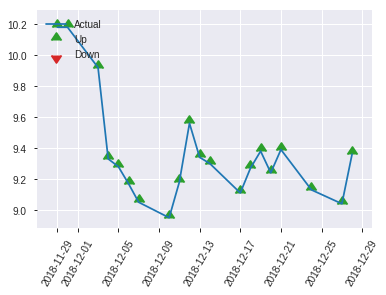


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2524933085784245
RMSE: 0.5024871227986092
LogLoss: 0.6999628550506084
Mean Per-Class Error: 0.4178412698412699
AUC: 0.5808253968253968
pr_auc: 0.5645180965778337
Gini: 0.1616507936507936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4479583501815796: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   103  0.8175   (103.0/126.0)
1      8    117  0.064    (8.0/125.0)
Total  31   220  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447958     0.678261  219
max f2                       0.244319     0.835561  247
max f0point5                 0.546324     0.58745   155
max accuracy                 0.546324     0.581673  155
max precision                0.780161     0.75      7
max recall                   0.244319     1         247
max specificity              0.844141     0.992063  0
max absolute_mcc             0.447958     0.180141  219
max min_per_class_accuracy   0.583491     0.552     123
max mean_per_class_accuracy  0.546324     0.582159  155

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 57.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.803806           0.669333  0.669333           0.333333         0.826163  0.333333                    0.826163            0.008           0.008                      -33.0667  -33.0667
    2        0.0239044                   0.798473           2.008     1.33867            1                0.801282  0.666667                    0.813723            0.024           0.032                      100.8     33.8667
    3        0.0318725                   0.778381           2.008     1.506              1                0.787662  0.75                        0.807208            0.016           0.048                      100.8     50.6
    4        0.0438247                   0.762894           0.669333  1.27782            0.333333         0.767938  0.636364                    0.796498            0.008           0.056                      -33.0667  27.7818
    5        0.0517928                   0.753038           2.008     1.39015            1                0.754767  0.692308                    0.790078            0.016           0.072                      100.8     39.0154
    6        0.103586                    0.731161           1.23569   1.31292            0.615385         0.743269  0.653846                    0.766673            0.064           0.136                      23.5692   31.2923
    7        0.151394                    0.701724           1.506     1.37389            0.75             0.718509  0.684211                    0.751464            0.072           0.208                      50.6      37.3895
    8        0.203187                    0.683641           0.463385  1.1418             0.230769         0.69141   0.568627                    0.736156            0.024           0.232                      -53.6615  14.1804
    9        0.302789                    0.6507             1.12448   1.13611            0.56             0.665714  0.565789                    0.712984            0.112           0.344                      12.448    13.6105
    10       0.40239                     0.615454           1.04416   1.11335            0.52             0.633691  0.554455                    0.693357            0.104           0.448                      4.416     11.3347
    11       0.501992                    0.577674           1.04416   1.09962            0.52             0.596117  0.547619                    0.674063            0.104           0.552                      4.416     9.9619
    12       0.601594                    0.550851           1.2048    1.11703            0.6              0.562908  0.556291                    0.65566             0.12            0.672                      20.48     11.7033
    13       0.701195                    0.524164           0.8032    1.07245            0.4              0.538183  0.534091                    0.638973            0.08            0.752                      -19.68    7.24545
    14       0.800797                    0.492878           0.88352   1.04896            0.44             0.509207  0.522388                    0.622833            0.088           0.84                       -11.648   4.89552
    15       0.900398                    0.41843            0.96384   1.03954            0.48             0.465023  0.517699                    0.605376            0.096           0.936                      -3.616    3.95398
    16       1                           0.182609           0.64256   1                  0.32             0.343178  0.498008                    0.579261            

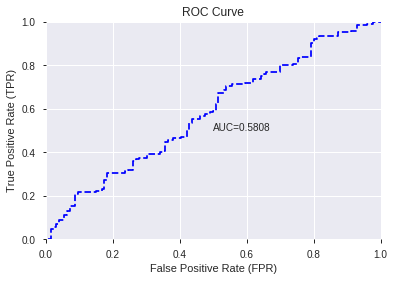

This function is available for GLM models only


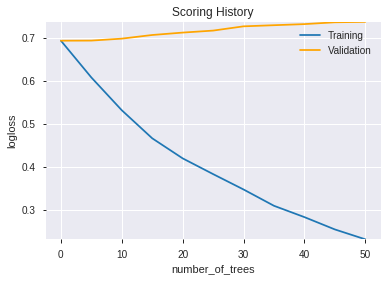

--2019-08-26 21:35:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_213428_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_213428_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8505',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'HT_PHASOR_quadrature',
 'TEMA_8',
 'HT_DCPERIOD',
 'TRIMA_8',
 'ADX_8',
 'ADXR_8',
 'CCI_8',
 'CORREL_8',
 'DIV',
 'TRANGE',
 'BETA_12',
 'BETA_8',
 'HT_PHASOR_inphase',
 'BETA_14',
 'DX_20',
 'STOCHF_fastk',
 'WILLR_8',
 'ADXR_12',
 'BETA_20',
 'MACDFIX_hist_8',
 'STOCH_slowd',
 'CCI_12',
 'STOCH_slowk',
 'DX_8',
 'MFI_14',
 'MFI_12',
 'ULTOSC',
 'PLUS_DM_8',
 'COS',
 'STDDEV_12',
 'WILLR_12',
 'TAN',
 'MACDEXT_hist',
 'MFI_8',
 'SUB',
 'MFI_24',
 'DX_14',
 'LINEARREG_ANGLE_8',
 'CORREL_30',
 'ADOSC',
 'OBV',
 'PLUS_DI_8',
 'CORREL_12',
 'BETA_24',
 'MFI_20',
 'MOM_8',
 'MACDFIX_hist_12',
 'WILLR_20',
 'SIN',
 'ADX_24',
 'CORREL_24',
 'MINUS_DI_8',
 'MOM_12',
 'CCI_14',
 'T3_8_0',
 'CMO_8',
 'BETA_30',
 'STOCHRSI_fastd',
 'MOM_14',
 'CORREL_14',
 'STDDEV_30',
 'STOCHRSI_fastk',
 'ROCP_8',
 'DX_24',
 'MOM_20',
 'PLUS_DM_12',
 'AD',
 'CORREL_20',
 'MINUS_DI_12',
 'ROC_12',
 'CCI_24',
 'LINEARREG_ANGLE_12',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_24',
 'MOM_24',
 'STDDEV_20',
 'MA_8_0

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.558
GLM             0.562
XGBoost         0.582
dtype: float64

DeepLearning    GLM  XGBoost
All          0.550  0.546    0.562
DLF          0.554  0.546    0.530
Fwe          0.558  0.546    0.562
RFE          0.558  0.562    0.582
XGBF         0.546  0.546    0.530





F1


DeepLearning    0.680
GLM             0.679
XGBoost         0.682
dtype: float64

DeepLearning    GLM  XGBoost
All          0.665  0.678    0.682
DLF          0.680  0.670    0.665
Fwe          0.672  0.678    0.682
RFE          0.667  0.679    0.678
XGBF         0.665  0.670    0.665





auc


DeepLearning    0.542
GLM             0.546
XGBoost         0.581
dtype: float64

DeepLearning    GLM  XGBoost
All          0.542  0.538    0.536
DLF          0.514  0.495    0.513
Fwe          0.536  0.538    0.536
RFE          0.526  0.546    0.581
XGBF         0.533  0.495    0.513





logloss


DeepLearning    0.729
GLM             0.694
XGBoost         0.700
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.691    0.698
DLF          0.704  0.694    0.699
Fwe          0.726  0.691    0.698
RFE          0.729  0.691    0.700
XGBF         0.696  0.694    0.699





mean_per_class_error


DeepLearning    0.455
GLM             0.453
XGBoost         0.470
dtype: float64

DeepLearning    GLM  XGBoost
All          0.449  0.453    0.437
DLF          0.445  0.453    0.470
Fwe          0.441  0.453    0.437
RFE          0.442  0.438    0.418
XGBF         0.455  0.453    0.470





rmse


DeepLearning    0.514
GLM             0.500
XGBoost         0.503
dtype: float64

DeepLearning    GLM  XGBoost
All          0.499  0.499    0.502
DLF          0.505  0.500    0.503
Fwe          0.513  0.499    0.502
RFE          0.514  0.499    0.502
XGBF         0.501  0.500    0.503





mse


DeepLearning    0.264
GLM             0.250
XGBoost         0.253
dtype: float64

DeepLearning    GLM  XGBoost
All          0.249  0.249    0.252
DLF          0.255  0.250    0.253
Fwe          0.263  0.249    0.252
RFE          0.264  0.249    0.252
XGBF         0.251  0.250    0.253

{'F1':       DeepLearning    GLM  XGBoost
 All          0.665    NaN      NaN
 DLF          0.680    NaN      NaN
 DLF            NaN  0.670      NaN
 DLF            NaN    NaN    0.665
 All            NaN  0.678      NaN
 All            NaN    NaN    0.682
 XGBF         0.665    NaN      NaN
 XGBF           NaN  0.670      NaN
 XGBF           NaN    NaN    0.665
 Fwe          0.672    NaN      NaN
 Fwe            NaN  0.678      NaN
 Fwe            NaN    NaN    0.682
 RFE          0.667    NaN      NaN
 RFE            NaN  0.679      NaN
 RFE            NaN    NaN    0.678,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.550    NaN      NaN
 DLF          0.554    NaN      NaN
 DLF            NaN  0.546      NaN
 DLF            NaN    NaN    0.530
 All            NaN  0.546      NaN
 All            NaN    NaN    0.562
 XGBF         0.546    NaN      NaN
 XGBF           NaN  0.546      NaN
 XGBF           NaN    NaN    0.530
 Fwe          0.558    NaN      NaN
 Fwe     